<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
  <img src="https://francia.unam.mx/wp-content/uploads/2021/10/Logo-UNAM-Azul-Landscape.png" alt="UNAM" width="225" height="125">
  <img src="https://mcdonaldinstitute.ca/wp-content/uploads/2018/05/PI-logo-2017-Black-1280x424.png.webp" alt="Perimeter" width="200" height="100">
  <img src="https://swanseauniversity.cloud.panopto.eu/Panopto/ContentCache/637582254009215017/_branding/f80a49ed-5120-415e-89fe-ab8900ad7d40/637582253354333331_largelogo.png" alt="Swansea" width="225" height="125">
</div>


<h1 align="center">
Stochastic Gravitational Waves from Primordial Black Holes<br>
in Dwarf Galaxies
</h1>

<h3 align="center">
Tadeo D. Gómez-Aguilar $^{a,\dagger}$, Encieh Erfani $^{b}$ and Nayeli Marisol Jiménez Cruz $^{c}$
</h3>

#### $^{a}$Instituto de Ciencias Físicas, Universidad Nacional Autónoma de México, 62210, Cuernavaca, Morelos, México. $^{b}$Perimeter Institute for Theoretical Physics, Waterloo, ON N2L 2Y5, Canada. $^{c}$Physics Department, Swansea University, SA28PP, United Kingdom.


**Abstract**
<div style="background-color: #ffe4e1; padding: 10px;">
We investigate the Stochastic Gravitational Wave Background (SGWB) generated by Close Hyperbolic Encounters (CHEs) of Primordial Black Holes (PBHs) within dark matter-dominated dwarf galaxies. Building upon our previous work, this study incorporates the full hierarchical merger history of PBHs to evaluate their cumulative contribution to the SGWB. Our framework identifies the conditions under which gravitational waves from CHEs
and successive PBH mergers become significant components of the observable SGWB, and allows for a direct comparison with signals from standard PBH mergers. We determine the parameter space in which these signals may be detected by next-generation gravitational wave observatories, including the Einstein Telescope, LISA, Pulsar Timing Arrays (PTAs), and the Square Kilometre Array (SKA). Furthermore, we present numerical criteria that define the validity range of our analytical models.
</div>


**Corresponse author:**
$^{\dagger}$[tadeo.dga@icf.unam.mx](mailto:tadeo.dga@icf.unam.mx)

<h3 align="center">
Code writed by Tadeo D.
</h3>
    
<h5 align="right">
Dedicated to Elizabeth América Flores Frías.
</h5>

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
from astropy import constants as cte0

In [2]:
# --- Constantes ---
c = 299792458 # m/s
c_ast = 299792.458 # km/s
G = 6.6743e-11 # m^3 / (kg s^2)
G_ast = 4.517103049894964e-30 # pc^3 / (s^2 solMass)

In [3]:
# Parámetros del cúmulo
M_DM_cluster = 1e5
M_PBH = 10
N_PBH_i_Msun = M_DM_cluster / (2 * M_PBH)
N_PBH_j_Msun = M_DM_cluster / (2 * M_PBH)
N_PBH_total = 2 * N_PBH_i_Msun
R_cluster = 1.096132

# Radios de evaluación
r_values_pc = np.linspace(0.1, R_cluster, 10)

In [4]:
print("BOUNDARY CONDITIONS TO CLUSTER")
print(f"Number of PBHs into cluster: {N_PBH_total:.0f} of {M_PBH} Solar Masses")
print(f"Cluster radius (parsecs): {R_cluster:.1f}")

BOUNDARY CONDITIONS TO CLUSTER
Number of PBHs into cluster: 10000 of 10 Solar Masses
Cluster radius (parsecs): 1.1


radius (pc)    n_pbh(r)
0.10           1776
0.21           1656
0.32           1475
0.43           1263
0.54           1048
0.65           848 
0.76           673 
0.87           529 
0.99           412 
1.10           320 


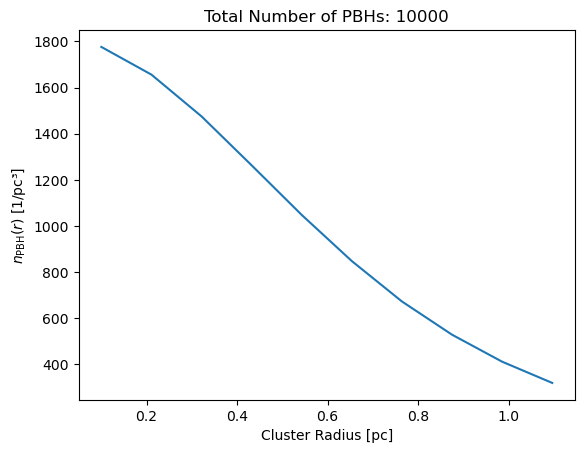

In [5]:
# --- Funciones físicas ---
def rho(r):
    factor = (3 * M_DM_cluster) / (4 * np.pi * R_cluster**3)
    shape = 1 + (r / R_cluster)**2
    return factor * shape**(-2.5)

def n_pbh(r, M_pbh):
    return (rho(r) / M_pbh)

n_PBH_r = np.array([
    round(n_pbh(r, M_PBH))
    for r in r_values_pc
])
n_total = np.sum(n_PBH_r)

# Imprimir
print(f"{'radius (pc)':<15}{'n_pbh(r)'}")
print("=" * 24)
for r, n in zip(r_values_pc, n_PBH_r):
    print(f"{r:<15.2f}{n:<4}")

plt.plot(r_values_pc, n_PBH_r)
plt.xlabel("Cluster Radius [pc]")
plt.ylabel("$n_\\mathrm{PBH}(r)$ [1/pc³]")
plt.title(f"Total Number of PBHs: {int(n_total)}")
plt.show()

In [6]:
def phi(r, M_cluster):
    phi_r = ((G_ast * M_cluster / R_cluster) * (1 + (r / R_cluster)**2)**(-0.5))
    return phi_r * 9.5214e26 # km^2/s^2

def f_E(E, N_pbh, M_cluster):
    E = E / 9.5214e26
    num = 24 * np.sqrt(2) * N_pbh * R_cluster**2 * E**(3.5)
    denom = 7 * np.pi**3 * G_ast**5 * M_cluster**5
    return (num / denom) * 3.404e-41

def integrand(E_val, r, N_pbh, M_cluster):
    phi_val = phi(r, M_cluster)
    delta_E = 2 * (phi_val - E_val)
    return f_E(E_val, N_pbh, M_cluster) * delta_E**1.5

def mean_square_velocity(r, M_cluster, N_pbh, M_pbh):
    n_r = (rho(r) / M_pbh)
    if n_r == 0:
        return 0.0
    phi_r = phi(r, M_cluster)
    integral, _ = spi.quad(integrand, 0, phi_r, args=(r, N_pbh, M_cluster))
    return np.sqrt((4 * np.pi / n_r) * integral)

In [7]:
v_mean_values = np.array([
    mean_square_velocity(r, M_DM_cluster, N_PBH_total, M_PBH)
    for r in r_values_pc
])

for r, v in zip(r_values_pc, v_mean_values):
    print(f"r = {r:.2f},  v_rms = {v:.3f}")

v_0 = np.mean(v_mean_values) #(u.km / u.s)

print(f"\n v0 = {v_0:.3f}")

r = 0.10,  v_rms = 13.978
r = 0.21,  v_rms = 13.881
r = 0.32,  v_rms = 13.721
r = 0.43,  v_rms = 13.511
r = 0.54,  v_rms = 13.260
r = 0.65,  v_rms = 12.982
r = 0.76,  v_rms = 12.687
r = 0.87,  v_rms = 12.384
r = 0.99,  v_rms = 12.079
r = 1.10,  v_rms = 11.779

 v0 = 13.026


In [8]:
km_to_pc = 1 / 3.085677581e13 
# --- Secciones eficaces ---
def sigma_BPBH(m1, m2, v_i, v_j):
    G_astro = G_ast
    c_astro = c_ast
    prefactor = (340 * np.pi / 3)**(2/7)
    num = np.pi * prefactor * G_astro**2 * (m1 + m2)**(10/7) * (m1 * m2)**(2/7)
    if v_i == v_j:
        denom = c_astro**(10/7) * np.abs(v_0)**(18/7)
    else:
        denom = c_astro**(10/7) * (np.abs(v_i - v_j))**(18/7)
    return (num / denom) * (3.085677581e13)**4

def sigma_CHES(m1, m2, v_i, v_j):
    G_astro = G_ast
    e = 1.000001
    if v_i == v_j:
        b = (G_astro * (m1 + m2) / v_i**2)
    else:
        b = (G_astro * (m1 + m2) / (np.abs(v_i - v_j))**2)
    b = b / (3.085677581e13**-2)
    return np.pi * b**2 * (e**2 - 1)

In [9]:
# --- Integral I ---
def integrand_I(r_i, r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    if M_pbh_i == M_pbh_j:
        n_i = n_pbh(r_i, M_pbh_i) / 2
        n_j = n_i
        v_i = mean_square_velocity(r_i, M_cluster, 2*N_pbh_i, M_pbh_i) * km_to_pc
        v_j = v_i
    else:
        n_i = n_pbh(r_i, M_pbh_i)
        v_i = mean_square_velocity(r_i, M_cluster, N_pbh_i, M_pbh_i) * km_to_pc
        v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc
    term = (v_j + v_i)**(3/7) - abs(v_j - v_i)**(3/7)
    return r_i**2 * (n_i / v_i) * term

def I_rj(r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    args = (r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster)
    integral, _ = spi.quad(integrand_I, 0.1 * R_cluster, R_cluster, args=args)
    return integral

I_values = np.array([I_rj(r_j, N_PBH_i_Msun, M_PBH, N_PBH_j_Msun, M_PBH, M_DM_cluster) for r_j in r_values_pc])
coeffs = np.polyfit(r_values_pc, I_values, 3)

In [10]:
# --- Gamma ---
def Gamma_rj(r_j, N_pbh_j, M_pbh_j, N_pbh_i, M_pbh_i, M_cluster):
    n_j = n_pbh(r_j, M_pbh_j)
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc
    v_i = mean_square_velocity(r_j, M_cluster, N_pbh_i, M_pbh_i) * km_to_pc
    sigma_B = sigma_BPBH(M_pbh_i, M_pbh_j, v_i/km_to_pc, v_j/km_to_pc)
    sigma_C = sigma_CHES(M_pbh_i, M_pbh_j, v_i/km_to_pc, v_j/km_to_pc)
    if v_j == 0 or n_j == 0:
        return 0, 0
    I_val = np.polyval(coeffs, r_j)
    if v_i == v_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, N_pbh_i*2, M_pbh_i)
            for r in r_values_pc]
        )
        v_0 = np.mean(v_mean_values) * km_to_pc
        gamma_BBH = (v_0)**(18/7) * (14 * np.pi / 3) * sigma_B * (n_j / v_j) * I_val
        gamma_CHE = (v_0)**(18/7) * (14 * np.pi / 3) * sigma_C * (n_j / v_j) * I_val
    else:
        gamma_BBH = (np.abs(v_i - v_j))**(18/7) * (14 * np.pi / 3) * sigma_B * (n_j / v_j) * I_val
        gamma_CHE = (np.abs(v_i - v_j))**(18/7) * (14 * np.pi / 3) * sigma_C * (n_j / v_j) * I_val
    return gamma_BBH, gamma_CHE

r = 0.100 pc | Gamma_BBH = 4.730e-18 [1/s] | Gamma_CHE = 1.348e-17 [1/s]
r = 0.211 pc | Gamma_BBH = 4.441e-18 [1/s] | Gamma_CHE = 1.302e-17 [1/s]
r = 0.321 pc | Gamma_BBH = 4.003e-18 [1/s] | Gamma_CHE = 1.229e-17 [1/s]
r = 0.432 pc | Gamma_BBH = 3.482e-18 [1/s] | Gamma_CHE = 1.137e-17 [1/s]
r = 0.543 pc | Gamma_BBH = 2.942e-18 [1/s] | Gamma_CHE = 1.036e-17 [1/s]
r = 0.653 pc | Gamma_BBH = 2.431e-18 [1/s] | Gamma_CHE = 9.317e-18 [1/s]
r = 0.764 pc | Gamma_BBH = 1.977e-18 [1/s] | Gamma_CHE = 8.305e-18 [1/s]
r = 0.875 pc | Gamma_BBH = 1.590e-18 [1/s] | Gamma_CHE = 7.359e-18 [1/s]
r = 0.985 pc | Gamma_BBH = 1.271e-18 [1/s] | Gamma_CHE = 6.498e-18 [1/s]
r = 1.096 pc | Gamma_BBH = 1.013e-18 [1/s] | Gamma_CHE = 5.729e-18 [1/s]


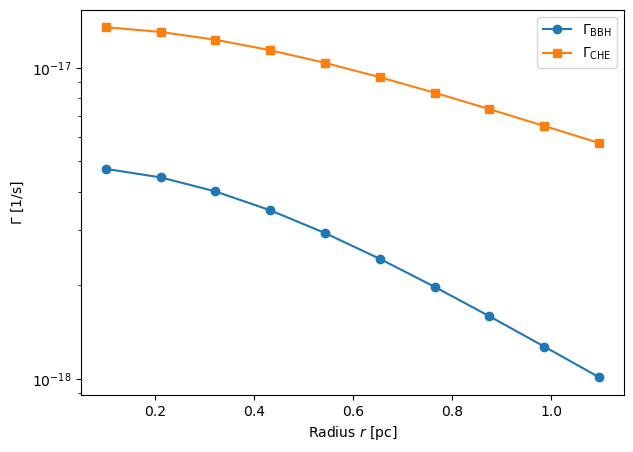

In [11]:
Gamma_BBH_values = np.array([
    Gamma_rj(r_j, N_PBH_j_Msun, M_PBH, N_PBH_i_Msun, M_PBH, M_DM_cluster)[0]
    for r_j in r_values_pc
])

Gamma_CHES_values = np.array([
    Gamma_rj(r_j, N_PBH_j_Msun, M_PBH, N_PBH_i_Msun, M_PBH, M_DM_cluster)[1]
    for r_j in r_values_pc
])

for r, g_bbh, g_che in zip(r_values_pc, Gamma_BBH_values, Gamma_CHES_values):
    print(f"r = {r:.3f} pc | Gamma_BBH = {g_bbh:.3e} [1/s] | Gamma_CHE = {g_che:.3e} [1/s]")

# Graficar
plt.figure(figsize=(7,5))
plt.plot(r_values_pc, Gamma_BBH_values, 'o-', label=r'$\Gamma_{\mathrm{BBH}}$')
plt.plot(r_values_pc, Gamma_CHES_values, 's-', label=r'$\Gamma_{\mathrm{CHE}}$')
plt.xlabel("Radius $r$ [pc]")
plt.ylabel(r"$\Gamma$ [1/s]")
plt.yscale('log')
plt.legend()
plt.show()

In [12]:
# Edad del universo
age_universe_Gyr = 13.786885302009708  # Gyr
age_universe_yr = age_universe_Gyr * 1e9  # yr

# Conversión de tasas a unidades por año
seconds_per_year = 3.15576e7  # s/yr
Gamma_BBH_values_yr = Gamma_BBH_values * seconds_per_year
Gamma_CHES_values_yr = Gamma_CHES_values * seconds_per_year

time_first_merger_yr =  1/Gamma_BBH_values_yr
time_first_merger_Gyr = time_first_merger_yr / 1e9

time_first_ches_yr = 1/Gamma_CHES_values_yr
time_first_ches_Gyr = time_first_ches_yr / 1e9

In [13]:
print(f"{'Gamma_BPBH(yr^-1)':<20}{'Time to 1st merger (Gyr)':<28}{'Gamma_CHES(yr^-1)':<20}{'Time to 1st CHEs (yr)':<28}")
print("=" * 90)
for i in range(len(r_values_pc)):
    print(f"{Gamma_BBH_values_yr[i]:<20.3e}{time_first_merger_Gyr[i]:<28.3e}{Gamma_CHES_values_yr[i]:<20.3e}{time_first_ches_yr[i]:.3e}")


time_z_20 = cosmo.age(20).to(u.yr).value
delta_t_merger = np.min(time_first_merger_yr)
print("\nTime necessary to all PBHs\nfrom first radius coallesences:", delta_t_merger/1e9, "Gyr")

delta_t_CHEs = np.min(time_first_ches_yr)# + time_z_20
print("\nTime necessary to maximum probability\nto produces CHEs in the first shell: ",delta_t_CHEs,"years")

Gamma_BPBH(yr^-1)   Time to 1st merger (Gyr)    Gamma_CHES(yr^-1)   Time to 1st CHEs (yr)       
1.493e-10           6.699e+00                   4.255e-10           2.350e+09
1.402e-10           7.135e+00                   4.109e-10           2.434e+09
1.263e-10           7.916e+00                   3.879e-10           2.578e+09
1.099e-10           9.100e+00                   3.590e-10           2.786e+09
9.286e-11           1.077e+01                   3.269e-10           3.059e+09
7.673e-11           1.303e+01                   2.940e-10           3.401e+09
6.238e-11           1.603e+01                   2.621e-10           3.815e+09
5.018e-11           1.993e+01                   2.322e-10           4.306e+09
4.011e-11           2.493e+01                   2.051e-10           4.877e+09
3.197e-11           3.128e+01                   1.808e-10           5.531e+09

Time necessary to all PBHs
from first radius coallesences: 6.699484879356586 Gyr

Time necessary to maximum probability
to

In [14]:
# --- Constantes ---
G_SI = 6.67430e-11             # m³ / (kg·s²)
c_SI = 2.99792458e8            # m/s
Msun_kg = 1.98847e30           # kg
pc_m = 3.085677581e16          # m
AU_m = 1.495978707e11          # m
erg_in_joule = 1e-7            # 1 erg = 1e-7 J
AU_pc = AU_m / pc_m            # 1 AU in parsecs
seconds_per_year = 3.15576e7   # s/yr

In [15]:
def R_Swarzschild(m):
    return (2 * G_SI * m * Msun_kg) / c_SI**2 / pc_m

# --- Energía radiada BBH ---
def E_rad_GW(m1, m2):
    # --- Parámetros de separación inicial y final ---
    if m1<m2:
        a0 = (2 * G_SI * m2 * Msun_kg) / c_SI**2 / pc_m   # pc
    if m2<m1:
        a0 = (2 * G_SI * m1 * Msun_kg) / c_SI**2 / pc_m   # pc
    if m1==m2:
        a0 = (2 * G_SI * m1 * Msun_kg) / c_SI**2 / pc_m   # pc
    a1 = 0.01 * AU_pc  # pc
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg

    def integrand(a_pc):
        a_m = a_pc * pc_m
        return (G_SI * m1_kg * m2_kg) / (2 * a_m**2) * pc_m  # J

    integral, _ = spi.quad(integrand, a0, a1)
    return integral / erg_in_joule  # erg

# --- Masa final tras fusión BBH ---
def final_mass_GW(m1, m2):
    E_rad = E_rad_GW(m1, m2) * erg_in_joule  # J
    m_total = (m1 + m2) * Msun_kg
    m_final = m_total - E_rad / c_SI**2
    return m_final / Msun_kg  # M_sun

# --- Radio mínimo para CHES (en parsecs) ---
def r_min_CHES(m1, m2, K=1e-6):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    R_sch = lambda m: 2 * G_SI * m / c_SI**2  # m
    #return K * (R_sch(m1_kg) + R_sch(m2_kg)) / pc_m  # pc
    return (G_SI * (m1_kg + m2_kg) / (v_0*1e3)**2) * K / pc_m

# --- Energía radiada CHES ---
def E_rad_CHES(m1, m2, e=1.000001, K=1e-6):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    M = m1_kg + m2_kg
    r_min_m = r_min_CHES(m1, m2, K) * pc_m  # m

    # f(e) factor (Eq. 18)
    term1 = 24 * np.arccos(-1 / e) * (1 + (73/24)*e**2 + (37/96)*e**4)
    term2 = np.sqrt(e**2 - 1) * (301/6 + (673/12)*e**2)
    f_e = (1 / (1 + e)**(7/2)) * (term1 + term2)

    E_rad = (8/15) * G_SI**(3.5) * np.sqrt(M) * m1_kg**2 * m2_kg**2 / (c_SI**5 * r_min_m**(3.5)) * f_e
    return E_rad / erg_in_joule  # erg

In [16]:
# --- Evaluación de energías y masa final ---
E_BBH_event = E_rad_GW(M_PBH, M_PBH)             # erg
E_CHES_event = E_rad_CHES(M_PBH, M_PBH)                  # erg
final_masses = final_mass_GW(M_PBH, M_PBH)       # M_sun

In [17]:
time_values_interval_0 = np.linspace(1e3, delta_t_CHEs, 300) #Years
time_values_interval_0 = np.insert(time_values_interval_0, 0, 0.0)
time_values_interval_1 = np.linspace(delta_t_CHEs, 3.3e+09, 500) #Years
time_values_interval = np.concatenate((time_values_interval_0, time_values_interval_1[1:]))

t_yr=[]
redshift_evaluated_0 = []
for t in time_values_interval:
    t_yr.append(t + time_z_20)
    t_gyr = (t + time_z_20) / 1e9  # Gyr
    z = z_at_value(cosmo.age, t_gyr * u.Gyr, zmax=22).value
    redshift_evaluated_0.append(z)

time_period_1_yr = time_values_interval[799] #yr
time_period_1_Gyr = time_values_interval[799]/1e9 #Gyr
time_period_seconds = ((time_period_1_yr * u.yr).to(u.s)).value
print(time_period_1_Gyr, time_period_seconds, redshift_evaluated_0[799])

3.3 1.0414008e+17 1.8799821607349443


In [18]:
N_CHES_0 = np.zeros_like(time_values_interval)
E_dot_CHES_0 = np.zeros_like(time_values_interval)
N_BBH_0 = np.zeros_like(time_values_interval)
E_dot_BBH_0 = np.zeros_like(time_values_interval)
BPBH_ALL_PERIOD = []
idx_first_all = None
first_bbh_idx = None
Probabilidad_total = np.zeros_like(time_values_interval)
Probabilidad_total_bbh = np.zeros_like(time_values_interval)
for i, t in enumerate(time_values_interval):
    # CHEs
    Prob_CHES_emit = Gamma_CHES_values_yr * t
    Proptot = np.sum(Prob_CHES_emit)
    Probabilidad_total[i] = Proptot
    #print("--> elapsep time(yr):",t)
    #print("Prob_CHES_r:",Prob_CHES_emit, "Proptot =", Proptot)
    N_CHES = np.round(Prob_CHES_emit * (n_PBH_r / 2))
    #print(N_CHES)
    if np.any(N_CHES == 0):
        N_CHES = np.zeros_like(Prob_CHES_emit)
    #print(N_CHES)
    if np.all(N_CHES > 0) and idx_first_all is None:
        idx_first_all = i
        print("Time necesary to obtain 1 CHEs in all radius of the Cluster:", t, "years")
        print("Time necesary to obtain 1 CHEs in all radius of the Cluster:", t/1e9, "Gyr")
        print("Redshift:", z_at_value(cosmo.age, ((t + time_z_20) / 1e9) * u.Gyr, zmax=25).value)
    N_CHES_tot = np.sum(N_CHES)
    N_CHES_0[i] = N_CHES_tot
    if t==0.:
        E_dot_CHES_shell = 0.
    else:
        E_dot_CHES_shell = (N_CHES_tot * E_CHES_event)# / (t)# * 3.15576e7)
    #print(N_CHES_tot, E_dot_CHES_shell)
    E_dot_CHES_shell_tot = np.sum(E_dot_CHES_shell)
    E_dot_CHES_0[i] = E_dot_CHES_shell_tot

    # BBH
    Prob_BPBH_form = Gamma_BBH_values_yr * t
    Proptot_bbh = np.sum(Prob_BPBH_form)
    Probabilidad_total_bbh[i] = Proptot_bbh
    #print("Prob_BBH_r:",Prob_BPBH_form, "Proptot_form_bbh =", Proptot_bbh)
    N_BBH = np.where(Prob_BPBH_form * (n_PBH_r/2) > 0.9, np.round(Prob_BPBH_form * (n_PBH_r)), 0.0)
    if np.any(N_BBH == 0):
        N_BBH = np.zeros_like(Prob_BPBH_form)
    N_BBH_tot = np.sum(N_BBH)
    if first_bbh_idx is None and N_BBH_tot > 0:
        first_bbh_idx = i
        print(f"Time necesary to obtain mergers in all radius of the Cluster: {t} years")
        print(f"Time necesary to obtain mergers in all radius of the Cluster: {t/1e9} Gyr")
        print("Redshift:", z_at_value(cosmo.age, ((t + time_z_20) / 1e9) * u.Gyr, zmax=25).value)
        #print(N_BBH)
        N_BPBH_0G = N_BBH
        #print(N_BBH_tot)
    #print("Binary in every r:", N_BBH)
    N_BBH_0[i] = N_BBH_tot
    E_dot_BBH_shell = (N_BBH * E_BBH_event) #/ (t * 3.15576e7)
    E_dot_BBH_shell_tot = np.sum(E_dot_BBH_shell)
    E_dot_BBH_0[i] = E_dot_BBH_shell_tot
print("\nIf we consider a especific time to evaluated we have:")
print(N_BBH, "\nTotal number of PBHs of the first period", N_BBH_tot)
#print(t/1e9, "Gyr")
BPBH_ALL_PERIOD.append(N_BBH_tot) #Before a total time to evaluated

Time necesary to obtain 1 CHEs in all radius of the Cluster: 23578642.254324585 years
Time necesary to obtain 1 CHEs in all radius of the Cluster: 0.023578642254324586 Gyr
Redshift: 18.337211109225503
Time necesary to obtain mergers in all radius of the Cluster: 180762923.9498218 years
Time necesary to obtain mergers in all radius of the Cluster: 0.1807629239498218 Gyr
Redshift: 12.18768081038569

If we consider a especific time to evaluated we have:
[875. 766. 615. 458. 321. 215. 139.  88.  55.  34.] 
Total number of PBHs of the first period 3566.0


In [19]:
POPULATION_BPBH_BY_GENERATION = [N_BBH_tot]
EMISSION_GW_OF_BPBH = [E_dot_BBH_shell_tot]
NUMBER_OF_CHES_BY_GENERATION = [N_CHES_tot]
EMISSION_GW_OF_CHES = [E_dot_CHES_shell_tot]
PERIOD_OF_EVOLUTION_GYR = [time_period_1_Gyr]
Z_PERIOD = [redshift_evaluated_0[-1]]

print("Total number of PBHs of the first period", N_BBH_tot, "with E_GW",E_dot_BBH_shell_tot)
#print(N_BBH, "Total number of PBHs of the first period", N_BBH_tot, E_dot_BBH_shell_tot)
#print(N_CHES, "Total number of PBHs of the first period", N_CHES_tot, E_dot_CHES_shell_tot)
print("Total number of CHES of the first period", N_CHES_tot, "with E_GW", E_dot_CHES_shell_tot)
print("Duration of period (Gyr):",time_period_1_Gyr, "\nDuration of period (s):",time_period_seconds)
#print(redshift_evaluated_0[-1])

Total number of PBHs of the first period 3566.0 with E_GW 1.59321073014407e+58
Total number of CHES of the first period 5766.0 with E_GW 5.926473039235631e+49
Duration of period (Gyr): 3.3 
Duration of period (s): 1.0414008e+17


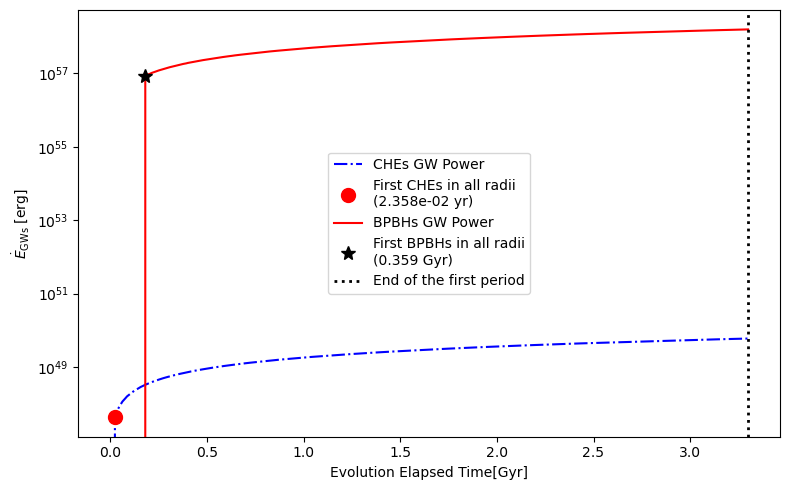

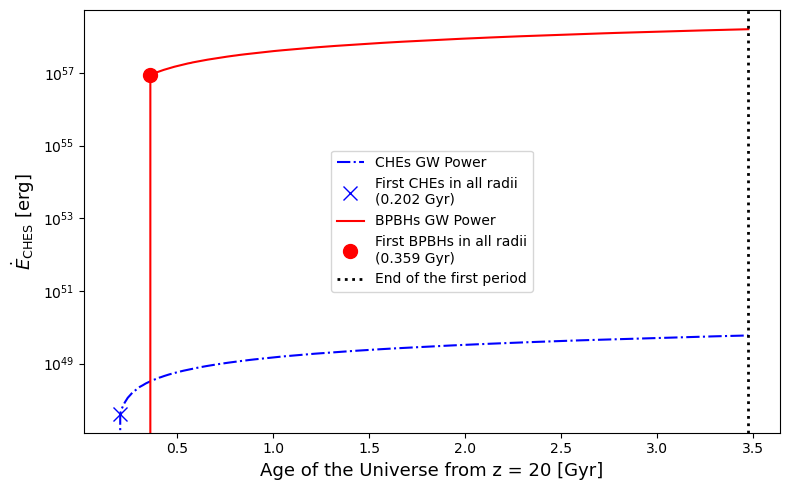

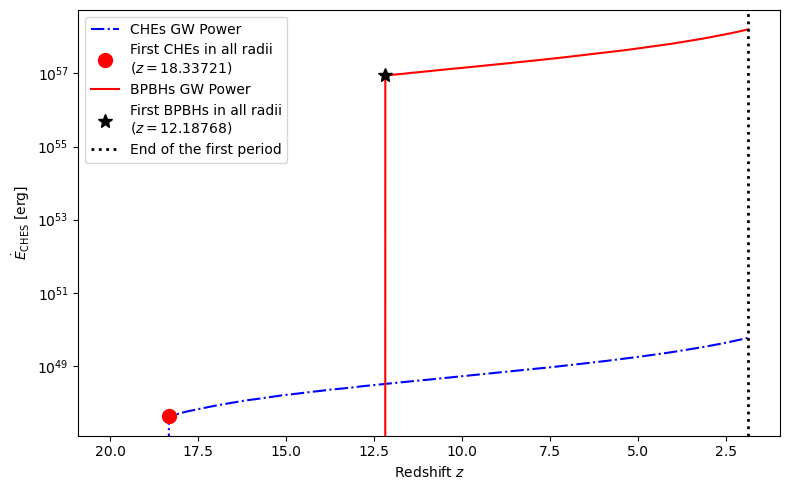

In [20]:
# Recupera los valores críticos
critical_time_yr = time_values_interval[idx_first_all]        # años
critical_time_gyr = critical_time_yr / 1e9                   # Gyr
critical_redshift = redshift_evaluated_0[idx_first_all]
critical_Edot = E_dot_CHES_0[idx_first_all]
critical_abs_age_gyr = (time_z_20 + time_values_interval[idx_first_all]) / 1e9

critical_merger_gyr = time_values_interval[first_bbh_idx]/1e9
critical_merger_redshift = redshift_evaluated_0[first_bbh_idx]
critical_merger_Edot = E_dot_BBH_0[first_bbh_idx]
critical_merger_age_gyr = (time_z_20 + time_values_interval[first_bbh_idx]) / 1e9

# --- vs tiempo evolution (en Gyr) ---
plt.figure(figsize=(8,5))
plt.plot(time_values_interval/1e9, E_dot_CHES_0, color='blue', linestyle = '-.', label='CHEs GW Power')
plt.plot(critical_time_gyr, critical_Edot, 'o', color='red', markersize=10, label=f'First CHEs in all radii\n({critical_time_yr/1e9:.3e} yr)')
plt.plot(time_values_interval/1e9, E_dot_BBH_0, color='red', label='BPBHs GW Power')
plt.plot(critical_merger_gyr, critical_merger_Edot, '*', color='black', markersize=10, label=f'First BPBHs in all radii\n({critical_merger_age_gyr:.3f} Gyr)')
plt.axvline(time_period_1_Gyr, color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Evolution Elapsed Time[Gyr]')
plt.ylabel(r'$\dot{E}_{\mathrm{GWs}}$ [erg]')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_time_evolution.pdf')
plt.show()

# --- vs edad absoluta (en Gyr) ---
plt.figure(figsize=(8,5))
plt.plot((time_z_20+time_values_interval)/1e9, E_dot_CHES_0, color='blue', linestyle = '-.', label='CHEs GW Power')
#plt.axvline(critical_abs_age_gyr, color='red', ls='--', lw=2,
#            label=f'First CHEs in all radii\n({critical_abs_age_gyr:.3f} Gyr)')
plt.plot(critical_abs_age_gyr, critical_Edot, 'x', color='blue', markersize=10, label=f'First CHEs in all radii\n({critical_abs_age_gyr:.3f} Gyr)')
plt.plot((time_z_20+time_values_interval)/1e9, E_dot_BBH_0, color='red', label='BPBHs GW Power')
plt.plot(critical_merger_age_gyr, critical_merger_Edot, 'o', color='red', markersize=10, label=f'First BPBHs in all radii\n({critical_merger_age_gyr:.3f} Gyr)')
plt.axvline(((time_z_20+time_values_interval)/1e9)[-1], color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Age of the Universe from z = 20 [Gyr]', fontsize=13)
plt.ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg]', fontsize=13)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_absolute_age.pdf')
plt.show()

# --- vs redshift ---
plt.figure(figsize=(8,5))
plt.plot(redshift_evaluated_0, E_dot_CHES_0, color='blue', linestyle = '-.',label='CHEs GW Power')
plt.plot(critical_redshift, critical_Edot, 'o', color='red', markersize=10, label=f'First CHEs in all radii\n($z={critical_redshift:.5f}$)')
plt.plot(redshift_evaluated_0, E_dot_BBH_0, color='red', label='BPBHs GW Power')
plt.plot(critical_merger_redshift, critical_merger_Edot, '*', color='black', markersize=10, label=f'First BPBHs in all radii\n($z={critical_merger_redshift:.5f}$)')
plt.axvline(redshift_evaluated_0[-1], color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Redshift $z$')
plt.ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg]')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_redshift.pdf')
plt.show()

# Second Generation

In [21]:
#N_PBH_1G = np.sum(N_BPBH_0G) #PBHs de primera generación obtenidos de la población original N_BPBH_0G desde el primer merger
N_PBH_1G = np.sum(N_BBH)#Entonces N_BBH es el array de BPBHs despues del primer periodo

M_PBH_1G = final_masses 
M_PBH_0G = M_PBH 
M_1G = N_PBH_1G * M_PBH_1G 
N_PBH_0G = n_total - (2*N_PBH_1G)
M_tot_0G = N_PBH_0G*M_PBH #masa total de los PBHs_0G que contribuyen a la masa total del cluster
M_DM_c_1G = M_tot_0G + M_1G #masa total del cluster para la 1G
M_LOST_GW = M_DM_cluster - M_DM_c_1G #cantidad de masa perdida por emisión de ondas gravitacionales de binarias
percent_lost_GW = (M_LOST_GW / M_DM_cluster) * 100

print(f"Number of PBHs of initial generation: {N_PBH_0G:.0f} of {M_PBH_0G:.2f} Solar Mass")
print(f"Number of PBHs of 1st generation:     {N_PBH_1G:.0f} of {M_PBH_1G:.2f} Solar Mass")
print(f"Cluster Mass after 1st generation:    {M_DM_c_1G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW:.4f} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW:.1f}%")

Number of PBHs of initial generation: 2868 of 10.00 Solar Mass
Number of PBHs of 1st generation:     3566 of 17.50 Solar Mass
Cluster Mass after 1st generation:    9.1085e+04 Solar Mass
Mass lost by GWs (BPBH mergers):       8914.8240 Solar Mass
Percentage of Cluster Mass Lost by GWs: 8.9%


In [22]:
M_DM_cluster = M_DM_c_1G
N_0G = n_PBH_r - (2 * N_BBH)     # PBHs remanentes de 0G por cascarón
N_1G = N_BBH                     # PBHs 1G por cascarón

# --- Definir las especies con sus arrays de número por cascarón ---
especies = [
    {"name": "0G", "N_array": N_0G, "M": M_PBH},
    {"name": "1G", "N_array": N_1G, "M": final_masses}
]

# --- Acumuladores ---
E_dot_BBH_dict = {}
E_dot_CHES_dict = {}
M_dict = {}
N_coll_BPBH_dict = {}
N_coll_CHES_dict = {}
resultados_discretos = []

delta_t_local = 2.3e9  # años

# --- Generar combinaciones (0G–0G, 0G–1G, 1G–1G) ---
combinaciones_preparadas = []
for sp_i, sp_j in combinations_with_replacement(especies, 2):
    nombre_i, N_i_array, M_i = sp_i["name"], sp_i["N_array"], sp_i["M"]
    nombre_j, N_j_array, M_j = sp_j["name"], sp_j["N_array"], sp_j["M"]

    Ni_eff = np.round(N_i_array / 2) if nombre_i == nombre_j else N_i_array.copy()
    Nj_eff = np.round(N_j_array / 2) if nombre_i == nombre_j else N_j_array.copy()

    combinaciones_preparadas.append((nombre_i, nombre_j, Ni_eff, M_i, Nj_eff, M_j))

for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc
    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

    # --- Secciones eficaces ---
    sigma_B = np.array([
        sigma_BPBH(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_BPBH(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])
    sigma_C = np.array([
        sigma_CHES(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_CHES(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])

    # --- Integral I y tasas Gamma ---
    I_vals = np.array([
        I_rj(r_values_pc[j], np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)
        for j in range(len(r_values_pc))
    ])
    coeffs_ij = np.polyfit(r_values_pc, I_vals, 3)

    Gamma_values_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_B[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_C[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])

    # --- Resto del bloque original ---
    mergers_total = Gamma_values_yr * age_universe_yr
    time_first_merger_yr = 1 / Gamma_values_yr
    time_first_merger_Gyr = time_first_merger_yr / 1e9

    delta_t_local = 2.3e9
    time_period_2_yr = delta_t_local

    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.where(Prob_form * N_i_array > 0.95,
                          np.round(Prob_form * N_i_array), 0.0)

    E_BBH_event = E_rad_GW(M_i, M_j)
    E_dot_BBH = N_coll_BBH * E_BBH_event
    M_result = final_mass_GW(M_i, M_j)
    M_dict[f"{nombre_i}-{nombre_j}"] = M_result

    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)
    E_CHES_event = E_rad_CHES(M_i, M_j)
    E_dot_CHES = N_coll_CHES * E_CHES_event

    # --- Impresión de resultados ---
    print(f"Masses interacting")
    print(f"M_PBH_{nombre_i}: {M_i:.2f}")
    print(f"M_PBH_{nombre_j}: {M_j:.2f}")
    print(f"Mass_final_from_{nombre_i}-{nombre_j}: {M_dict[f'{nombre_i}-{nombre_j}']:.2f}")
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'T_1st merge (Gyr)':<20}{'N_BBH':<10}{'N_CHES':<10}")
    print("=" * 80)
    for i in range(len(r_values_pc)):
        print(f"{r_values_pc[i]:<10.2f}"
              f"{Gamma_values_yr[i]:<15.3e}"
              f"{Gamma_CHES_yr[i]:<17.3e}"
              f"{time_first_merger_Gyr[i]:<20.3e}"
              f"{N_coll_BBH[i]:<10.1f}"
              f"{N_coll_CHES[i]:.1f}")

    # --- Guardar resultados ---
    N_coll_BPBH_dict[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict[f"{nombre_i}-{nombre_j}"] = E_dot_CHES

    print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    print(f"Total BBH events = {int(np.sum(N_coll_BBH))}")
    print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    print(f"P_BBH radiated = {np.sum(E_dot_BBH):.2e} erg")
    print(f"P_CHES radiated = {np.sum(E_dot_CHES):.2e} erg")

    resultados_discretos.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES,
        "E_event_BBH": E_BBH_event,
        "E_event_CHES": E_CHES_event,
        "E_dot_BBH": E_dot_BBH,
        "E_dot_CHES": E_dot_CHES,
        "sigma_BBH": sigma_B,
        "sigma_CHES": sigma_C
    })



Evaluando interacción 0G-0G...
Masses interacting
M_PBH_0G: 10.00
M_PBH_0G: 10.00
Mass_final_from_0G-0G: 17.50

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      4.690e-11      5.388e-10        2.132e+01           1.0       16.0
0.21      4.403e-11      5.059e-10        2.271e+01           6.0       72.0
0.32      3.969e-11      4.560e-10        2.520e+01           11.0      128.0
0.43      3.452e-11      3.967e-10        2.897e+01           14.0      159.0
0.54      2.917e-11      3.352e-10        3.428e+01           14.0      157.0
0.65      2.411e-11      2.770e-10        4.148e+01           12.0      133.0
0.76      1.960e-11      2.252e-10        5.102e+01           9.0       103.0
0.87      1.576e-11      1.811e-10        6.343e+01           6.0       73.0
0.99      1.260e-11      1.448e-10        7.936e+01           4.0       50.0
1.10      1.004e-11      1.154e-10        9.956e+01           3.0       33.0

[Resumen 0G-0G]
Total BBH ev

In [23]:
for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc

        # Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, v in zip(r_values_pc, v_mean_values):
            print(f"{r:<10.3f}{v:<20.3e}{v:<20.3e}")

    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

        # Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, vi, vj in zip(r_values_pc, v_i_array, v_j_array):
            print(f"{r:<10.3f}{(vi/km_to_pc):<20.3e}{(vj/km_to_pc):<20.3e}")



Evaluando interacción 0G-0G...

r_j (pc)  v_0G (km/s)         v_0G (km/s)         
0.100     7.486e+00           7.486e+00           
0.211     7.434e+00           7.434e+00           
0.321     7.348e+00           7.348e+00           
0.432     7.235e+00           7.235e+00           
0.543     7.101e+00           7.101e+00           
0.653     6.952e+00           6.952e+00           
0.764     6.794e+00           6.794e+00           
0.875     6.632e+00           6.632e+00           
0.985     6.469e+00           6.469e+00           
1.096     6.308e+00           6.308e+00           

Evaluando interacción 0G-1G...

r_j (pc)  v_0G (km/s)         v_1G (km/s)         
0.100     7.486e+00           1.104e+01           
0.211     7.434e+00           1.097e+01           
0.321     7.348e+00           1.084e+01           
0.432     7.235e+00           1.067e+01           
0.543     7.101e+00           1.048e+01           
0.653     6.952e+00           1.026e+01           
0.764     6.794e

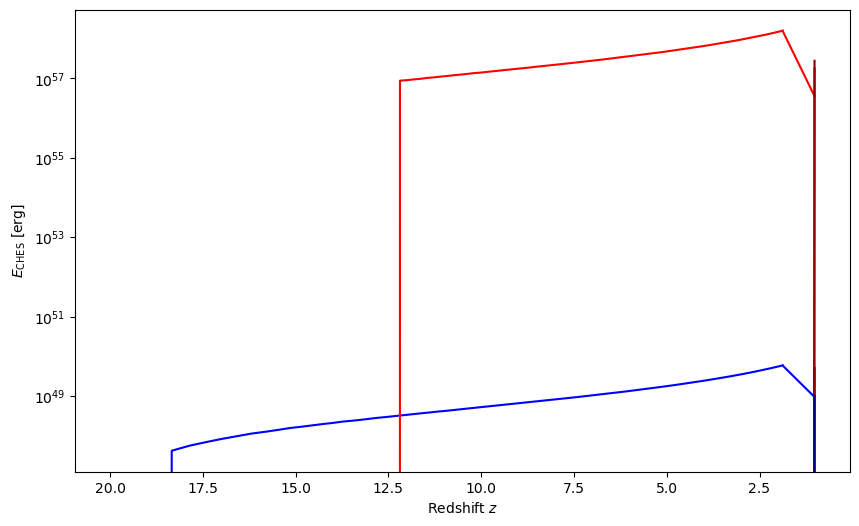

In [24]:
# --- Preparación de variables para graficar ---
time_period_2_yr = delta_t_local
time_period_2_Gyr = time_period_2_yr / 1e9
time_period_2_seconds = (((time_period_2_yr * 1e9) * u.yr).to(u.s)).value

POPULATION_BPBH_BY_GENERATION = [N_BBH_tot, np.sum(N_coll_BPBH_dict['0G-0G'])]
EMISSION_GW_OF_BPBH = [
    E_dot_BBH_shell_tot,
    np.sum(E_dot_BBH_dict['0G-0G'])
]
NUMBER_OF_CHES_BY_GENERATION = [N_CHES_tot, np.sum(N_coll_CHES_dict['0G-0G'])]
EMISSION_GW_OF_CHES = [
    E_dot_CHES_shell_tot,
    np.sum(E_dot_CHES_dict['0G-0G'])
]
PERIOD_OF_EVOLUTION_GYR = [time_period_1_Gyr, time_period_2_Gyr]

t_2nd_gyr = ((((time_period_1_Gyr + time_period_2_Gyr) * u.Gyr).to(u.yr)).value + time_z_20) / 1e9
redshift_evaluated_1 = z_at_value(cosmo.age, t_2nd_gyr * u.Gyr, zmax=25).value
Z_PERIOD_tot = [redshift_evaluated_0[-1], redshift_evaluated_1]

POPULATION_BPBH_0G1G = [0, np.sum(N_coll_BPBH_dict['0G-1G'])]
EMISSION_GW_BPBH_0G1G = [0, np.sum(E_dot_BBH_dict['0G-1G'])]
NUMBER_OF_CHES_0G1G = [0, np.sum(N_coll_CHES_dict['0G-1G'])]
EMISSION_GW_CHES_0G1G = [0, np.sum(E_dot_CHES_dict['0G-1G'])]

POPULATION_BPBH_1G1G = [0, np.sum(N_coll_BPBH_dict['1G-1G'])]
EMISSION_GW_BPBH_1G1G = [0, np.sum(E_dot_BBH_dict['1G-1G'])]
NUMBER_OF_CHES_1G1G = [0, np.sum(N_coll_CHES_dict['1G-1G'])]
EMISSION_GW_CHES_1G1G = [0, np.sum(E_dot_CHES_dict['1G-1G'])]

# --- Graficado ---
plt.figure(figsize=(10, 6))

# Periodo inicial
plt.plot(redshift_evaluated_0, E_dot_CHES_0, color='blue')
plt.plot(redshift_evaluated_0, E_dot_BBH_0, color='red')

# Corte entre periodos
plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_CHES, color='blue')
plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_BPBH, color='red')

# Segunda generación
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_0G1G, color='darkred')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_0G1G, color='darkblue')
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G1G, color='darkred')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G1G, color='darkblue')

# Ajustes de eje
plt.gca().invert_xaxis()
#plt.xlim([1.2, 0])
#plt.ylim([1e31, 1e33])
plt.xlabel('Redshift $z$')
plt.ylabel(r'${E}_{\mathrm{CHES}}$ [erg]')
plt.yscale('log')  # Descomentar si quieres escala logarítmica
plt.show()


In [25]:
# =============================
# --- Preparación Tercera Generación ---
# =============================

# Masas por generación previa
M_0G = M_PBH_0G  # masa original
M_1G = resultados_discretos[0]['Mass_final']  # 0G–0G → 1G
M_2G_a = resultados_discretos[1]['Mass_final']  # 0G–1G → 2G_a
M_2G_b = resultados_discretos[2]['Mass_final']  # 1G–1G → 2G_b

# Número de PBHs fusionados en segunda generación
N_2G_a = resultados_discretos[1]['N_collisions_BBH']
N_2G_b = resultados_discretos[2]['N_collisions_BBH']

# Número de PBHs después de segunda generación
N_0G_second = N_0G - (2 * resultados_discretos[0]['N_collisions_BBH'] + N_2G_a)
N_1G_second = (N_1G - (N_2G_a + 2 * N_2G_b)) + resultados_discretos[0]['N_collisions_BBH']

# Masa total del cúmulo tras segunda generación
M_DM_c_2G = (
    np.sum(N_0G_second) * M_0G
    + np.sum(N_1G_second) * M_1G
    + np.sum(N_2G_a) * M_2G_a
    + np.sum(N_2G_b) * M_2G_b
)

# Masa perdida en GWs
M_LOST_GW_2G = M_DM_cluster - M_DM_c_2G
percent_lost_GW_2G = (M_LOST_GW_2G / M_DM_cluster) * 100

# --- Mostrar resultados ---
print(f"Number of PBHs of initial generation: {np.sum(N_0G_second)} of {M_0G:.2f} Solar Mass")
print(f"Number of BHs of 1st generation:     {np.sum(N_1G_second)} of {M_1G:.2f} Solar Mass")
print(f"Number of BHs of 2nd generation_a:   {np.sum(N_2G_a)} of {M_2G_a:.2f} Solar Mass")
print(f"Number of BHs of 2nd generation_b:   {np.sum(N_2G_b)} of {M_2G_b:.2f} Solar Mass")
print(f"Cluster Mass after 2nd generation:    {M_DM_c_2G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW_2G:.4e} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW_2G:.1f}%")


# ==================================================
# --- Evaluación de tercera generación (solo restar fusiones + impresión) ---
# ==================================================

M_DM_cluster = M_DM_c_2G

# Definición inicial de especies (diccionario para actualización dinámica)
POBLACION_3G = {
    "0G":   N_0G_second.copy(),
    "1G":   N_1G_second.copy(),
    "2G_a": N_2G_a.copy(),
    "2G_b": N_2G_b.copy(),
}

MASAS_3G = {
    "0G":   M_0G,
    "1G":   M_1G,
    "2G_a": M_2G_a,
    "2G_b": M_2G_b,
}

factor_misma_especie = 0.5  # aquí puedes poner 0.5 o 0.10 según el caso

combinaciones_preparadas_3 = []
for sp_i, sp_j in combinations_with_replacement(list(POBLACION_3G.keys()), 2):
    N_i_eff = np.round(POBLACION_3G[sp_i] * factor_misma_especie) if sp_i == sp_j else POBLACION_3G[sp_i].copy()
    N_j_eff = np.round(POBLACION_3G[sp_j] * factor_misma_especie) if sp_i == sp_j else POBLACION_3G[sp_j].copy()

    combinaciones_preparadas_3.append((
        sp_i, N_i_eff, MASAS_3G[sp_i],
        sp_j, N_j_eff, MASAS_3G[sp_j]
    ))

# Diccionarios y resultados
resultados_discretos_3rd = []
E_dot_BBH_dict_3 = {}
E_dot_CHES_dict_3 = {}
M_dict_3 = {}
N_coll_BPBH_dict_3 = {}
N_coll_CHES_dict_3 = {}

# Evaluación
for nombre_i, N_i_array, M_i, nombre_j, N_j_array, M_j in combinaciones_preparadas_3:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    if np.sum(N_i_array) == 0 or np.sum(N_j_array) == 0:
        print(f"Saltando {nombre_i}-{nombre_j} (sin PBHs en al menos una especie)")
        continue

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc
    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

    # --- Secciones eficaces ---
    sigma_B = np.array([
        sigma_BPBH(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_BPBH(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])
    sigma_C = np.array([
        sigma_CHES(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_CHES(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])

    # --- Integral I y tasas ---
    I_vals = np.array([
        I_rj(r_values_pc[j], np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)
        for j in range(len(r_values_pc))
    ])
    coeffs_ij = np.polyfit(r_values_pc, I_vals, 3)

    Gamma_values_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_B[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_C[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])

    # --- Colisiones ---
    delta_t_local = 2.3e9
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.where(Prob_form * N_i_array > 0.95,
                          np.round(Prob_form * N_i_array), 0.0)
    E_BBH_event = E_rad_GW(M_i, M_j)
    E_dot_BBH = N_coll_BBH * E_BBH_event
    M_result = final_mass_GW(M_i, M_j)

    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)
    E_CHES_event = E_rad_CHES(M_i, M_j)
    E_dot_CHES = N_coll_CHES * E_CHES_event
    
    # --- Impresión de tabla ---
    print(f"\nMasses interacting")
    print(f"M_PBH_{nombre_i}: {M_i:.2f}")
    print(f"M_PBH_{nombre_j}: {M_j:.2f}")
    print(f"Mass_final_from_{nombre_i}-{nombre_j}: {M_result:.2f}")
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'T_1st merge (Gyr)':<20}{'N_BBH':<10}{'N_CHES':<10}")
    print("=" * 80)
    for idx in range(len(r_values_pc)):
        t_merge = (1/Gamma_values_yr[idx])/1e9 if Gamma_values_yr[idx] > 0 else float('inf')
        print(f"{r_values_pc[idx]:<10.2f}"
              f"{Gamma_values_yr[idx]:<15.3e}"
              f"{Gamma_CHES_yr[idx]:<17.3e}"
              f"{t_merge:<20.3e}"
              f"{N_coll_BBH[idx]:<10.1f}"
              f"{N_coll_CHES[idx]:.1f}")

    # Guardar resultados
    N_coll_BPBH_dict_3[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict_3[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict_3[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict_3[f"{nombre_i}-{nombre_j}"] = E_dot_CHES
    M_dict_3[f"{nombre_i}-{nombre_j}"] = M_result
    
    print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    print(f"Total BBH events = {int(np.sum(N_coll_BBH))}")
    print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    print(f"P_BBH radiated = {np.sum(E_dot_BBH):.2e} erg")
    print(f"P_CHES radiated = {np.sum(E_dot_CHES):.2e} erg")

    resultados_discretos_3rd.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES
    })

    # --- Actualizar inventario ---
    POBLACION_3G[nombre_i] -= N_coll_BBH
    if nombre_i != nombre_j:
        POBLACION_3G[nombre_j] -= N_coll_BBH

    # Sumar nuevas fusiones a la generación resultante
    if nombre_i == nombre_j:
        if nombre_i == "0G":
            POBLACION_3G["1G"] += np.sum(N_coll_BBH)
        elif nombre_i == "1G":
            POBLACION_3G["2G_a"] += np.sum(N_coll_BBH)
        elif nombre_i.startswith("2G"):
            # Aquí irían las reglas para 3G
            pass

    # Evitar negativos
    for k in POBLACION_3G:
        POBLACION_3G[k] = np.clip(POBLACION_3G[k], 0, None)
    # --- Mostrar inventario actualizado ---
    print(f"[Inventario actualizado tras {nombre_i}-{nombre_j}]:")
    for especie, arr in POBLACION_3G.items():
        print(f"{especie}: {int(np.sum(arr))} PBHs")


Number of PBHs of initial generation: 2082.0 of 10.00 Solar Mass
Number of BHs of 1st generation:     2564.0 of 17.50 Solar Mass
Number of BHs of 2nd generation_a:   626.0 of 25.00 Solar Mass
Number of BHs of 2nd generation_b:   228.0 of 30.63 Solar Mass
Cluster Mass after 2nd generation:    8.8323e+04 Solar Mass
Mass lost by GWs (BPBH mergers):       2.7624e+03 Solar Mass
Percentage of Cluster Mass Lost by GWs: 3.0%

Evaluando interacción 0G-0G...

Masses interacting
M_PBH_0G: 10.00
M_PBH_0G: 10.00
Mass_final_from_0G-0G: 17.50

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      3.755e-11      8.203e-10        2.663e+01           0.0       13.0
0.21      3.526e-11      7.702e-10        2.836e+01           3.0       57.0
0.32      3.178e-11      6.942e-10        3.147e+01           5.0       112.0
0.43      2.764e-11      6.039e-10        3.617e+01           7.0       149.0
0.54      2.336e-11      5.103e-10        4.281e+01           7.0       


Masses interacting
M_PBH_2G_a: 25.00
M_PBH_2G_b: 30.63
Mass_final_from_2G_a-2G_b: 49.38

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      5.547e-10      8.638e-09        1.803e+00           13.0      199.0
0.21      5.159e-10      8.115e-09        1.938e+00           56.0      877.0
0.32      4.582e-10      7.326e-09        2.183e+00           89.0      1415.0
0.43      3.909e-10      6.390e-09        2.558e+00           94.0      1543.0
0.54      3.228e-10      5.420e-09        3.098e+00           78.0      1309.0
0.65      2.598e-10      4.497e-09        3.849e+00           54.0      941.0
0.76      2.054e-10      3.673e-09        4.869e+00           34.0      600.0
0.87      1.604e-10      2.969e-09        6.235e+00           19.0      355.0
0.99      1.244e-10      2.387e-09        8.036e+00           10.0      198.0
1.10      9.639e-11      1.917e-09        1.038e+01           6.0       110.0

[Resumen 2G_a-2G_b]
Total BBH events = 453


In [26]:
# --- Evaluación ---
for nombre_i, N_i_array, M_i, nombre_j, N_j_array, M_j in combinaciones_preparadas_3:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    if np.sum(N_i_array) == 0 or np.sum(N_j_array) == 0:
        print(f"Saltando {nombre_i}-{nombre_j} (sin PBHs en al menos una especie)")
        continue

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc

        # 📌 Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, v in zip(r_values_pc, v_mean_values):
            print(f"{r:<10.3f}{v:<20.3e}{v:<20.3e}")

    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

        # 📌 Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, vi, vj in zip(r_values_pc, v_i_array, v_j_array):
            print(f"{r:<10.3f}{(vi/km_to_pc):<20.3e}{(vj/km_to_pc):<20.3e}")


Evaluando interacción 0G-0G...

r_j (pc)  v_0G (km/s)         v_0G (km/s)         
0.100     6.375e+00           6.375e+00           
0.211     6.331e+00           6.331e+00           
0.321     6.258e+00           6.258e+00           
0.432     6.162e+00           6.162e+00           
0.543     6.048e+00           6.048e+00           
0.653     5.921e+00           5.921e+00           
0.764     5.786e+00           5.786e+00           
0.875     5.648e+00           5.648e+00           
0.985     5.509e+00           5.509e+00           
1.096     5.372e+00           5.372e+00           

Evaluando interacción 0G-1G...

r_j (pc)  v_0G (km/s)         v_1G (km/s)         
0.100     6.378e+00           9.363e+00           
0.211     6.334e+00           9.298e+00           
0.321     6.261e+00           9.191e+00           
0.432     6.165e+00           9.050e+00           
0.543     6.050e+00           8.882e+00           
0.653     5.924e+00           8.696e+00           
0.764     5.789e

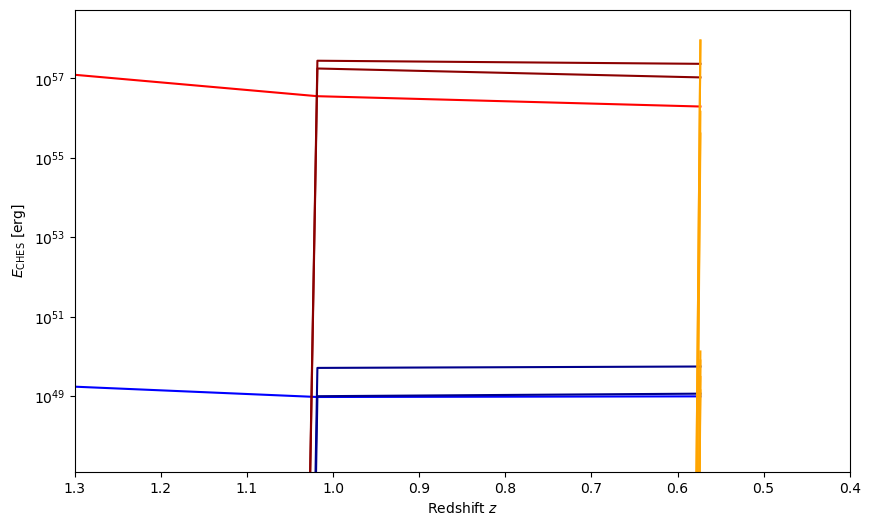

In [27]:
# --- Preparación de variables para graficar (3ª generación) ---
time_period_3_yr = delta_t_local
time_period_3_Gyr = time_period_3_yr / 1e9

POPULATION_BPBH_BY_GENERATION = [
    N_BBH_tot,
    np.sum(N_coll_BPBH_dict.get('0G-0G', 0)),
    np.sum(N_coll_BPBH_dict_3.get('0G-0G', 0))
]
EMISSION_GW_OF_BPBH = [
    E_dot_BBH_shell_tot,
    np.sum(E_dot_BBH_dict.get('0G-0G', 0)),
    np.sum(E_dot_BBH_dict_3.get('0G-0G', 0))
]


NUMBER_OF_CHES_BY_GENERATION = [
    N_CHES_tot,
    np.sum(N_coll_CHES_dict.get('0G-0G', 0)),
    np.sum(N_coll_CHES_dict_3.get('0G-0G', 0))
]
EMISSION_GW_OF_CHES = [
    E_dot_CHES_shell_tot,
    np.sum(E_dot_CHES_dict.get('0G-0G', 0)),
    np.sum(E_dot_CHES_dict_3.get('0G-0G', 0))
]
PERIOD_OF_EVOLUTION_GYR = [
    time_period_1_Gyr,
    time_period_2_Gyr,
    time_period_3_Gyr
]

# --- Redshift del final de la 3ª generación ---
t_3rd_gyr = (
    (((time_period_1_Gyr + time_period_2_Gyr + time_period_3_Gyr) * u.Gyr).to(u.yr)).value
    + time_z_20
) / 1e9
redshift_evaluated_2 = z_at_value(cosmo.age, t_3rd_gyr * u.Gyr, zmax=25).value
Z_PERIOD_tot = [
    redshift_evaluated_0[-1],
    redshift_evaluated_1,
    redshift_evaluated_2
]

# --- Combinaciones de la tercera generación ---
POPULATION_BPBH_0G1G = [0, np.sum(N_coll_BPBH_dict.get('0G-1G', 0)), np.sum(N_coll_BPBH_dict_3.get('0G-1G', 0))]
EMISSION_GW_BPBH_0G1G = [0, np.sum(E_dot_BBH_dict.get('0G-1G', 0)), np.sum(E_dot_BBH_dict_3.get('0G-1G', 0))]
NUMBER_OF_CHES_0G1G = [0, np.sum(N_coll_CHES_dict.get('0G-1G', 0)), np.sum(N_coll_CHES_dict_3.get('0G-1G', 0))]
EMISSION_GW_CHES_0G1G = [0, np.sum(E_dot_CHES_dict.get('0G-1G', 0)), np.sum(E_dot_CHES_dict_3.get('0G-1G', 0))]

POPULATION_BPBH_1G1G = [0, np.sum(N_coll_BPBH_dict.get('1G-1G', 0)), np.sum(N_coll_BPBH_dict_3.get('1G-1G', 0))]
EMISSION_GW_BPBH_1G1G = [0, np.sum(E_dot_BBH_dict.get('1G-1G', 0)), np.sum(E_dot_BBH_dict_3.get('1G-1G', 0))]
NUMBER_OF_CHES_1G1G = [0, np.sum(N_coll_CHES_dict.get('1G-1G', 0)), np.sum(N_coll_CHES_dict_3.get('1G-1G', 0))]
EMISSION_GW_CHES_1G1G = [0, np.sum(E_dot_CHES_dict.get('1G-1G', 0)), np.sum(E_dot_CHES_dict_3.get('1G-1G', 0))]

POPULATION_BPBH_1G2G_a = [0, 0, np.sum(N_coll_BPBH_dict_3.get('1G-2G_a', 0))]
EMISSION_GW_BPBH_1G2G_a = [0, 0, np.sum(E_dot_BBH_dict_3.get('1G-2G_a', 0))]
NUMBER_OF_CHES_1G2G_a = [0, 0, np.sum(N_coll_CHES_dict_3.get('1G-2G_a', 0))]
EMISSION_GW_CHES_1G2G_a = [0, 0, np.sum(E_dot_CHES_dict_3.get('1G-2G_a', 0))]

POPULATION_BPBH_1G2G_b = [0, 0, np.sum(N_coll_BPBH_dict_3.get('1G-2G_b', 0))]
EMISSION_GW_BPBH_1G2G_b = [0, 0, np.sum(E_dot_BBH_dict_3.get('1G-2G_b', 0))]
NUMBER_OF_CHES_1G2G_b = [0, 0, np.sum(N_coll_CHES_dict_3.get('1G-2G_b', 0))]
EMISSION_GW_CHES_1G2G_b = [0, 0, np.sum(E_dot_CHES_dict_3.get('1G-2G_b', 0))]

POPULATION_BPBH_2G_a2G_a = [0, 0, np.sum(N_coll_BPBH_dict_3.get('2G_a-2G_a', 0))]
EMISSION_GW_BPBH_2G_a2G_a = [0, 0, np.sum(E_dot_BBH_dict_3.get('2G_a-2G_a', 0))]
NUMBER_OF_CHES_2G_a2G_a = [0, 0, np.sum(N_coll_CHES_dict_3.get('2G_a-2G_a', 0))]
EMISSION_GW_CHES_2G_a2G_a = [0, 0, np.sum(E_dot_CHES_dict_3.get('2G_a-2G_a', 0))]

POPULATION_BPBH_2G_b2G_b = [0, 0, np.sum(N_coll_BPBH_dict_3.get('2G_b-2G_b', 0))]
EMISSION_GW_BPBH_2G_b2G_b = [0, 0, np.sum(E_dot_BBH_dict_3.get('2G_b-2G_b', 0))]
NUMBER_OF_CHES_2G_b2G_b = [0, 0, np.sum(N_coll_CHES_dict_3.get('2G_b-2G_b', 0))]
EMISSION_GW_CHES_2G_b2G_b = [0, 0, np.sum(E_dot_CHES_dict_3.get('2G_b-2G_b', 0))]

# --- Graficado ---
plt.figure(figsize=(10, 6))

# Periodo inicial
plt.plot(redshift_evaluated_0, E_dot_CHES_0, color='blue')
plt.plot(redshift_evaluated_0, E_dot_BBH_0, color='red')

# Corte entre periodos
plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_CHES, color='blue')
plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_BPBH, color='red')

# Segunda generación
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_0G1G, color='darkred')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_0G1G, color='darkblue')
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G1G, color='darkred')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G1G, color='darkblue')

# Tercera generación
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G2G_a, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G2G_a, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G2G_b, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G2G_b, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_2G_a2G_a, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_2G_a2G_a, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_2G_b2G_b, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_2G_b2G_b, color='orange')

# Ajustes de eje
plt.gca().invert_xaxis()
plt.xlabel('Redshift $z$')
plt.ylabel(r'${E}_{\mathrm{CHES}}$ [erg]')
plt.xlim([1.3,0.4])
plt.yscale('log')
plt.show()


In [28]:
# =============================
# --- Preparación Cuarta Generación ---
# =============================

# Masas por generación previa (incluye las generadas en 3G)
M_0G   = MASAS_3G["0G"]
M_1G   = MASAS_3G["1G"]
M_2G_a = MASAS_3G["2G_a"]
M_2G_b = MASAS_3G["2G_b"]

# Asignar las masas de las nuevas especies formadas en 3G
M_3G_a = resultados_discretos_3rd[3]['Mass_final']
M_3G_b = resultados_discretos_3rd[4]['Mass_final']
M_3G_c = resultados_discretos_3rd[5]['Mass_final']

N_3G_a = resultados_discretos_3rd[3]['N_collisions_BBH']
N_3G_b = resultados_discretos_3rd[4]['N_collisions_BBH']
N_3G_c = resultados_discretos_3rd[5]['N_collisions_BBH']

N_0G_third   = np.round(POBLACION_3G["0G"])
N_1G_third   = np.round(POBLACION_3G["1G"])
N_2G_a_third = np.round(0.10 * POBLACION_3G["2G_a"])
N_2G_b_third = np.round(0.10 * POBLACION_3G["2G_b"])

N_3G_a_third = np.round(0.10 * N_3G_a)
N_3G_b_third = np.round(0.10 * N_3G_b)
N_3G_c_third = np.round(0.10 * N_3G_c)

# Masa total del cúmulo tras 3G (solo con el 10% de cada población)
M_DM_c_3G = (
    np.sum(N_0G_third)   * M_0G +
    np.sum(N_1G_third)   * M_1G +
    np.sum(N_2G_a_third) * M_2G_a +
    np.sum(N_2G_b_third) * M_2G_b +
    np.sum(N_3G_a_third) * M_3G_a +
    np.sum(N_3G_b_third) * M_3G_b +
    np.sum(N_3G_c_third) * M_3G_c
)

# Masa perdida por GWs en 3G
M_LOST_GW_3G = 1e5 - M_DM_c_3G
percent_lost_GW_3G = (M_DM_c_3G / 1e5) * 100

# --- Mostrar resultados antes de evaluar 4G ---
print(f"Number of PBHs of initial generation: {np.sum(N_0G_third)} of {M_0G:.2f} Solar Mass")
print(f"Number of BHs of 1st generation:     {np.sum(N_1G_third)} of {M_1G:.2f} Solar Mass")
print(f"Number of BHs of 2nd generation_a:   {np.sum(N_2G_a_third)} of {M_2G_a:.2f} Solar Mass")
print(f"Number of BHs of 2nd generation_b:   {np.sum(N_2G_b_third)} of {M_2G_b:.2f} Solar Mass")
print(f"Number of BHs of 3rd generation_a:   {np.sum(N_3G_a_third)} of {M_3G_a:.2f} Solar Mass")
print(f"Number of BHs of 3rd generation_b:   {np.sum(N_3G_b_third)} of {M_3G_b:.2f} Solar Mass")
print(f"Number of BHs of 3rd generation_c:   {np.sum(N_3G_c_third)} of {M_3G_c:.2f} Solar Mass")
print(f"Cluster Mass after 3rd generation:    {M_DM_c_3G:.4e} Solar Mass")
#print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW_3G:.4e} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW_3G:.1f}%")

# Actualizar M_DM_cluster para la evaluación de 4G
M_DM_cluster = M_DM_c_3G


Number of PBHs of initial generation: 196.0 of 10.00 Solar Mass
Number of BHs of 1st generation:     145.0 of 17.50 Solar Mass
Number of BHs of 2nd generation_a:   50.0 of 25.00 Solar Mass
Number of BHs of 2nd generation_b:   0.0 of 30.63 Solar Mass
Number of BHs of 3rd generation_a:   113.0 of 38.13 Solar Mass
Number of BHs of 3rd generation_b:   14.0 of 30.63 Solar Mass
Number of BHs of 3rd generation_c:   115.0 of 38.13 Solar Mass
Cluster Mass after 3rd generation:    1.4869e+04 Solar Mass
Percentage of Cluster Mass Lost by GWs: 14.9%


In [29]:
# =============================
# --- Preparación Cuarta Generación ---
# =============================

POBLACION_4G = {sp: np.round(0.10 * N) for sp, N in POBLACION_3G.items()}
MASAS_4G = MASAS_3G.copy()

# Detectar nuevas masas y especies formadas en 3ª generación
for res in resultados_discretos_3rd:
    inter = res["interaccion"]
    m_final = res["Mass_final"]
    n_merge = np.round(0.10 * np.sum(res["N_collisions_BBH"]))  # 10% también aquí

    if inter not in MASAS_4G:
        MASAS_4G[inter] = m_final
        POBLACION_4G[inter] = np.zeros_like(r_values_pc)

    POBLACION_4G[inter] += n_merge

# Preparar combinaciones
combinaciones_preparadas_4 = []
for sp_i, sp_j in combinations_with_replacement(list(POBLACION_4G.keys()), 2):
    combinaciones_preparadas_4.append((
        sp_i, POBLACION_4G[sp_i], MASAS_4G[sp_i],
        sp_j, POBLACION_4G[sp_j], MASAS_4G[sp_j]
    ))

# Diccionarios y resultados
resultados_discretos_4th = []
E_dot_BBH_dict_4 = {}
E_dot_CHES_dict_4 = {}
M_dict_4 = {}
N_coll_BPBH_dict_4 = {}
N_coll_CHES_dict_4 = {}

# Evaluación
for nombre_i, N_i_array, M_i, nombre_j, N_j_array, M_j in combinaciones_preparadas_4:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    if np.sum(N_i_array) == 0 or np.sum(N_j_array) == 0:
        print(f"Saltando {nombre_i}-{nombre_j} (sin PBHs en al menos una especie)")
        continue

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc
    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

    # --- Secciones eficaces ---
    sigma_B = np.array([
        sigma_BPBH(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_BPBH(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])
    sigma_C = np.array([
        sigma_CHES(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_CHES(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])

    # --- Integral I y tasas ---
    I_vals = np.array([
        I_rj(r_values_pc[j], np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)
        for j in range(len(r_values_pc))
    ])
    coeffs_ij = np.polyfit(r_values_pc, I_vals, 3)

    Gamma_values_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_B[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_C[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])

    # --- Colisiones ---
    delta_t_local = 4.7e9
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.round(np.where(Prob_form * N_i_array > 0.9,
                                   Prob_form * N_i_array, 0.0))
    E_BBH_event = E_rad_GW(M_i, M_j)
    E_dot_BBH = N_coll_BBH * E_BBH_event
    M_result = final_mass_GW(M_i, M_j)

    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)
    E_CHES_event = E_rad_CHES(M_i, M_j)
    E_dot_CHES = N_coll_CHES * E_CHES_event

    # Guardar resultados
    N_coll_BPBH_dict_4[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict_4[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict_4[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict_4[f"{nombre_i}-{nombre_j}"] = E_dot_CHES
    M_dict_4[f"{nombre_i}-{nombre_j}"] = M_result

    resultados_discretos_4th.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES
    })

    # --- Actualizar inventario ---
    POBLACION_4G[nombre_i] -= N_coll_BBH
    if nombre_i != nombre_j:
        POBLACION_4G[nombre_j] -= N_coll_BBH

    # Sumar nuevas fusiones a especie resultante
    if nombre_i == nombre_j:
        new_sp_name = f"{nombre_i}-{nombre_j}"
        if new_sp_name not in POBLACION_4G:
            POBLACION_4G[new_sp_name] = np.zeros_like(r_values_pc)
            MASAS_4G[new_sp_name] = M_result
        POBLACION_4G[new_sp_name] += np.sum(N_coll_BBH)

    # Evitar negativos
    for k in POBLACION_4G:
        POBLACION_4G[k] = np.clip(POBLACION_4G[k], 0, None)

# --- Resultados finales 4G ---
print("\n\n=== Inventario final tras cuarta generación ===")
for sp in POBLACION_4G:
    print(f"{sp}: {int(np.sum(POBLACION_4G[sp]))} PBHs de {MASAS_4G[sp]:.2f} M_sun")



Evaluando interacción 0G-0G...

Evaluando interacción 0G-1G...

Evaluando interacción 0G-2G_a...

Evaluando interacción 0G-2G_b...
Saltando 0G-2G_b (sin PBHs en al menos una especie)

Evaluando interacción 0G-0G-0G...

Evaluando interacción 0G-0G-1G...

Evaluando interacción 0G-0G-2G_a...

Evaluando interacción 0G-0G-2G_b...

Evaluando interacción 0G-1G-1G...

Evaluando interacción 0G-1G-2G_a...

Evaluando interacción 0G-1G-2G_b...

Evaluando interacción 0G-2G_a-2G_a...

Evaluando interacción 0G-2G_a-2G_b...

Evaluando interacción 0G-2G_b-2G_b...
Saltando 0G-2G_b-2G_b (sin PBHs en al menos una especie)

Evaluando interacción 1G-1G...

Evaluando interacción 1G-2G_a...

Evaluando interacción 1G-2G_b...
Saltando 1G-2G_b (sin PBHs en al menos una especie)

Evaluando interacción 1G-0G-0G...

Evaluando interacción 1G-0G-1G...

Evaluando interacción 1G-0G-2G_a...

Evaluando interacción 1G-0G-2G_b...

Evaluando interacción 1G-1G-1G...

Evaluando interacción 1G-1G-2G_a...

Evaluando interacció

In [30]:
# Evaluación
for nombre_i, N_i_array, M_i, nombre_j, N_j_array, M_j in combinaciones_preparadas_4:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    if np.sum(10*N_i_array) == 0 or np.sum(10*N_j_array) == 0:
        print(f"Saltando {nombre_i}-{nombre_j} (sin PBHs en al menos una especie)")
        continue

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(10*N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc

        # 📌 Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, v in zip(r_values_pc, v_mean_values):
            print(f"{r:<10.3f}{v:<20.3e}{v:<20.3e}")

    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(10*N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(10*N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

        # 📌 Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, vi, vj in zip(r_values_pc, v_i_array, v_j_array):
            print(f"{r:<10.3f}{(vi/km_to_pc):<20.3e}{(vj/km_to_pc):<20.3e}")



Evaluando interacción 0G-0G...

r_j (pc)  v_0G (km/s)         v_0G (km/s)         
0.100     2.725e+00           2.725e+00           
0.211     2.706e+00           2.706e+00           
0.321     2.675e+00           2.675e+00           
0.432     2.634e+00           2.634e+00           
0.543     2.585e+00           2.585e+00           
0.653     2.531e+00           2.531e+00           
0.764     2.473e+00           2.473e+00           
0.875     2.414e+00           2.414e+00           
0.985     2.355e+00           2.355e+00           
1.096     2.296e+00           2.296e+00           

Evaluando interacción 0G-1G...

r_j (pc)  v_0G (km/s)         v_1G (km/s)         
0.100     1.927e+00           2.188e+00           
0.211     1.913e+00           2.173e+00           
0.321     1.891e+00           2.148e+00           
0.432     1.862e+00           2.115e+00           
0.543     1.828e+00           2.076e+00           
0.653     1.789e+00           2.032e+00           
0.764     1.749e


r_j (pc)  v_1G (km/s)         v_0G-1G (km/s)      
0.100     2.188e+00           1.594e+01           
0.211     2.173e+00           1.583e+01           
0.321     2.148e+00           1.564e+01           
0.432     2.115e+00           1.540e+01           
0.543     2.076e+00           1.512e+01           
0.653     2.032e+00           1.480e+01           
0.764     1.986e+00           1.447e+01           
0.875     1.938e+00           1.412e+01           
0.985     1.891e+00           1.377e+01           
1.096     1.844e+00           1.343e+01           

Evaluando interacción 1G-0G-2G_a...

r_j (pc)  v_1G (km/s)         v_0G-2G_a (km/s)    
0.100     2.188e+00           2.795e+01           
0.211     2.173e+00           2.775e+01           
0.321     2.148e+00           2.743e+01           
0.432     2.115e+00           2.701e+01           
0.543     2.076e+00           2.651e+01           
0.653     2.032e+00           2.596e+01           
0.764     1.986e+00           2.537e+01    


r_j (pc)  v_0G-0G (km/s)      v_0G-1G (km/s)      
0.100     3.698e+00           1.594e+01           
0.211     3.673e+00           1.583e+01           
0.321     3.630e+00           1.564e+01           
0.432     3.575e+00           1.540e+01           
0.543     3.508e+00           1.512e+01           
0.653     3.435e+00           1.480e+01           
0.764     3.357e+00           1.447e+01           
0.875     3.276e+00           1.412e+01           
0.985     3.196e+00           1.377e+01           
1.096     3.116e+00           1.343e+01           

Evaluando interacción 0G-0G-0G-2G_a...

r_j (pc)  v_0G-0G (km/s)      v_0G-2G_a (km/s)    
0.100     3.698e+00           2.795e+01           
0.211     3.673e+00           2.775e+01           
0.321     3.630e+00           2.743e+01           
0.432     3.575e+00           2.701e+01           
0.543     3.508e+00           2.651e+01           
0.653     3.435e+00           2.596e+01           
0.764     3.357e+00           2.537e+01 


r_j (pc)  v_0G-2G_a (km/s)    v_0G-2G_b (km/s)    
0.100     2.795e+01           2.914e+01           
0.211     2.775e+01           2.894e+01           
0.321     2.743e+01           2.861e+01           
0.432     2.701e+01           2.817e+01           
0.543     2.651e+01           2.764e+01           
0.653     2.596e+01           2.706e+01           
0.764     2.537e+01           2.645e+01           
0.875     2.476e+01           2.582e+01           
0.985     2.415e+01           2.518e+01           
1.096     2.355e+01           2.456e+01           

Evaluando interacción 0G-2G_a-1G-1G...

r_j (pc)  v_0G-2G_a (km/s)    v_1G-1G (km/s)      
0.100     2.795e+01           9.153e+00           
0.211     2.775e+01           9.089e+00           
0.321     2.743e+01           8.985e+00           
0.432     2.701e+01           8.847e+00           
0.543     2.651e+01           8.683e+00           
0.653     2.596e+01           8.501e+00           
0.764     2.537e+01           8.307e+00 


r_j (pc)  v_1G-2G_a (km/s)    v_1G-2G_a (km/s)    
0.100     4.157e+01           4.157e+01           
0.211     4.128e+01           4.128e+01           
0.321     4.081e+01           4.081e+01           
0.432     4.018e+01           4.018e+01           
0.543     3.944e+01           3.944e+01           
0.653     3.861e+01           3.861e+01           
0.764     3.773e+01           3.773e+01           
0.875     3.683e+01           3.683e+01           
0.985     3.592e+01           3.592e+01           
1.096     3.503e+01           3.503e+01           

Evaluando interacción 1G-2G_a-1G-2G_b...

r_j (pc)  v_1G-2G_a (km/s)    v_1G-2G_b (km/s)    
0.100     2.940e+01           3.135e+01           
0.211     2.919e+01           3.114e+01           
0.321     2.886e+01           3.078e+01           
0.432     2.841e+01           3.031e+01           
0.543     2.789e+01           2.974e+01           
0.653     2.730e+01           2.912e+01           
0.764     2.668e+01           2.846e+0

In [31]:
# --- Resultados finales 4G ---
print("\n\n=== Inventario final tras cuarta generación (fusionado y sin ceros) ===")

# Diccionario para agrupar por masa
fusionadas = {}

for sp in POBLACION_4G:
    cantidad = int(np.sum(POBLACION_4G[sp]))
    masa = MASAS_4G[sp]

    if cantidad > 0:  # Filtrar poblaciones vacías
        if masa not in fusionadas:
            fusionadas[masa] = cantidad
        else:
            fusionadas[masa] += cantidad

# Imprimir ordenado por masa
for masa in sorted(fusionadas):
    print(f"{fusionadas[masa]} PBHs de {masa:.2f} M_sun")



=== Inventario final tras cuarta generación (fusionado y sin ceros) ===
10 PBHs de 17.50 M_sun
471 PBHs de 25.00 M_sun
65 PBHs de 30.63 M_sun
1086 PBHs de 32.50 M_sun
1015 PBHs de 38.13 M_sun
1051 PBHs de 38.13 M_sun
1052 PBHs de 43.75 M_sun
353 PBHs de 49.38 M_sun
30 PBHs de 56.88 M_sun
30 PBHs de 66.72 M_sun
30 PBHs de 66.72 M_sun
40 PBHs de 76.56 M_sun


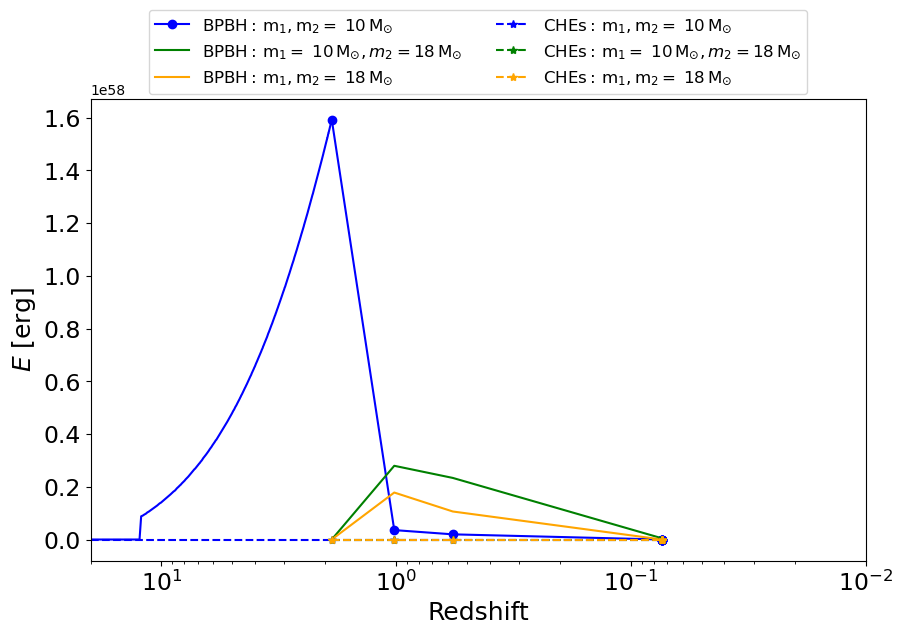

In [39]:
# --- Preparación de variables para graficar (4ª generación) ---
time_period_4_yr = delta_t_local
time_period_4_Gyr = time_period_4_yr / 1e9

POPULATION_BPBH_BY_GENERATION.append(np.sum(N_coll_BPBH_dict_4.get('0G-0G', 0)))
EMISSION_GW_OF_BPBH.append(np.sum(E_dot_BBH_dict_4.get('0G-0G', 0)))
NUMBER_OF_CHES_BY_GENERATION.append(np.sum(N_coll_CHES_dict_4.get('0G-0G', 0)))
EMISSION_GW_OF_CHES.append(np.sum(E_dot_CHES_dict_4.get('0G-0G', 0)))
PERIOD_OF_EVOLUTION_GYR.append(time_period_4_Gyr)

# --- Redshift del final de la 4ª generación ---
t_4th_gyr = (
    (((time_period_1_Gyr + time_period_2_Gyr + time_period_3_Gyr + time_period_4_Gyr) * u.Gyr).to(u.yr)).value
    + time_z_20
) / 1e9
redshift_evaluated_3 = z_at_value(cosmo.age, t_4th_gyr * u.Gyr, zmax=25).value
Z_PERIOD_tot.append(redshift_evaluated_3)

# --- Ejemplo de combinaciones 4G ---
POPULATION_BPBH_0G1G.append(np.sum(N_coll_BPBH_dict_4.get('0G-1G', 0)))
EMISSION_GW_BPBH_0G1G.append(np.sum(E_dot_BBH_dict_4.get('0G-1G', 0)))
NUMBER_OF_CHES_0G1G.append(np.sum(N_coll_CHES_dict_4.get('0G-1G', 0)))
EMISSION_GW_CHES_0G1G.append(np.sum(E_dot_CHES_dict_4.get('0G-1G', 0)))

POPULATION_BPBH_1G1G.append(np.sum(N_coll_BPBH_dict_4.get('1G-1G', 0)))
EMISSION_GW_BPBH_1G1G.append(np.sum(E_dot_BBH_dict_4.get('1G-1G', 0)))
NUMBER_OF_CHES_1G1G.append(np.sum(N_coll_CHES_dict_4.get('1G-1G', 0)))
EMISSION_GW_CHES_1G1G.append(np.sum(E_dot_CHES_dict_4.get('1G-1G', 0)))

# Aquí agregarías todas las combinaciones que quieras graficar (igual que en 3G)
#EMISSION_GW_BPBH_0G2G_b.append(np.sum(E_dot_BBH_dict_4.get('0G-2G_b', 0)))
#EMISSION_GW_CHES_0G2G_b.append(np.sum(E_dot_CHES_dict_4.get('0G-2G_b', 0)))


POPULATION_BPBH_1G2G_a.append(np.sum(N_coll_BPBH_dict_4.get('1G-2G_a', 0)))
EMISSION_GW_BPBH_1G2G_a.append(np.sum(E_dot_BBH_dict_4.get('1G-2G_a', 0)))
NUMBER_OF_CHES_1G2G_a.append(np.sum(N_coll_CHES_dict_4.get('1G-2G_a', 0)))
EMISSION_GW_CHES_1G2G_a.append(np.sum(E_dot_CHES_dict_4.get('1G-2G_a', 0)))


POPULATION_BPBH_1G2G_b.append(np.sum(N_coll_BPBH_dict_4.get('1G-2G_b', 0)))
EMISSION_GW_BPBH_1G2G_b.append(np.sum(E_dot_BBH_dict_4.get('1G-2G_b', 0)))
NUMBER_OF_CHES_1G2G_b.append(np.sum(N_coll_CHES_dict_4.get('1G-2G_b', 0)))
EMISSION_GW_CHES_1G2G_b.append(np.sum(E_dot_CHES_dict_4.get('1G-2G_b', 0)))

#POPULATION_BPBH_2G_a2G_a.append(np.sum(N_coll_BPBH_dict_4.get('2G_a-2G_a', 0)))
#EMISSION_GW_BPBH_2G_a2G_a.append(np.sum(E_dot_BBH_dict_4.get('2G_a-2G_a', 0)))
#NUMBER_OF_CHES_2G_a2G_a.append(np.sum(N_coll_CHES_dict_4.get('2G_a-2G_a', 0)))
#EMISSION_GW_CHES_2G_a2G_a.append(np.sum(E_dot_CHES_dict_4.get('2G_a-2G_a', 0)))




# --- Graficado ---
plt.figure(figsize=(10, 6))


# Periodo inicial (emisión continua previa a las generaciones discretas)
plt.plot(redshift_evaluated_0, E_dot_CHES_0, linestyle='--',color='blue')
plt.plot(redshift_evaluated_0, E_dot_BBH_0, color='blue')

# Corte entre periodos (valores totales por generación)
plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_BPBH, color='blue', marker='o',
         label=r'${\rm BPBH: \, m_{1}, m_{2} =}\;10\,{\rm M}_{\odot}$')


# Segunda generación
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_0G1G, color='green',
         label=r'${\rm BPBH: \, m_{1}}=\;10\,{\rm M}_{\odot}, m_{2} =  18\,{\rm M}_{\odot}$')
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G1G, color='orange', 
        label=r'${\rm BPBH: \, m_{1}, m_{2} =}\;18\,{\rm M}_{\odot}$')

plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_CHES, color='blue', linestyle='--', marker='*', label=r'${\rm CHEs:  \, m_{1}, m_{2} =}\;10\,{\rm M}_{\odot}$')

plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_0G1G, color='green', linestyle='--', marker='*',
         label=r'${\rm CHEs: \, m_{1}}=\;10\,{\rm M}_{\odot}, m_{2} =  18\,{\rm M}_{\odot}$')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G1G, color='orange', linestyle='--', marker='*',
        label=r'${\rm CHEs: \, m_{1}, m_{2} =}\;18\,{\rm M}_{\odot}$')

# Tercera generación
#plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_2G_a2G_a, color='cyan')
#plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_2G_a2G_a, color='cyan')
#plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G2G_a, color='lightblue')
# ... resto de combinaciones 3G

# Cuarta generación (puedes darle otro color)
#plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G2G_a, color='green')
#plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G2G_a, color='green')
# ... resto de combinaciones 4G

# Ajustes de eje
plt.gca().invert_xaxis()
plt.xlim([20.0,0.01])
plt.xlabel('Redshift', fontsize=18)
plt.ylabel(r'$E$ [erg]', fontsize=18)
#plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(
    fontsize=12,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.21),  # (x, y) relativo al eje
    ncol=2  )                     # opcional, número de columnas)
plt.savefig('GW_power_vs_redshift_4generations_10M.pdf')
plt.show()


In [ ]:
print(E_dot_BBH_0, EMISSION_GW_OF_BPBH)

In [ ]:
E_tot_10M_BPBH = np.concatenate([E_dot_BBH_0, EMISSION_GW_OF_BPBH])


E_tot_10M_CHEs = np.concatenate([E_dot_CHES_0, EMISSION_GW_OF_CHES])

In [ ]:
E_tot_1M_BPBH = np.array([0.0, 0.0, 0.0, 0.0,
                           1.13483655563465e+56, 1.5146046943312846e+56, 1.8943728330279194e+56, 2.2786088321798093e+56, 2.662844831331698e+56, 3.0292093886625688e+56, 3.4134453878144584e+56, 3.784277805600585e+56, 4.168513804752474e+56, 4.557217664359618e+56, 4.923582221690489e+56, 5.3078182208423785e+56, 5.6920542199942665e+56, 6.067354498235646e+56, 6.442654776477027e+56, 6.822422915173662e+56, 7.202191053870297e+56, 7.586427053022187e+56, 7.961727331263567e+56, 8.341495469960202e+56, 8.72573146911209e+56, 9.101031747353472e+56, 9.480799886050108e+56, 9.865035885201995e+56, 1.0231400442532868e+57, 1.0615636441684755e+57, 1.099540458038139e+57, 1.137070485862277e+57, 1.1750472997319406e+57, 1.2148112577837056e+57, 1.2514477135167929e+57, 1.2889777413409309e+57, 1.3274013412561198e+57, 1.364931369080258e+57, 1.4033549689954468e+57, 1.4404382107740594e+57, 1.4784150246437232e+57, 1.5159450524678611e+57, 1.5548154384285755e+57, 1.5932390383437644e+57, 1.6312158522134274e+57, 1.6674055219009895e+57, 1.7062759078617038e+57, 1.7446995077768927e+57, 1.7817827495555056e+57, 1.8202063494706944e+57, 1.8586299493858833e+57, 1.8957131911644962e+57, 1.9332432189886342e+57, 1.9716668189038227e+57, 2.0096436327734862e+57, 2.04762044664315e+57, 2.085597260512813e+57, 2.123127288336951e+57, 2.1611041022066145e+57, 2.1995277021218034e+57, 2.2375045159914665e+57, 2.2754813298611306e+57, 2.312564571639743e+57, 2.350988171554932e+57, 2.3889649854245955e+57, 2.4260482272032077e+57, 2.464471827118397e+57, 2.5028954270335858e+57, 2.5404254548577238e+57, 2.5788490547729127e+57, 2.616825868642576e+57, 2.6539091104211886e+57, 2.6923327103363775e+57, 2.7307563102515668e+57, 2.7678395520301793e+57, 2.8053695798543173e+57, 2.8428996076784553e+57, 2.8813232075936442e+57, 2.920193593554359e+57, 2.9577236213784972e+57, 2.9961472212936857e+57, 3.033677249117824e+57, 3.0707604908964363e+57, 3.109630876857151e+57, 3.1476076907268144e+57, 3.1851377185509524e+57, 3.222220960329564e+57, 3.260644560244753e+57, 3.298174588068892e+57, 3.3374917600751316e+57, 3.375468573944795e+57, 3.412551815723407e+57, 3.4500818435475456e+57, 3.4885054434627344e+57, 3.5264822573323986e+57, 3.564459071202062e+57, 3.6019890990262e+57, 3.640412698941389e+57, 3.6774959407200014e+57, 3.715472754589665e+57, 3.753896354504854e+57, 3.792319954420043e+57, 3.8298499822441806e+57, 3.86827358215937e+57, 3.905356823937982e+57, 3.9433336378076455e+57, 3.98220402376836e+57, 4.019734051592498e+57, 4.0568172933711104e+57, 4.0947941072407745e+57, 4.132770921110437e+57, 4.170747734980101e+57, 4.2082777628042394e+57, 4.2467013627194276e+57, 4.285571748680142e+57, 4.322654990458755e+57, 4.360631804328418e+57, 4.398608618198081e+57, 4.436585432067745e+57, 4.4745622459374075e+57, 4.512539059807072e+57, 4.549622301585684e+57, 4.5871523294098236e+57, 4.6264695014160626e+57, 4.664446315285726e+57, 4.701976343109864e+57, 4.7399531569795275e+57, 4.7774831848036655e+57, 4.815459998673329e+57, 4.853436812542992e+57, 4.891413626412656e+57, 4.929390440282319e+57, 4.9673672541519834e+57, 5.004897281976121e+57, 5.042874095845785e+57, 5.0808509097154476e+57, 5.119274509630637e+57, 5.1572513235003e+57, 5.194781351324438e+57, 5.232758165194101e+57, 5.270734979063765e+57, 5.3091585789789536e+57, 5.346688606803092e+57, 5.3842186346272296e+57, 5.421748662451368e+57, 5.459725476321032e+57, 5.4977022901906945e+57, 5.5356791040603586e+57, 5.5741027039755475e+57, 5.61207951784521e+57, 5.650056331714875e+57, 5.688033145584538e+57, 5.7264567454997274e+57, 5.763539987278339e+57, 5.801516801148004e+57, 5.839493615017667e+57, 5.877023642841805e+57, 5.915000456711469e+57, 5.952530484535607e+57, 5.990954084450795e+57, 6.029377684365985e+57, 6.067354498235648e+57, 6.105331312105311e+57, 6.142861339929449e+57, 6.1803913677535876e+57, 6.2188149676687764e+57, 6.2563449954929144e+57, 6.294321809362578e+57, 6.331851837186715e+57, 6.370275437101905e+57, 6.408252250971567e+57, 6.44622906484123e+57, 6.48465266475642e+57, 6.522629478626083e+57, 6.559712720404696e+57, 6.598136320319885e+57, 6.635219562098497e+57, 6.673643162013687e+57, 6.711173189837824e+57, 6.749150003707488e+57, 6.787126817577151e+57, 6.824656845401288e+57, 6.863527231362005e+57, 6.901950831277193e+57, 6.939034073055805e+57, 6.976564100879943e+57, 7.01543448684066e+57, 7.052964514664797e+57, 7.090494542488934e+57, 7.128471356358599e+57, 7.166894956273787e+57, 7.2039781980524e+57, 7.241955011922063e+57, 7.280378611837252e+57, 7.317461853615866e+57, 7.356779025622105e+57, 7.394755839491767e+57, 7.432285867315906e+57, 7.469815895140045e+57, 7.507345922964182e+57, 7.54576952287937e+57, 7.58329955070351e+57, 7.621276364573173e+57, 7.659699964488361e+57, 7.697229992312499e+57, 7.735206806182164e+57, 7.773630406097352e+57, 7.81205400601254e+57, 7.850030819882203e+57, 7.886220489569766e+57, 7.924644089484955e+57, 7.962174117309092e+57, 8.00059771722428e+57, 8.03902131713947e+57, 8.076104558918083e+57, 8.114081372787746e+57, 8.15205818665741e+57, 8.1904817865726e+57, 8.228905386487788e+57, 8.2659886282664e+57, 8.30441222818159e+57, 8.341495469960201e+57, 8.379919069875391e+57, 8.41834266979058e+57, 8.456319483660243e+57, 8.49384951148438e+57, 8.530932753262994e+57, 8.568909567132657e+57, 8.607333167047845e+57, 8.64530998091751e+57, 8.683286794787173e+57, 8.721710394702361e+57, 8.758793636480974e+57, 8.797217236396163e+57, 8.835194050265827e+57, 8.872724078089964e+57, 8.910254105914101e+57, 8.949124491874815e+57, 8.986654519698956e+57, 9.024184547523094e+57, 9.062608147438282e+57, 9.100584961307945e+57, 9.139008561223134e+57, 9.176538589047274e+57, 9.213621830825886e+57, 9.251598644695549e+57, 9.289575458565212e+57, 9.327552272434876e+57, 9.365975872350064e+57, 9.403505900174203e+57, 9.441482714043865e+57, 9.479906313959055e+57, 9.517436341783194e+57, 9.555859941698382e+57, 9.593836755568045e+57, 9.630919997346658e+57, 9.668450025170795e+57, 9.706873625085983e+57, 9.745297225001174e+57, 9.783274038870837e+57, 9.8212508527405e+57, 9.858334094519113e+57, 9.896310908388776e+57, 9.934734508303967e+57, 9.972264536128104e+57, 1.0011134922088818e+58, 1.0047771377821904e+58, 1.0086194977737095e+58, 1.0124618577652283e+58, 1.016214860547642e+58, 1.0200125419346083e+58, 1.0238549019261274e+58, 1.0275632261039886e+58, 1.0313162288864023e+58, 1.0351585888779213e+58, 1.0389562702648876e+58, 1.0427539516518538e+58, 1.0465516330388203e+58, 1.0503493144257867e+58, 1.0541023172082004e+58, 1.0579446771997194e+58, 1.0616976799821331e+58, 1.0654953613690994e+58, 1.0692483641515134e+58, 1.0730460455384796e+58, 1.076933084134551e+58, 1.0805967297078597e+58, 1.0844390896993787e+58, 1.0883261282954501e+58, 1.0920344524733114e+58, 1.0958321338602777e+58, 1.0995851366426914e+58, 1.1033828180296579e+58, 1.1071804994166243e+58, 1.1110675380126956e+58, 1.1148205407951095e+58, 1.1185288649729707e+58, 1.1223712249644895e+58, 1.1261689063514558e+58, 1.1299219091338699e+58, 1.1337195905208362e+58, 1.1346578412164396e+58, 1.1356407705165956e+58, 1.1365343426076465e+58, 1.1374725933032499e+58, 1.1383661653943008e+58, 1.1392597374853517e+58, 1.1401533095764026e+58, 1.1411362388765586e+58, 1.1419404537585044e+58, 1.1430127402677656e+58, 1.1438616337542639e+58, 1.144755205845315e+58, 1.1456934565409184e+58, 1.1465870286319693e+58, 1.1475252793275727e+58, 1.1484635300231761e+58, 1.1494017807187796e+58, 1.150340031414383e+58, 1.1512782821099864e+58, 1.1521271755964848e+58, 1.1530207476875357e+58, 1.1540483555922442e+58, 1.1548972490787425e+58, 1.155835499774346e+58, 1.1566843932608443e+58, 1.1576226439564477e+58, 1.1585608946520512e+58, 1.1594544667431023e+58, 1.1603927174387059e+58, 1.1613309681343093e+58, 1.1621798616208077e+58, 1.1632074695255162e+58, 1.1640563630120145e+58, 1.1649499351030654e+58, 1.1659328644032214e+58, 1.1668264364942723e+58, 1.1677200085853232e+58, 1.1686582592809268e+58, 1.1696411885810827e+58, 1.1704900820675811e+58, 1.1714283327631845e+58, 1.1723219048542354e+58, 1.1732154769452863e+58, 1.1742430848499948e+58, 1.1750472997319406e+58, 1.1760749076366493e+58, 1.176879122518595e+58, 1.177862051818751e+58, 1.178755623909802e+58, 1.1796491960008528e+58, 1.1805874466964563e+58, 1.1815703759966124e+58, 1.1824639480876633e+58, 1.1833575201787141e+58, 1.1842064136652125e+58, 1.1851893429653685e+58, 1.1861275936609719e+58, 1.1870658443565753e+58, 1.1879147378430737e+58, 1.1887636313295722e+58, 1.1898359178388332e+58, 1.1906848113253316e+58, 1.191623062020935e+58, 1.192605991321091e+58, 1.1934548848075893e+58, 1.1944378141077453e+58, 1.1952867075942436e+58, 1.1962249582898471e+58, 1.197118530380898e+58, 1.1980567810765014e+58, 1.1989503531675523e+58, 1.1999332824677084e+58, 1.2008268545587593e+58, 1.2017204266498103e+58, 1.2026139987408612e+58, 1.2035522494364646e+58, 1.2045351787366206e+58, 1.2054287508276715e+58, 1.2062776443141698e+58, 1.2072158950097733e+58, 1.2081541457053767e+58, 1.2090477177964276e+58, 1.2100306470965836e+58, 1.2109242191876346e+58, 1.211773112674133e+58, 1.2128007205788415e+58, 1.2136496140653398e+58, 1.2145878647609432e+58, 1.2155261154565467e+58, 1.2164196875475976e+58, 1.2173132596386484e+58, 1.218340867543357e+58, 1.2191897610298553e+58, 1.2201280117254587e+58, 1.2210662624210622e+58, 1.2219151559075607e+58, 1.2228980852077166e+58, 1.223746978694215e+58, 1.2247745865989235e+58, 1.2255788014808693e+58, 1.2264723735719202e+58, 1.2274553028720762e+58, 1.2283935535676796e+58, 1.2292871256587305e+58, 1.2302253763543339e+58, 1.2311636270499374e+58, 1.2321018777455408e+58, 1.2330401284411445e+58, 1.2339337005321954e+58, 1.2347379154141412e+58, 1.2357655233188497e+58, 1.2366590954099006e+58, 1.237597346105504e+58, 1.2384909181965549e+58, 1.2393398116830534e+58, 1.2402780623786568e+58, 1.2412609916788128e+58, 1.2421545637698637e+58, 1.2431374930700197e+58, 1.243986386556518e+58, 1.2448799586475689e+58, 1.2457288521340672e+58, 1.2468011386433283e+58, 1.2476500321298267e+58, 1.2485882828254301e+58, 1.2494371763119284e+58, 1.2504201056120844e+58, 1.2514030349122405e+58, 1.2522519283987389e+58, 1.2531901790943423e+58, 1.2540837511853935e+58, 1.2550220018809969e+58, 1.2559602525766002e+58, 1.2568985032722036e+58, 1.2577027181541494e+58, 1.2586409688497529e+58, 1.2596685767544614e+58, 1.2605174702409597e+58, 1.2614557209365632e+58, 1.262349293027614e+58, 1.2632875437232175e+58, 1.2641364372097158e+58, 1.2651193665098718e+58, 1.2660576172054752e+58, 1.266951189296526e+58, 1.2678000827830245e+58, 1.2687830120831804e+58, 1.2697659413833364e+58, 1.2707041920789398e+58, 1.2715530855654382e+58, 1.2724913362610416e+58, 1.2733402297475402e+58, 1.2743678376522488e+58, 1.2752614097432996e+58, 1.2760656246252454e+58, 1.2770485539254014e+58, 1.2779421260164523e+58, 1.2788803767120557e+58, 1.2799079846167643e+58, 1.2806675208941575e+58, 1.281695128798866e+58, 1.2825440222853644e+58, 1.2834822729809678e+58, 1.2843758450720187e+58, 1.2853587743721747e+58, 1.286207667858673e+58, 1.2871459185542765e+58, 1.2879948120407748e+58, 1.2890224199454833e+58, 1.2899159920365342e+58, 1.2908095641275854e+58, 1.2917478148231888e+58, 1.2926860655187922e+58, 1.2936243162143957e+58, 1.294562566909999e+58, 1.2954114603964975e+58, 1.2962603538829958e+58, 1.2972879617877043e+58, 1.2982708910878603e+58, 1.299075105969806e+58, 1.300058035269962e+58, 1.300862250151908e+58, 1.3018451794520638e+58, 1.3027834301476673e+58, 1.3036770022387182e+58, 1.3046152529343216e+58, 1.305553503629925e+58, 1.306447075720976e+58, 1.307340647812027e+58, 1.308323577112183e+58, 1.309217149203234e+58, 1.31020007850339e+58, 1.3110489719898883e+58, 1.3120319012900442e+58, 1.312925473381095e+58, 1.3137743668675935e+58, 1.314712617563197e+58, 1.3156508682588006e+58, 1.316589118954404e+58, 1.3175273696500075e+58, 1.3184209417410584e+58, 1.3193145138321093e+58, 1.3202527645277127e+58, 1.321191015223316e+58, 1.3220399087098145e+58, 1.3229334808008654e+58, 1.323961088705574e+58, 1.3248099821920722e+58, 1.325703554283123e+58, 1.3266418049787265e+58, 1.32758005567433e+58, 1.3285183063699334e+58, 1.3294118784609843e+58, 1.3303948077611403e+58, 1.3312437012476386e+58, 1.332226630547795e+58, 1.3330755240342932e+58, 1.3340137747298967e+58, 1.3349073468209475e+58, 1.3358902761211035e+58, 1.336828526816707e+58, 1.3376774203032053e+58, 1.3386156709988087e+58, 1.3395539216944122e+58, 1.3404028151809105e+58, 1.3413857444810665e+58, 1.3422346379675648e+58, 1.3432175672677208e+58, 1.3441558179633242e+58, 1.3450047114498226e+58, 1.3458982835408735e+58, 1.3469258914455823e+58, 1.3477747849320806e+58, 1.348713035627684e+58, 1.34969596492784e+58, 1.350589537018891e+58, 1.3514384305053892e+58, 1.3524660384100978e+58, 1.3532702532920436e+58, 1.3542531825921995e+58, 1.355102076078698e+58, 1.3561296839834064e+58, 1.3569785774699048e+58, 1.357827470956403e+58, 1.358810400256559e+58, 1.3597486509521625e+58, 1.3606422230432134e+58, 1.3615804737388168e+58, 1.3625187244344203e+58, 1.363322939316366e+58, 1.364305868616522e+58, 1.3652887979166783e+58, 1.3661376914031766e+58, 1.3671652993078852e+58, 1.3679248355852784e+58, 1.3689077648854347e+58, 1.369846015581038e+58, 1.3707842662766415e+58, 1.3716778383676924e+58, 1.3725714104587433e+58, 1.3734649825497942e+58, 1.3744925904545027e+58, 1.3753861625455536e+58, 1.3762797346366045e+58, 1.3771286281231028e+58, 1.3781562360278114e+58, 1.3790498081188622e+58, 1.379943380209913e+58, 1.380836952300964e+58, 1.381730524392015e+58, 1.382713453692171e+58, 1.3835623471786692e+58, 1.3845005978742727e+58, 1.3855282057789812e+58, 1.3862877420563744e+58, 1.387315349961083e+58, 1.3881642434475813e+58, 1.3891471727477376e+58, 1.3900407448387884e+58, 1.390978995534392e+58, 1.3918725676254428e+58, 1.3928108183210462e+58, 1.3937937476212022e+58, 1.3946426411077005e+58, 1.3955362131987514e+58, 1.3964297852898023e+58, 1.3974573931945108e+58, 1.3983509652855617e+58, 1.3992892159811657e+58, 1.400138109467664e+58, 1.4010763601632675e+58, 1.4019699322543184e+58, 1.4029528615544743e+58, 1.4038464336455252e+58, 1.404740005736576e+58, 1.4056782564321795e+58, 1.406616507127783e+58, 1.4074654006142813e+58, 1.4084036513098848e+58, 1.4093419020054882e+58, 1.410235474096539e+58, 1.4112630820012476e+58, 1.412111975487746e+58, 1.4130055475787968e+58, 1.4139884768789528e+58, 1.4147926917608986e+58, 1.415820299665607e+58, 1.4167585503612106e+58, 1.417696801056814e+58, 1.4185010159387598e+58, 1.419394588029811e+58, 1.420377517329967e+58, 1.4213157680255704e+58, 1.4221646615120687e+58, 1.4231029122076721e+58, 1.4240411629032756e+58, 1.424979413598879e+58, 1.42587298568993e+58, 1.4268112363855333e+58, 1.427615451267479e+58, 1.4286430591721876e+58, 1.4296259884723436e+58, 1.430474881958842e+58, 1.431457811258998e+58, 1.4322620261409437e+58, 1.4332002768365472e+58, 1.4341832061367032e+58, 1.4350320996232015e+58, 1.43605970752791e+58, 1.4368639224098558e+58, 1.4378021731054592e+58, 1.4386510665919576e+58, 1.439723353101219e+58, 1.4405722465877173e+58, 1.4414658186787682e+58, 1.4424040693743716e+58, 1.443342320069975e+58, 1.4442805707655785e+58, 1.4451294642520768e+58, 1.4460230363431277e+58, 1.446961287038731e+58, 1.447854859129782e+58, 1.4488824670344908e+58, 1.4498207177300942e+58, 1.45062493261204e+58, 1.451607861912196e+58, 1.4525461126077995e+58, 1.4534396846988503e+58, 1.4543779353944538e+58, 1.4553161860900572e+58, 1.456209758181108e+58, 1.457013973063054e+58, 1.458086259572315e+58, 1.4589351530588133e+58, 1.4598734037544167e+58, 1.460722297240915e+58, 1.4617052265410713e+58, 1.4626881558412273e+58, 1.4635370493277257e+58, 1.4644306214187765e+58, 1.4653241935098274e+58, 1.466262444205431e+58, 1.4672006949010343e+58, 1.4681389455966377e+58, 1.4690325176876886e+58, 1.4699260897787395e+58, 1.4709090190788955e+58, 1.4717579125653938e+58, 1.472830199074655e+58, 1.4735897353520481e+58, 1.474572664652204e+58, 1.475466236743255e+58, 1.476359808834306e+58, 1.4772980595299093e+58, 1.4782809888300653e+58, 1.4791298823165637e+58, 1.480068133012167e+58, 1.481051062312323e+58, 1.481944634403374e+58, 1.4828382064944248e+58, 1.4837764571900283e+58, 1.4846700292810794e+58, 1.4855189227675778e+58, 1.4865465306722863e+58, 1.4873954241587846e+58, 1.488333674854388e+58, 1.4891825683408864e+58, 1.4902548548501475e+58, 1.491193105545751e+58, 1.4919973204276967e+58, 1.492980249727853e+58, 1.493873821818904e+58, 1.4947673939099548e+58, 1.4957503232101107e+58, 1.496599216696609e+58, 1.4975374673922125e+58, 1.498475718087816e+58, 1.4993692901788668e+58, 1.5002628622699177e+58, 1.5012904701746262e+58, 1.502094685056572e+58, 1.5030329357521755e+58, 1.5039265078432264e+58, 1.5048647585388298e+58, 1.5058030092344332e+58, 1.506696581325484e+58, 1.5075454748119825e+58, 1.5085284041121384e+58, 1.5094666548077419e+58, 1.5104495841078978e+58, 1.5113431561989487e+58, 1.5122367282899996e+58, 1.513174978985603e+58, 1.5140685510766545e+58, 1.5149621231677054e+58, 1.5159003738633088e+58, 1.5168833031634648e+58, 1.517732196649963e+58, 1.5186704473455666e+58, 1.51960869804117e+58, 1.5204575915276683e+58, 1.5214405208278243e+58, 1.5223340929188752e+58, 1.5232723436144786e+58, 1.524121237100977e+58, 1.5250594877965804e+58, 1.5259530598876313e+58, 1.5268913105832347e+58, 1.5277848826742856e+58, 1.5287678119744416e+58, 1.529706062670045e+58, 1.5306443133656485e+58, 1.5314932068521468e+58, 1.5324761361523028e+58, 1.5333697082433537e+58, 1.534307958938957e+58, 1.535201531030008e+58, 1.536095103121059e+58, 1.5370780324212149e+58, 1.5378822473031607e+58, 1.538820497998764e+58, 1.5398481059034726e+58, 1.540696999389971e+58, 1.5416352500855744e+58, 1.5424841435720727e+58, 1.5435117514767815e+58, 1.5443159663587273e+58, 1.545343574263436e+58, 1.546147789145382e+58, 1.5470413612364328e+58, 1.5480689691411413e+58, 1.5490072198367448e+58, 1.5499007919277957e+58, 1.5507943640188465e+58, 1.55173261471445e+58, 1.5526708654100534e+58, 1.5535197588965518e+58, 1.5545026881967077e+58, 1.5554409388923112e+58, 1.556245153774257e+58, 1.557228083074413e+58, 1.5581663337700164e+58, 1.5590599058610673e+58, 1.5600428351612232e+58, 1.5608917286477216e+58, 1.561829979343325e+58, 1.5627682300389284e+58, 1.5636618021299793e+58, 1.5645106956164777e+58, 1.5654936249166337e+58, 1.566342518403132e+58, 1.5673701263078405e+58, 1.568308377003444e+58, 1.5691572704899423e+58, 1.5700955211855457e+58, 1.5710337718811492e+58, 1.5720167011813054e+58, 1.5728655946678038e+58, 1.5738485239679597e+58, 1.574697417454458e+58, 1.5756356681500615e+58, 1.5764845616365599e+58, 1.5774674909367158e+58, 1.578450420236872e+58, 1.579254635118818e+58, 1.5801928858144213e+58, 1.5811311365100248e+58, 1.5820247086010756e+58, 1.5830076379012316e+58, 1.58385653138773e+58, 1.5847501034787808e+58, 1.5856883541743843e+58, 1.5866712834745403e+58, 1.5875201769610386e+58, 1.5884137490520895e+58, 1.5893966783522455e+58, 1.5903796076524014e+58, 1.5912285011388998e+58, 1.5922114304390558e+58, 1.5922114304390558e+58, 3.5966276664798944e+56, 1.974794321222501e+56, 0.0])


E_tot_1M_CHEs = np.array([0.0, 0.0, 1.4081283495929258e+47, 2.8368133174280844e+47,
                          4.214106739657662e+47, 5.6427917074928195e+47, 7.050920057085745e+47, 8.479605024920903e+47, 9.88773337451383e+47, 1.1306140033227872e+48, 1.268343345545745e+48, 1.4112118423292608e+48, 1.553052508200665e+48, 1.694893174072069e+48, 1.8357060090313616e+48, 1.977546674902766e+48, 2.1163038480378352e+48, 2.2581445139092394e+48, 2.398957348868532e+48, 2.5407980147399364e+48, 2.6826386806113406e+48, 2.8244793464827447e+48, 2.9652921814420376e+48, 3.105077185489218e+48, 3.246917851360623e+48, 3.389786348144138e+48, 3.5295713521913195e+48, 3.6693563562385e+48, 3.810169191197793e+48, 3.952009857069197e+48, 4.09282269202849e+48, 4.235691188812005e+48, 4.376504023771298e+48, 4.515261196906367e+48, 4.658129693689883e+48, 4.798942528649176e+48, 4.9418110254326915e+48, 5.083651691304096e+48, 5.2234366953512766e+48, 5.3621938684863464e+48, 5.507118027094085e+48, 5.645875200229155e+48, 5.7877158661005585e+48, 5.929556531971964e+48, 6.070369366931255e+48, 6.209126540066325e+48, 6.353022867761953e+48, 6.493835702721245e+48, 6.634648537680537e+48, 6.774433541727718e+48, 6.918329869423346e+48, 7.059142704382639e+48, 7.197899877517707e+48, 7.340768374301223e+48, 7.48363687108474e+48, 7.623421875131921e+48, 7.763206879179101e+48, 7.904019714138394e+48, 8.044832549097687e+48, 8.187701045881203e+48, 8.327486049928384e+48, 8.470354546711899e+48, 8.61013955075908e+48, 8.751980216630485e+48, 8.892793051589777e+48, 9.035661548373293e+48, 9.176474383332585e+48, 9.316259387379766e+48, 9.458100053251171e+48, 9.599940719122575e+48, 9.741781384993979e+48, 9.882594219953271e+48, 1.0022379224000453e+49, 1.0163192058959746e+49, 1.0304004893919037e+49, 1.0445845559790442e+49, 1.0587686225661846e+49, 1.0727471229709028e+49, 1.0868284064668319e+49, 1.1011152561451835e+49, 1.1151965396411128e+49, 1.1293806062282533e+49, 1.1433591066329714e+49, 1.1575431732201117e+49, 1.1717272398072521e+49, 1.1858085233031814e+49, 1.1997870237078994e+49, 1.214073873386251e+49, 1.2280523737909693e+49, 1.2420308741956873e+49, 1.256317723874039e+49, 1.270296224278757e+49, 1.2845830739571085e+49, 1.2986643574530378e+49, 1.3128484240401781e+49, 1.3269297075361074e+49, 1.341113774123248e+49, 1.355092274527966e+49, 1.3693791242063176e+49, 1.383563190793458e+49, 1.3975416911981762e+49, 1.4116229746941055e+49, 1.4258070412812458e+49, 1.439888324777175e+49, 1.453866825181893e+49, 1.4681536748602447e+49, 1.482234958356174e+49, 1.4963162418521033e+49, 1.5103975253480326e+49, 1.5246843750263842e+49, 1.5385600923398911e+49, 1.5527441589270315e+49, 1.5669282255141718e+49, 1.581009509010101e+49, 1.5950907925060304e+49, 1.6091720760019596e+49, 1.623253359497889e+49, 1.6374374260850292e+49, 1.6517242757633809e+49, 1.665702776168099e+49, 1.679681276572817e+49, 1.6939681262511687e+49, 1.708049409747098e+49, 1.7221306932430273e+49, 1.736417542921379e+49, 1.750396043326097e+49, 1.7645801099132372e+49, 1.7787641765003778e+49, 1.7927426769050958e+49, 1.806926743492236e+49, 1.8210080269881654e+49, 1.835192093575306e+49, 1.849170593980024e+49, 1.8634574436583756e+49, 1.877538727154305e+49, 1.8916200106502342e+49, 1.9055985110549522e+49, 1.9198853607333038e+49, 1.933966644229233e+49, 1.9477395784515288e+49, 1.9621292112210917e+49, 1.976313277808232e+49, 1.99029177821295e+49, 2.0044758448000906e+49, 2.0185571282960198e+49, 2.0325356287007378e+49, 2.0469252614703007e+49, 2.0610065449662298e+49, 2.0752933946445814e+49, 2.0891691119580883e+49, 2.103353178545229e+49, 2.117331678949947e+49, 2.1316185286282985e+49, 2.1456998121242278e+49, 2.1596783125289458e+49, 2.1739651622072974e+49, 2.1879436626120154e+49, 2.202127729199156e+49, 2.2163117957862963e+49, 2.2303930792822256e+49, 2.244474362778155e+49, 2.2586584293652952e+49, 2.2727397128612245e+49, 2.287026562539576e+49, 2.3010050629442944e+49, 2.3149835633490124e+49, 2.329270413027364e+49, 2.3433516965232933e+49, 2.3572274138368e+49, 2.3714114804239403e+49, 2.385698330102292e+49, 2.3996768305070104e+49, 2.4137581140029397e+49, 2.42794218059008e+49, 2.4421262471772204e+49, 2.4562075306731496e+49, 2.47039159726029e+49, 2.484678446938642e+49, 2.4984513811609375e+49, 2.512635447748078e+49, 2.526819514335218e+49, 2.54110636401357e+49, 2.555084864418288e+49, 2.569166147914217e+49, 2.5831446483189353e+49, 2.5974314979972867e+49, 2.611512781493216e+49, 2.6256968480803563e+49, 2.6396753484850745e+49, 2.6539621981634264e+49, 2.667940698568144e+49, 2.6819191989728624e+49, 2.6964116148336363e+49, 2.7103901152383546e+49, 2.7243686156430723e+49, 2.7385526822302126e+49, 2.7528395319085645e+49, 2.766715249222071e+49, 2.7807965327180005e+49, 2.7950833823963524e+49, 2.80906188280107e+49, 2.8230403832057884e+49, 2.83732723288414e+49, 2.8515112994712806e+49, 2.86559258296721e+49, 2.879673866463139e+49, 2.8938579330502795e+49, 2.9078364334549977e+49, 2.922123283133349e+49, 2.9362045666292783e+49, 2.9503886332164187e+49, 2.964572699803559e+49, 2.978448417117066e+49, 2.9926324837042065e+49, 3.006816550291347e+49, 3.020897833787276e+49, 3.0349791172832054e+49, 3.0489576176879237e+49, 3.063141684275064e+49, 3.0773257508622043e+49, 3.0914070343581336e+49, 3.1056938840364855e+49, 3.119672384441203e+49, 3.1337536679371325e+49, 3.147937734524273e+49, 3.1621218011114137e+49, 3.1762030846073424e+49, 3.1902843681032717e+49, 3.20426286850799e+49, 3.2184469350951303e+49, 3.2325282185910596e+49, 3.2467122851782e+49, 3.260793568674129e+49, 3.275080418352481e+49, 3.288956135665988e+49, 3.3032429853443397e+49, 3.3172214857490574e+49, 3.331508335427409e+49, 3.3455896189233385e+49, 3.35987646860169e+49, 3.373752185915197e+49, 3.3878334694111264e+49, 3.4020175359982667e+49, 3.416201602585407e+49, 3.4303856691725474e+49, 3.4443641695772656e+49, 3.458342669981984e+49, 3.472423953477913e+49, 3.4868135862474756e+49, 3.500792086652194e+49, 3.515078936330545e+49, 3.5289546536440524e+49, 3.5430359371399817e+49, 3.557322786818333e+49, 3.5715068534054733e+49, 3.5855881369014026e+49, 3.599566637306121e+49, 3.613750703893261e+49, 3.6278319873891905e+49, 3.642016053976331e+49, 3.6562001205634717e+49, 3.670384187150612e+49, 3.6842599044641187e+49, 3.698341187960048e+49, 3.712730820729611e+49, 3.7265037549519066e+49, 3.740790604630258e+49, 3.754974671217399e+49, 3.7689531716221165e+49, 3.783034455118046e+49, 3.7973213047963976e+49, 3.811402588292327e+49, 3.825483871788256e+49, 3.8396679383753965e+49, 3.853749221871326e+49, 3.867830505367255e+49, 3.8820145719543954e+49, 3.8960958554503247e+49, 3.910074355855043e+49, 3.9244639886246054e+49, 3.938236922846901e+49, 3.952420989434042e+49, 3.966707839112393e+49, 3.9808919056995335e+49, 3.994767623013041e+49, 4.009054472691392e+49, 4.0231357561873214e+49, 4.0373198227744617e+49, 4.051401106270391e+49, 4.065687955948743e+49, 4.0796664563534606e+49, 4.093542173666968e+49, 4.107829023345319e+49, 4.1220130899324595e+49, 4.135991590337178e+49, 4.150175656924318e+49, 4.1642569404202474e+49, 4.1783382239161767e+49, 4.192522290503317e+49, 4.2066035739992463e+49, 4.220890423677598e+49, 4.224179482596355e+49, 4.2275713246063237e+49, 4.2308603835250807e+49, 4.234663357899894e+49, 4.237644067545018e+49, 4.2413442588286194e+49, 4.2446333177473764e+49, 4.248127942848556e+49, 4.2515197848585245e+49, 4.254911626868493e+49, 4.2584062519696726e+49, 4.2617980939796406e+49, 4.26529271908082e+49, 4.2685817779995777e+49, 4.2718708369183347e+49, 4.2755710282019363e+49, 4.279065653303116e+49, 4.282149146039451e+49, 4.2857465542318414e+49, 4.28913839624181e+49, 4.292427455160567e+49, 4.296024863352958e+49, 4.299519488454137e+49, 4.3028085473728946e+49, 4.306200389382863e+49, 4.309695014484042e+49, 4.3129840734027997e+49, 4.3165814815951903e+49, 4.32007610669637e+49, 4.323159599432705e+49, 4.3267570076250954e+49, 4.330148849635064e+49, 4.333540691645032e+49, 4.3369325336550005e+49, 4.340632724938602e+49, 4.3438190007661486e+49, 4.3473136258673277e+49, 4.350705467877296e+49, 4.354200092978476e+49, 4.3575919349884443e+49, 4.3607782108159903e+49, 4.3645811851908034e+49, 4.367664677927138e+49, 4.37136486921074e+49, 4.374653928129497e+49, 4.3780457701394655e+49, 4.381540395240645e+49, 4.384932237250613e+49, 4.3882212961693706e+49, 4.391818704361761e+49, 4.39521054637173e+49, 4.398602388381698e+49, 4.4019942303916663e+49, 4.405488855492846e+49, 4.4088806975028144e+49, 4.4120669733303604e+49, 4.41556159843154e+49, 4.4192617897151416e+49, 4.4224480655426875e+49, 4.426045473735078e+49, 4.4292317495626246e+49, 4.4326235915725926e+49, 4.436323782856195e+49, 4.439715624866163e+49, 4.4430046837849203e+49, 4.4463965257948883e+49, 4.449891150896068e+49, 4.4531802098148254e+49, 4.456983184189638e+49, 4.4601694600171845e+49, 4.4636640851183636e+49, 4.4667475778546985e+49, 4.4705505522295117e+49, 4.4737368280570577e+49, 4.477231453158237e+49, 4.480726078259417e+49, 4.484015137178174e+49, 4.4875097622793534e+49, 4.491004387380533e+49, 4.4942934462992904e+49, 4.4976852883092585e+49, 4.501282696501649e+49, 4.5045717554204066e+49, 4.5078608143391636e+49, 4.511458222531554e+49, 4.5148500645415227e+49, 4.518241906551491e+49, 4.521736531652671e+49, 4.5252311567538504e+49, 4.5285202156726074e+49, 4.532014840773787e+49, 4.535303899692544e+49, 4.5387985247937235e+49, 4.542190366803692e+49, 4.5456849919048716e+49, 4.549179617006051e+49, 4.552263109742386e+49, 4.5559633010259877e+49, 4.5592523599447447e+49, 4.562849768137136e+49, 4.566241610147104e+49, 4.56942788597465e+49, 4.5728197279846184e+49, 4.576417136177009e+49, 4.5798089781869775e+49, 4.583200820196946e+49, 4.586695445298125e+49, 4.5899845042168826e+49, 4.593581912409273e+49, 4.5969737544192417e+49, 4.6006739457028433e+49, 4.6037574384391783e+49, 4.607149280449147e+49, 4.610541122459115e+49, 4.6140357475602944e+49, 4.617530372661474e+49, 4.6210249977626535e+49, 4.6242112735901995e+49, 4.627705898691379e+49, 4.6313033068837697e+49, 4.6344895827113156e+49, 4.637984207812495e+49, 4.6413760498224637e+49, 4.6446651087412207e+49, 4.648262516933612e+49, 4.65165435894358e+49, 4.6551489840447594e+49, 4.658438042963517e+49, 4.661932668064696e+49, 4.6653245100746645e+49, 4.668716352084633e+49, 4.6722109771858126e+49, 4.6755000361045696e+49, 4.678994661205749e+49, 4.682386503215717e+49, 4.686086694499319e+49, 4.689170187235654e+49, 4.692767595428045e+49, 4.696056654346802e+49, 4.699551279447981e+49, 4.70294312145795e+49, 4.706540529650341e+49, 4.709624022386676e+49, 4.713015864396644e+49, 4.716613272589035e+49, 4.720107897690214e+49, 4.723602522791394e+49, 4.72678879861894e+49, 4.730283423720119e+49, 4.733572482638877e+49, 4.737169890831267e+49, 4.740561732841236e+49, 4.743953574851204e+49, 4.747448199952383e+49, 4.750737258871141e+49, 4.75423188397232e+49, 4.757726509073499e+49, 4.76132391726589e+49, 4.764407410002225e+49, 4.767799252012193e+49, 4.771499443295795e+49, 4.774788502214552e+49, 4.778180344224521e+49, 4.781572186234489e+49, 4.785066811335668e+49, 4.788458653345638e+49, 4.791953278446817e+49, 4.795242337365574e+49, 4.798531396284332e+49, 4.802231587567933e+49, 4.805417863395479e+49, 4.808912488496659e+49, 4.812509896689049e+49, 4.815798955607807e+49, 4.818985231435353e+49, 4.822788205810166e+49, 4.826077264728923e+49, 4.829571889830102e+49, 4.832758165657648e+49, 4.836355573850039e+49, 4.839747415860007e+49, 4.843242040961187e+49, 4.846633882971155e+49, 4.850025724981123e+49, 4.853417566991092e+49, 4.856706625909849e+49, 4.860304034102239e+49, 4.863695876112208e+49, 4.867190501213388e+49, 4.870376777040933e+49, 4.873768619050903e+49, 4.877468810334504e+49, 4.880860652344473e+49, 4.884252494354441e+49, 4.887644336364409e+49, 4.890933395283166e+49, 4.894530803475557e+49, 4.897819862394314e+49, 4.901314487495494e+49, 4.904706329505462e+49, 4.90809817151543e+49, 4.911387230434188e+49, 4.915190204809e+49, 4.918376480636546e+49, 4.922076671920148e+49, 4.925160164656483e+49, 4.928552006666451e+49, 4.932252197950053e+49, 4.935438473777599e+49, 4.938727532696356e+49, 4.942427723979958e+49, 4.945716782898715e+49, 4.949211407999896e+49, 4.952808816192286e+49, 4.95589230892862e+49, 4.959386934029801e+49, 4.96288155913098e+49, 4.966273401140949e+49, 4.969768026242128e+49, 4.973057085160885e+49, 4.976448927170854e+49, 4.979840769180822e+49, 4.983540960464424e+49, 4.986932802474392e+49, 4.990119078301938e+49, 4.993613703403117e+49, 4.997005545413086e+49, 5.000294604331843e+49, 5.003994795615445e+49, 5.007386637625413e+49, 5.01067569654417e+49, 5.01417032164535e+49, 5.017562163655318e+49, 5.020954005665286e+49, 5.024551413857677e+49, 5.027840472776434e+49, 5.031129531695191e+49, 5.034624156796372e+49, 5.038221564988762e+49, 5.04151062390752e+49, 5.044902465917488e+49, 5.048294307927456e+49, 5.051788933028636e+49, 5.055180775038604e+49, 5.058572617048572e+49, 5.062067242149752e+49, 5.06545908415972e+49, 5.068850926169689e+49, 5.072345551270868e+49, 5.075737393280836e+49, 5.079026452199593e+49, 5.082623860391984e+49, 5.085912919310741e+49, 5.089510327503132e+49, 5.0929021695131e+49, 5.096191228431857e+49, 5.099583070441826e+49, 5.103180478634216e+49, 5.106469537552974e+49, 5.109964162654153e+49, 5.11325322157291e+49, 5.116747846674091e+49, 5.120036905592848e+49, 5.123634313785238e+49, 5.127128938886418e+49, 5.130417997805175e+49, 5.133809839815143e+49, 5.137201681825112e+49, 5.14059352383508e+49, 5.144190932027471e+49, 5.147479990946228e+49, 5.150974616047407e+49, 5.154366458057376e+49, 5.157655516976133e+49, 5.161252925168523e+49, 5.164747550269703e+49, 5.168139392279671e+49, 5.171428451198428e+49, 5.174820293208397e+49, 5.178520484491998e+49, 5.181809543410756e+49, 5.185098602329513e+49, 5.188593227430692e+49, 5.191985069440661e+49, 5.195376911450629e+49, 5.198871536551809e+49, 5.202160595470567e+49, 5.205655220571746e+49, 5.209149845672926e+49, 5.212336121500472e+49, 5.215933529692862e+49, 5.219325371702831e+49, 5.222614430621588e+49, 5.226211838813978e+49, 5.229603680823947e+49, 5.233098305925126e+49, 5.236387364843883e+49, 5.239779206853852e+49, 5.24317104886382e+49, 5.246768457056211e+49, 5.250160299066179e+49, 5.253654924167358e+49, 5.256943983086116e+49, 5.260335825096084e+49, 5.263727667106052e+49, 5.267325075298443e+49, 5.270716917308411e+49, 5.274005976227168e+49, 5.277397818237137e+49, 5.280892443338317e+49, 5.284387068439497e+49, 5.287676127358254e+49, 5.291170752459433e+49, 5.29445981137819e+49, 5.298057219570581e+49, 5.301346278489338e+49, 5.304943686681729e+49, 5.308335528691697e+49, 5.311624587610454e+49, 5.315016429620423e+49, 5.318511054721602e+49, 5.322005679822782e+49, 5.325500304923961e+49, 5.328686580751507e+49, 5.332181205852687e+49, 5.335675830953866e+49, 5.339170456055045e+49, 5.34225394879138e+49, 5.345954140074982e+49, 5.34934598208495e+49, 5.35284060718613e+49, 5.356232449196098e+49, 5.359418725023644e+49, 5.363016133216036e+49, 5.366407975226004e+49, 5.369799817235973e+49, 5.373191659245941e+49, 5.37668628434712e+49, 5.379975343265878e+49, 5.383469968367057e+49, 5.386964593468236e+49, 5.390459218569416e+49, 5.393748277488173e+49, 5.397140119498141e+49, 5.400634744599321e+49, 5.403821020426867e+49, 5.407418428619258e+49, 5.410810270629226e+49, 5.414304895730405e+49, 5.417799520831585e+49, 5.421088579750342e+49, 5.42448042176031e+49, 5.428077829952701e+49, 5.431366888871458e+49, 5.434655947790215e+49, 5.438150572891395e+49, 5.441542414901363e+49, 5.445139823093755e+49, 5.448531665103723e+49, 5.45182072402248e+49, 5.455418132214871e+49, 5.458707191133628e+49, 5.462201816234807e+49, 5.465490875153565e+49, 5.469088283345955e+49, 5.472377342264712e+49, 5.475871967365892e+49, 5.479161026284649e+49, 5.48275843447704e+49, 5.486047493395797e+49, 5.489439335405765e+49, 5.493036743598156e+49, 5.496428585608124e+49, 5.499820427618092e+49, 5.503006703445639e+49, 5.506604111638029e+49, 5.509995953647997e+49, 5.513490578749177e+49, 5.516779637667934e+49, 5.520377045860325e+49, 5.523666104779082e+49, 5.527263512971474e+49, 5.530552571890231e+49, 5.533944413900199e+49, 5.537439039001378e+49, 5.540728097920136e+49, 5.544119939930104e+49, 5.547820131213706e+49, 5.551109190132463e+49, 5.55439824905122e+49, 5.557995657243611e+49, 5.561387499253579e+49, 5.564573775081125e+49, 5.568273966364727e+49, 5.571563025283484e+49, 5.574954867293452e+49, 5.578346709303421e+49, 5.581738551313389e+49, 5.58533595950578e+49, 5.588727801515748e+49, 5.592222426616927e+49, 5.595408702444473e+49, 5.599006110636864e+49, 5.602295169555621e+49, 5.605789794656801e+49, 5.609078853575558e+49, 5.612779044859161e+49, 5.616068103777918e+49, 5.619459945787886e+49, 5.622954570889066e+49, 5.626243629807823e+49, 5.629738254909002e+49, 5.633130096918971e+49, 5.63662472202015e+49, 5.639913780938907e+49, 5.643408406040087e+49, 5.646800248050055e+49, 5.650294873151235e+49, 5.653686715161203e+49, 5.657078557171171e+49, 5.660470399181139e+49, 5.663862241191108e+49, 5.667356866292287e+49, 5.670748708302256e+49, 5.674140550312224e+49, 5.677635175413403e+49, 5.681027017423372e+49, 5.684521642524551e+49, 5.687810701443308e+49, 5.691305326544489e+49, 5.694594385463246e+49, 5.698191793655637e+49, 5.701583635665605e+49, 5.704975477675573e+49, 5.708161753503119e+49, 5.711964727877932e+49, 5.715253786796689e+49, 5.718645628806658e+49, 5.722140253907837e+49, 5.725223746644172e+49, 5.728923937927774e+49, 5.732315779937742e+49, 5.735707621947711e+49, 5.739099463957679e+49, 5.742696872150069e+49, 5.745985931068827e+49, 5.749480556170006e+49, 5.752872398179974e+49, 5.756264240189943e+49, 5.759656082199911e+49, 5.763047924209879e+49, 5.766542549311059e+49, 5.769934391321027e+49, 5.773429016422208e+49, 5.776820858432176e+49, 5.780109917350933e+49, 5.783707325543324e+49, 5.786996384462081e+49, 5.790388226472049e+49, 5.79398563466444e+49, 5.797274693583197e+49, 5.800563752501954e+49, 5.804161160694345e+49, 5.807553002704313e+49, 5.810944844714282e+49, 5.814439469815461e+49, 5.817728528734218e+49, 5.821325936926609e+49, 5.824614995845366e+49, 5.828109620946545e+49, 5.831398679865303e+49, 5.834996088057693e+49, 5.83828514697645e+49, 5.841882555168841e+49, 5.845068830996387e+49, 5.848563456097567e+49, 5.852160864289958e+49, 5.855347140117503e+49, 5.859047331401106e+49, 5.862233607228652e+49, 5.86562544923862e+49, 5.868914508157377e+49, 5.87271748253219e+49, 5.875903758359736e+49, 5.879501166552127e+49, 5.882790225470884e+49, 5.886079284389641e+49, 5.889676692582032e+49, 5.893068534592e+49, 5.896460376601969e+49, 5.899955001703148e+49, 5.903244060621905e+49, 5.906635902631874e+49, 5.910027744641842e+49, 5.913830719016655e+49, 5.917016994844201e+49, 5.920306053762958e+49, 5.923800678864138e+49, 5.927398087056528e+49, 5.927398087056528e+49, 9.489962811526632e+48, 9.835313997996136e+48, 1.3094565820302098e+48])

In [ ]:
E_tot_1e2M_BPBH = np.array([0.0, 0.0, 3.7927741532288323e+55,
                                  7.583314371863938e+55, 1.137608852509277e+56, 1.5168862678321605e+56, 1.89602964707942e+56, 2.2752177050185536e+56, 2.6544951203414373e+56, 3.0335938208968223e+56, 3.412826557527831e+56, 3.791925258083216e+56, 4.171157994714225e+56, 4.550301373961484e+56, 4.929578789284368e+56, 5.308722168531628e+56, 5.687910226470762e+56, 6.067098284409895e+56, 6.446331021040904e+56, 6.825519078980038e+56, 7.204707136919173e+56, 7.583895194858306e+56, 7.963038574105564e+56, 8.342226632044701e+56, 8.72145936867571e+56, 9.100647426614843e+56, 9.479835484553976e+56, 9.859023542493111e+56, 1.0238300957815994e+57, 1.0617399658371382e+57, 1.0996587716310514e+57, 1.1375775774249649e+57, 1.1755097868264406e+57, 1.2134241247511665e+57, 1.25134293054508e+57, 1.2892528006006183e+57, 1.3271760742637192e+57, 1.3650948800576328e+57, 1.4030092179823588e+57, 1.4409324916454596e+57, 1.4788512974393732e+57, 1.5167701032332862e+57, 1.5546933768963873e+57, 1.5926166505594878e+57, 1.6305265206150267e+57, 1.6684587300165028e+57, 1.7063641322028534e+57, 1.7442918737351422e+57, 1.7822017437906804e+57, 1.8201205495845936e+57, 1.8580438232476944e+57, 1.8959670969107952e+57, 1.9338814348355215e+57, 1.9718091763678096e+57, 2.009719046423348e+57, 2.0476467879556366e+57, 2.0855611258803625e+57, 2.1234843995434637e+57, 2.1613942695990026e+57, 2.1993130753929154e+57, 2.237240816925204e+57, 2.2751551548499298e+57, 2.313073960643843e+57, 2.3509927664377564e+57, 2.3889115722316696e+57, 2.426830378025583e+57, 2.4647536516886843e+57, 2.5026679896134102e+57, 2.540591263276511e+57, 2.5785190048087994e+57, 2.6164288748643377e+57, 2.6543521485274385e+57, 2.6922620185829774e+57, 2.7301852922460782e+57, 2.768113033778366e+57, 2.8060229038339046e+57, 2.843946177497006e+57, 2.8818649832909193e+57, 2.9197837890848324e+57, 2.9577070627479336e+57, 2.9956214006726595e+57, 3.0335357385973854e+57, 3.0714545443912985e+57, 3.1093778180544e+57, 3.147296623848313e+57, 3.1852109617730394e+57, 3.22313423543614e+57, 3.261048573360866e+57, 3.2989807827623415e+57, 3.336895120687068e+57, 3.3748183943501686e+57, 3.412728264405707e+57, 3.4506560059379956e+57, 3.488561408124346e+57, 3.526489149656635e+57, 3.564403487581361e+57, 3.602322293375274e+57, 3.6402545027767495e+57, 3.678168840701475e+57, 3.716083178626202e+57, 3.7540064522893024e+57, 3.791929725952403e+57, 3.829848531746317e+57, 3.867771805409418e+57, 3.905672739726581e+57, 3.943596013389682e+57, 3.9815192870527835e+57, 4.019438092846696e+57, 4.05735689864061e+57, 4.095280172303711e+57, 4.133198978097624e+57, 4.1711177838915374e+57, 4.2090365896854516e+57, 4.2469509276101775e+57, 4.284874201273278e+57, 4.322801942805566e+57, 4.3607207485994795e+57, 4.3986306186550185e+57, 4.436544956579744e+57, 4.4744682302428455e+57, 4.512387036036758e+57, 4.550305841830671e+57, 4.5882291154937716e+57, 4.6261479212876866e+57, 4.664066727081599e+57, 4.7019900007447e+57, 4.7399088065386134e+57, 4.777823144463339e+57, 4.815737482388065e+57, 4.853665223920354e+57, 4.8915706261067045e+57, 4.9294983676389926e+57, 4.967412705563719e+57, 5.005331511357633e+57, 5.043259252889921e+57, 5.081182526553022e+57, 5.119096864477747e+57, 5.157015670271662e+57, 5.1949434118039495e+57, 5.232853281859488e+57, 5.2707765555225896e+57, 5.30868195770894e+57, 5.346605231372041e+57, 5.384537440773517e+57, 5.422451778698243e+57, 5.4603705844921565e+57, 5.49828939028607e+57, 5.536203728210795e+57, 5.574131469743084e+57, 5.612036871929435e+57, 5.649964613461724e+57, 5.687883419255637e+57, 5.7258066929187374e+57, 5.763721030843463e+57, 5.801639836637377e+57, 5.83955864243129e+57, 5.877472980356016e+57, 5.915400721888305e+57, 5.953319527682218e+57, 5.991238333476131e+57, 6.0291526714008565e+57, 6.0670759450639584e+57, 6.104994750857872e+57, 6.1429135566517854e+57, 6.180841298184074e+57, 6.218746700370425e+57, 6.2566789097719e+57, 6.294593247696626e+57, 6.332507585621352e+57, 6.370430859284453e+57, 6.40834072933999e+57, 6.446277406610655e+57, 6.48419174453538e+57, 6.522106082460108e+57, 6.56002488825402e+57, 6.597939226178746e+57, 6.63585803197266e+57, 6.673776837766573e+57, 6.711700111429674e+57, 6.749618917223587e+57, 6.787542190886688e+57, 6.82546546454979e+57, 6.863375334605326e+57, 6.901298608268429e+57, 6.939217414062342e+57, 6.97714515559463e+57, 7.015055025650169e+57, 7.052978299313269e+57, 7.090888169368808e+57, 7.128815910901096e+57, 7.166730248825822e+57, 7.204653522488923e+57, 7.242572328282837e+57, 7.28049113407675e+57, 7.318409939870664e+57, 7.356328745664577e+57, 7.394243083589303e+57, 7.432161889383216e+57, 7.470089630915504e+57, 7.508003968840231e+57, 7.54592724250333e+57, 7.583841580428057e+57, 7.62176038622197e+57, 7.659679192015885e+57, 7.697606933548172e+57, 7.735521271472899e+57, 7.773440077266812e+57, 7.811358883060726e+57, 7.849282156723826e+57, 7.887205430386927e+57, 7.925119768311653e+57, 7.963029638367192e+57, 8.00095737989948e+57, 8.038871717824207e+57, 8.076794991487305e+57, 8.114709329412031e+57, 8.152628135205946e+57, 8.190551408869047e+57, 8.228465746793774e+57, 8.266389020456874e+57, 8.304312294119975e+57, 8.342226632044701e+57, 8.3801499057078e+57, 8.41805977576334e+57, 8.455983049426441e+57, 8.49389291948198e+57, 8.531825128883455e+57, 8.569743934677369e+57, 8.60766274047128e+57, 8.645577078396009e+57, 8.683500352059109e+57, 8.721414689983837e+57, 8.759337963646934e+57, 8.797270173048411e+57, 8.835175575234761e+57, 8.873103316767052e+57, 8.911017654691777e+57, 8.94893646048569e+57, 8.986855266279604e+57, 9.024769604204328e+57, 9.062688409998243e+57, 9.100616151530529e+57, 9.13852602158607e+57, 9.176449295249171e+57, 9.214363633173897e+57, 9.252291374706185e+57, 9.290210180500099e+57, 9.32812898629401e+57, 9.366043324218738e+57, 9.403962130012652e+57, 9.44188540367575e+57, 9.479799741600479e+57, 9.517718547394389e+57, 9.555637353188305e+57, 9.59356956258978e+57, 9.631483900514507e+57, 9.66940270630842e+57, 9.707321512102334e+57, 9.745235850027058e+57, 9.783159123690161e+57, 9.821068993745699e+57, 9.859001203147174e+57, 9.896911073202711e+57, 9.934829878996625e+57, 9.972753152659727e+57, 1.001067195845364e+58, 1.0048590764247555e+58, 1.0086514037910653e+58, 1.012442837583538e+58, 1.0162351649498482e+58, 1.0200265987423209e+58, 1.0238180325347934e+58, 1.0276103599011035e+58, 1.0314026872674136e+58, 1.0351950146337234e+58, 1.0389864484261963e+58, 1.0427787757925063e+58, 1.0465697627980602e+58, 1.0503629837382077e+58, 1.0541539707437614e+58, 1.057945851323153e+58, 1.0617381786894631e+58, 1.0655305060557731e+58, 1.0693219398482458e+58, 1.0731138204276368e+58, 1.0769048074331908e+58, 1.080697134799501e+58, 1.0844890153788921e+58, 1.0882813427452025e+58, 1.0920727765376751e+58, 1.0958655506909039e+58, 1.0996569844833763e+58, 1.1034493118496866e+58, 1.1072411924290779e+58, 1.1110321794346316e+58, 1.1148245068009417e+58, 1.1186168341672519e+58, 1.1224082679597244e+58, 1.1262001485391159e+58, 1.129992475905426e+58, 1.1337843564848173e+58, 1.1347033971766763e+58, 1.1356215442946978e+58, 1.136540584986557e+58, 1.1374591788914972e+58, 1.1383773260095189e+58, 1.1392968134882966e+58, 1.1402145138193997e+58, 1.1411335545112587e+58, 1.1420530419900364e+58, 1.1429711891080579e+58, 1.1438893362260796e+58, 1.1448083769179388e+58, 1.1457269708228788e+58, 1.1466460115147379e+58, 1.1475641586327598e+58, 1.1484827525377e+58, 1.1494013464426404e+58, 1.1503203871344996e+58, 1.1512389810394397e+58, 1.1521575749443803e+58, 1.1530761688493204e+58, 1.1539947627542607e+58, 1.1549133566592012e+58, 1.1558319505641414e+58, 1.1567518848298381e+58, 1.1576691383740221e+58, 1.1585886258528e+58, 1.1595067729708215e+58, 1.1604262604495993e+58, 1.1613439607807021e+58, 1.1622625546856426e+58, 1.1631811485905828e+58, 1.1641010828562795e+58, 1.1650187831873823e+58, 1.1659382706661601e+58, 1.1668555242103442e+58, 1.167775011689122e+58, 1.1686936055940622e+58, 1.1696130930728402e+58, 1.1705303466170242e+58, 1.1714507276696396e+58, 1.1723675344269048e+58, 1.1732870219056826e+58, 1.174205615810623e+58, 1.175124656502482e+58, 1.1760432504074224e+58, 1.1769622910992816e+58, 1.1778799914303846e+58, 1.1787990321222435e+58, 1.1797176260271837e+58, 1.1806366667190429e+58, 1.1815548138370644e+58, 1.1824743013158421e+58, 1.1833920016469451e+58, 1.1843105955518856e+58, 1.1852296362437446e+58, 1.186148230148685e+58, 1.187067270840544e+58, 1.1879854179585656e+58, 1.1889040118635058e+58, 1.1898230525553648e+58, 1.1907420932472239e+58, 1.1916602403652458e+58, 1.1925792810571047e+58, 1.1934983217489639e+58, 1.1944164688669853e+58, 1.1953355095588445e+58, 1.196253656676866e+58, 1.1971726973687252e+58, 1.1980917380605841e+58, 1.1990107787524434e+58, 1.1999293726573836e+58, 1.2008475197754053e+58, 1.2017665604672642e+58, 1.202684707585286e+58, 1.2036046418509823e+58, 1.2045223421820853e+58, 1.2054404893001068e+58, 1.2063595299919661e+58, 1.207278570683825e+58, 1.2081971645887654e+58, 1.2091162052806244e+58, 1.2100343523986459e+58, 1.2109529463035863e+58, 1.2118715402085266e+58, 1.212790134113467e+58, 1.2137087280184073e+58, 1.2146277687102664e+58, 1.2155463626152069e+58, 1.2164654033070657e+58, 1.2173831036381686e+58, 1.2183025911169464e+58, 1.2192211850218867e+58, 1.2201397789268273e+58, 1.2210583728317673e+58, 1.2219769667367078e+58, 1.2228955606416481e+58, 1.223814601333507e+58, 1.2247331952384475e+58, 1.2256522359303064e+58, 1.2265703830483282e+58, 1.2274889769532685e+58, 1.228407570858209e+58, 1.229326611550068e+58, 1.2302447586680897e+58, 1.2311637993599486e+58, 1.2320819464779702e+58, 1.2330014339567478e+58, 1.2339200278616885e+58, 1.2348377281927911e+58, 1.2357567688846502e+58, 1.2366758095765094e+58, 1.2375948502683686e+58, 1.2385138909602273e+58, 1.2394311445044116e+58, 1.2403501851962707e+58, 1.2412696726750485e+58, 1.24218781979307e+58, 1.2431059669110916e+58, 1.2440254543898695e+58, 1.2449431547209723e+58, 1.2458626421997502e+58, 1.2467807893177717e+58, 1.2476998300096309e+58, 1.2486188707014899e+58, 1.2495370178195114e+58, 1.250455164937533e+58, 1.2513750992032298e+58, 1.2522927995343325e+58, 1.2532118402261914e+58, 1.2541299873442132e+58, 1.255049474822991e+58, 1.255967175154094e+58, 1.256886215845953e+58, 1.2578048097508932e+58, 1.2587242972296708e+58, 1.2596424443476926e+58, 1.2605614850395515e+58, 1.261478738583736e+58, 1.2623991196363512e+58, 1.2633172667543727e+58, 1.264235860659313e+58, 1.2651540077773347e+58, 1.2660739420430313e+58, 1.2669911955872154e+58, 1.2679111298529117e+58, 1.2688279366101771e+58, 1.2697478708758737e+58, 1.270666911567733e+58, 1.271585505472673e+58, 1.2725036525906946e+58, 1.273422246495635e+58, 1.2743408404005754e+58, 1.2752598810924343e+58, 1.2761793685712121e+58, 1.277097515689234e+58, 1.278016556381093e+58, 1.278933809925277e+58, 1.2798537441909736e+58, 1.280772338095914e+58, 1.2816909320008543e+58, 1.2826090791188758e+58, 1.283528566597654e+58, 1.2844462669287565e+58, 1.2853657544075344e+58, 1.2862834547386372e+58, 1.2872033890043338e+58, 1.2881210893354366e+58, 1.2890401300272958e+58, 1.289958277145317e+58, 1.290877764624095e+58, 1.2917959117421164e+58, 1.292714952433976e+58, 1.2936326527650784e+58, 1.294552587030775e+58, 1.295470287361878e+58, 1.296389328053737e+58, 1.2973079219586773e+58, 1.2982274094374554e+58, 1.2991451097685582e+58, 1.3000641504604174e+58, 1.3009827443653576e+58, 1.3019013382702979e+58, 1.3028203789621568e+58, 1.30373807929326e+58, 1.3046575667720377e+58, 1.305576160676978e+58, 1.3064947545819182e+58, 1.3074133484868587e+58, 1.3083319423917992e+58, 1.309250536296739e+58, 1.310170023775517e+58, 1.3110877241066198e+58, 1.3120058712246416e+58, 1.3129253587034192e+58, 1.3138439526083597e+58, 1.3147625465133002e+58, 1.3156820339920778e+58, 1.3166001811100996e+58, 1.317518328228121e+58, 1.3184369221330613e+58, 1.3193559628249205e+58, 1.320275450303698e+58, 1.3211935974217196e+58, 1.3221121913266604e+58, 1.323030338444682e+58, 1.3239498259234595e+58, 1.324867973041481e+58, 1.3257870137333402e+58, 1.3267051608513618e+58, 1.3276246483301394e+58, 1.3285423486612422e+58, 1.3294613893531017e+58, 1.330379983258042e+58, 1.331299023949901e+58, 1.3322171710679226e+58, 1.3331366585467005e+58, 1.3340539120908843e+58, 1.334973846356581e+58, 1.3358915466876837e+58, 1.3368110341664616e+58, 1.3377287344975644e+58, 1.3386482219763423e+58, 1.3395668158812828e+58, 1.3404858565731417e+58, 1.3414040036911632e+58, 1.342323044383022e+58, 1.343241638287963e+58, 1.344160232192903e+58, 1.3450792728847618e+58, 1.3459974200027838e+58, 1.346916013907724e+58, 1.3478350545995832e+58, 1.3487536485045234e+58, 1.3496726891963826e+58, 1.350591283101323e+58, 1.351508983432426e+58, 1.3524284709112036e+58, 1.3533470648161438e+58, 1.354266105508003e+58, 1.3551842526260245e+58, 1.3561028465309647e+58, 1.3570214404359052e+58, 1.3579404811277644e+58, 1.358859075032705e+58, 1.3597781157245635e+58, 1.3606962628425853e+58, 1.3616148567475255e+58, 1.3625334506524663e+58, 1.3634524913443246e+58, 1.3643710852492654e+58, 1.3652896791542056e+58, 1.366208273059146e+58, 1.367127313751005e+58, 1.3680450140821078e+58, 1.3689645015608857e+58, 1.3698830954658262e+58, 1.3708016893707664e+58, 1.3717207300626253e+58, 1.3726388771806471e+58, 1.3735570242986687e+58, 1.374476958564365e+58, 1.375395105682387e+58, 1.3763132528004083e+58, 1.3772322934922677e+58, 1.3781508873972077e+58, 1.3790694813021482e+58, 1.3799885219940074e+58, 1.3809062223251102e+58, 1.381826156590807e+58, 1.382744750495747e+58, 1.3836633444006875e+58, 1.38458104473179e+58, 1.385500532210568e+58, 1.3864186793285894e+58, 1.3873381668073676e+58, 1.3882563139253888e+58, 1.3891758014041667e+58, 1.390093054948351e+58, 1.39101209564021e+58, 1.3919306895451505e+58, 1.392850177023928e+58, 1.39376832414195e+58, 1.3946869180468899e+58, 1.3956050651649117e+58, 1.3965245526436895e+58, 1.3974431465486297e+58, 1.3983617404535702e+58, 1.3992798875715918e+58, 1.4001989282634507e+58, 1.4011179689553099e+58, 1.4020361160733314e+58, 1.402954709978272e+58, 1.4038741974570495e+58, 1.40479279136199e+58, 1.4057109384800115e+58, 1.406629532384952e+58, 1.4075485730768106e+58, 1.4084671669817514e+58, 1.4093857608866913e+58, 1.410304354791632e+58, 1.4112229486965723e+58, 1.41214243617535e+58, 1.4130601365064533e+58, 1.413979177198312e+58, 1.4148977711032524e+58, 1.4158168117951113e+58, 1.416734958913133e+58, 1.4176539996049923e+58, 1.4185721467230135e+58, 1.4194911874148727e+58, 1.4204093345328943e+58, 1.4213283752247534e+58, 1.4222483094904497e+58, 1.4231660098215528e+58, 1.4240841569395744e+58, 1.4250027508445149e+58, 1.4259222383232925e+58, 1.426840832228233e+58, 1.4277598729200921e+58, 1.4286775732511947e+58, 1.429596613943054e+58, 1.430515207847994e+58, 1.4314342485398533e+58, 1.4323528424447938e+58, 1.4332714363497337e+58, 1.4341895834677555e+58, 1.4351081773726957e+58, 1.436027664851474e+58, 1.4369462587564138e+58, 1.437863959087517e+58, 1.4387834465662948e+58, 1.439702040471235e+58, 1.4406206343761752e+58, 1.4415392282811154e+58, 1.4424578221860562e+58, 1.443376862877915e+58, 1.444295903569774e+58, 1.445213603900877e+58, 1.4461321978058174e+58, 1.4470521320715142e+58, 1.4479698324026168e+58, 1.448888873094476e+58, 1.4498070202124975e+58, 1.4507260609043567e+58, 1.4516446548092966e+58, 1.452563248714237e+58, 1.453481395832259e+58, 1.4544013300979555e+58, 1.4553190304290577e+58, 1.4562380711209172e+58, 1.4571566650258577e+58, 1.4580752589307982e+58, 1.4589934060488197e+58, 1.4599128935275973e+58, 1.4608310406456188e+58, 1.4617505281243964e+58, 1.4626682284554998e+58, 1.4635872691473587e+58, 1.4645058630522992e+58, 1.465425350531077e+58, 1.466343944436017e+58, 1.46726164476712e+58, 1.4681802386720603e+58, 1.4690997261508382e+58, 1.4700178732688595e+58, 1.4709369139607187e+58, 1.4718550610787405e+58, 1.4727741017705996e+58, 1.4736926956755399e+58, 1.47461128958048e+58, 1.475529436698502e+58, 1.4764493709641982e+58, 1.477367071295301e+58, 1.4782861119871605e+58, 1.4792047058921007e+58, 1.4801228530101222e+58, 1.4810423404888998e+58, 1.4819604876069216e+58, 1.4828795282987805e+58, 1.4837985689906397e+58, 1.4847167161086612e+58, 1.4856353100136014e+58, 1.486554350705461e+58, 1.4874729446104008e+58, 1.4883915385153413e+58, 1.4893105792072002e+58, 1.490228726325222e+58, 1.4911473202301622e+58, 1.4920663609220214e+58, 1.4929845080400432e+58, 1.493903548731902e+58, 1.4948225894237613e+58, 1.4957411833287013e+58, 1.4966588836598044e+58, 1.4975779243516633e+58, 1.4984969650435227e+58, 1.499415558948463e+58, 1.5003345996403219e+58, 1.5012522999714247e+58, 1.5021708938763652e+58, 1.5030903813551428e+58, 1.5040089752600833e+58, 1.5049284627388612e+58, 1.5058461630699637e+58, 1.5067652037618226e+58, 1.5076829040929257e+58, 1.5086032851455413e+58, 1.5095205386897254e+58, 1.510440026168503e+58, 1.5113581732865245e+58, 1.5122767671914647e+58, 1.5131958078833245e+58, 1.5141144017882644e+58, 1.515032548906286e+58, 1.5159520363850638e+58, 1.5168701835030856e+58, 1.5177887774080256e+58, 1.518707371312966e+58, 1.5196264120048252e+58, 1.5205445591228468e+58, 1.5214640466016244e+58, 1.5223817469327272e+58, 1.5233007876245864e+58, 1.5242193815295271e+58, 1.525137975434467e+58, 1.526057016126326e+58, 1.5269756100312665e+58, 1.5278946507231257e+58, 1.5288127978411472e+58, 1.5297318385330064e+58, 1.530650432437947e+58, 1.531569026342887e+58, 1.5324876202478273e+58, 1.5334066609396862e+58, 1.534324808057708e+58, 1.5352434019626482e+58, 1.5361619958675884e+58, 1.537080589772529e+58, 1.5380000772513068e+58, 1.538918671156247e+58, 1.5398363714873498e+58, 1.5407549653922903e+58, 1.5416740060841492e+58, 1.5425930467760084e+58, 1.5435120874678673e+58, 1.5444293410120518e+58, 1.545349722064667e+58, 1.5462674223957696e+58, 1.5471864630876288e+58, 1.5481050569925693e+58, 1.5490240976844282e+58, 1.5499417980155307e+58, 1.5508617322812276e+58, 1.5517789858254114e+58, 1.5526984733041893e+58, 1.5536175139960485e+58, 1.5545356611140703e+58, 1.5554542550190108e+58, 1.556374189284707e+58, 1.557291442828891e+58, 1.5582104835207498e+58, 1.559128630638772e+58, 1.5600481181175498e+58, 1.56096671202249e+58, 1.5618853059274302e+58, 1.5628034530454517e+58, 1.56372294052423e+58, 1.5646410876422511e+58, 1.5655596815471916e+58, 1.566478275452132e+58, 1.5673977629309097e+58, 1.5683163568358502e+58, 1.5692336103800344e+58, 1.5701530978588122e+58, 1.5710716917637525e+58, 1.57199117924253e+58, 1.5729093263605516e+58, 1.5738274734785734e+58, 1.574746067383514e+58, 1.5756655548622915e+58, 1.5765832551933943e+58, 1.577503189459091e+58, 1.578420889790194e+58, 1.579339483695134e+58, 1.5802580776000744e+58, 1.5811780118657713e+58, 1.5820957121968738e+58, 1.583015199675652e+58, 1.5839324532198358e+58, 1.5848519406986137e+58, 1.5857705346035542e+58, 1.586689575295413e+58, 1.5876077224134346e+58, 1.5885272098922125e+58, 1.5894453570102343e+58, 1.5903639509151745e+58, 1.591282098033196e+58, 1.5922015855119736e+58, 1.5922015855119736e+58, 3.6018621028489664e+56, 2.0831440086499503e+56, 0.0])

                            
                            
                            
E_tot_1e2M_CHEs =  np.array([0.0, 0.0, 1.4119624637582786e+47, 2.8235137860842915e+47,
                    4.2352706791264375e+47, 5.647027572168583e+47, 7.05847610913653e+47, 8.47013021682061e+47, 9.881989895220821e+47, 1.1293541217546835e+48, 1.2705400895947046e+48, 1.4117055003631126e+48, 1.552860632595714e+48, 1.694046600435735e+48, 1.83519145413253e+48, 1.9763568649009378e+48, 2.1175325542051524e+48, 2.258708243509367e+48, 2.399894211349388e+48, 2.5410493435819895e+48, 2.6822044758145908e+48, 2.8233596080471922e+48, 2.964545575887213e+48, 3.105710986655621e+48, 3.246886675959836e+48, 3.38806236526405e+48, 3.529217497496652e+48, 3.670393186800866e+48, 3.811558597569274e+48, 3.952724008337682e+48, 4.0938791405702836e+48, 4.235075386946111e+48, 4.376251076250326e+48, 4.517395929947121e+48, 4.6585613407155287e+48, 4.7997267514839366e+48, 4.9408921622523446e+48, 5.082078130092366e+48, 5.22325381939658e+48, 5.364419230164988e+48, 5.505564083861783e+48, 5.646750051701804e+48, 5.787915462470212e+48, 5.929070594702813e+48, 6.070256562542835e+48, 6.211421973311242e+48, 6.352597662615457e+48, 6.493763073383865e+48, 6.634928484152273e+48, 6.776073337849067e+48, 6.917249027153282e+48, 7.05844527352911e+48, 7.199590127225905e+48, 7.340776095065926e+48, 7.48192094876272e+48, 7.623106916602742e+48, 7.76427232737115e+48, 7.905427459603751e+48, 8.046613427443772e+48, 8.187768559676373e+48, 8.328933970444781e+48, 8.470119938284803e+48, 8.611285349053211e+48, 8.752430202750005e+48, 8.89360589205422e+48, 9.034791859894241e+48, 9.175946992126842e+48, 9.317132959966864e+48, 9.458288092199465e+48, 9.599443224432066e+48, 9.740629192272087e+48, 9.881804881576302e+48, 1.0022960013808903e+49, 1.0164115146041505e+49, 1.0305301113881526e+49, 1.0446466524649934e+49, 1.0587642213954148e+49, 1.072879734618675e+49, 1.0869962756955158e+49, 1.1011148724795179e+49, 1.1152314135563587e+49, 1.1293479546331995e+49, 1.1434644957100402e+49, 1.1575810367868811e+49, 1.171697577863722e+49, 1.185816174647724e+49, 1.1999306600174034e+49, 1.2140482289478249e+49, 1.2281647700246656e+49, 1.2422823389550873e+49, 1.2563999078855087e+49, 1.270514393255188e+49, 1.2846329900391902e+49, 1.2987485032624505e+49, 1.312866072192872e+49, 1.3269836411232933e+49, 1.341100182200134e+49, 1.355215695423394e+49, 1.369332236500235e+49, 1.3834508332842372e+49, 1.397567374361078e+49, 1.4116839154379186e+49, 1.4257994286611787e+49, 1.439918025445181e+49, 1.4540355943756025e+49, 1.4681511075988625e+49, 1.482268676529284e+49, 1.496384189752544e+49, 1.5105027865365463e+49, 1.524619327613387e+49, 1.5387358686902278e+49, 1.5528513819134879e+49, 1.5669679229903288e+49, 1.581088575481492e+49, 1.595202032997591e+49, 1.6093185740744317e+49, 1.6234371708584338e+49, 1.6375516562281134e+49, 1.6516702530121156e+49, 1.6657888497961177e+49, 1.679903335165797e+49, 1.6940198762426378e+49, 1.7081374451730594e+49, 1.7222539862499002e+49, 1.736370527326741e+49, 1.7504880962571623e+49, 1.7646036094804226e+49, 1.7787232341180052e+49, 1.7928387473412655e+49, 1.8069552884181062e+49, 1.821071829494947e+49, 1.8351863148646265e+49, 1.84930696735579e+49, 1.8634235084326308e+49, 1.8775390216558908e+49, 1.8916555627327315e+49, 1.9057731316631532e+49, 1.9198917284471553e+49, 1.9340062138168347e+49, 1.9481248106008368e+49, 1.9622413516776775e+49, 1.9763568649009378e+49, 1.9904764895385206e+49, 2.0045920027617807e+49, 2.0187075159850407e+49, 2.0328250849154621e+49, 2.0469436816994643e+49, 2.0610591949227246e+49, 2.0751777917067267e+49, 2.089292277076406e+49, 2.103408818153247e+49, 2.1175263870836684e+49, 2.1316429281605092e+49, 2.1457615249445113e+49, 2.1598760103141906e+49, 2.1739935792446123e+49, 2.1881111481750337e+49, 2.2022266613982938e+49, 2.216345258182296e+49, 2.2304597435519755e+49, 2.244577312482397e+49, 2.2586969371199797e+49, 2.2728124503432398e+49, 2.286926935712919e+49, 2.3010445046433408e+49, 2.3151620735737622e+49, 2.329278614650603e+49, 2.3433961835810244e+49, 2.357512724657865e+49, 2.371629265734706e+49, 2.3857458068115466e+49, 2.3998623478883873e+49, 2.4139788889652285e+49, 2.4280954300420693e+49, 2.4422129989724904e+49, 2.4563315957564926e+49, 2.4704481368333333e+49, 2.484562622203013e+49, 2.4986801911334343e+49, 2.512796732210275e+49, 2.526913273287116e+49, 2.541031870071118e+49, 2.5551494390015396e+49, 2.569263924371219e+49, 2.5833814933016406e+49, 2.5975000900856427e+49, 2.6116135476017416e+49, 2.625733172239324e+49, 2.639849713316165e+49, 2.653965226539425e+49, 2.6680838233234273e+49, 2.6821993365466876e+49, 2.6963148497699474e+49, 2.710431390846788e+49, 2.72454998763079e+49, 2.738667556561212e+49, 2.7527840976380527e+49, 2.7669006387148934e+49, 2.7810161519381537e+49, 2.795133720868575e+49, 2.809250261945416e+49, 2.8233678308758373e+49, 2.837484371952678e+49, 2.8516009130295187e+49, 2.865719509813521e+49, 2.879835023036781e+49, 2.893951564113622e+49, 2.908067077336882e+49, 2.9221856741208843e+49, 2.9363032430513055e+49, 2.950418756274566e+49, 2.9645363252049874e+49, 2.978651838428247e+49, 2.992769407358669e+49, 3.0068859484355096e+49, 3.0210035173659313e+49, 3.035120058442772e+49, 3.049235571666032e+49, 3.063354168450034e+49, 3.077470709526875e+49, 3.091587250603716e+49, 3.1057037916805567e+49, 3.119821360610978e+49, 3.1339379016878185e+49, 3.14805547061824e+49, 3.162172011695081e+49, 3.1762875249183413e+49, 3.1904061217023434e+49, 3.2045216349256037e+49, 3.2186381760024444e+49, 3.2327567727864465e+49, 3.246870230302545e+49, 3.260989854940128e+49, 3.275107423870549e+49, 3.289221909240229e+49, 3.30333947817065e+49, 3.317457047101072e+49, 3.331572560324332e+49, 3.3456901292547533e+49, 3.3598087260387554e+49, 3.373923211408435e+49, 3.3880407803388565e+49, 3.402157321415697e+49, 3.416274890346119e+49, 3.4303914314229596e+49, 3.4445079724998003e+49, 3.458624513576641e+49, 3.472741054653482e+49, 3.4868586235839035e+49, 3.500975164660744e+49, 3.515091705737585e+49, 3.529209274668006e+49, 3.5433258157448474e+49, 3.5574433846752685e+49, 3.571558897898529e+49, 3.585674411121789e+49, 3.5997940357593717e+49, 3.6139105768362124e+49, 3.6280260900594727e+49, 3.642143658989894e+49, 3.656259172213154e+49, 3.670376741143576e+49, 3.6844963657811584e+49, 3.698610851150838e+49, 3.7127273922276785e+49, 3.7268449611581e+49, 3.7409604743813605e+49, 3.7550780433117816e+49, 3.769193556535042e+49, 3.7833131811726245e+49, 3.797428694395885e+49, 3.811544207619145e+49, 3.825662804403147e+49, 3.839778317626407e+49, 3.853893830849667e+49, 3.86801345548725e+49, 3.8821310244176715e+49, 3.896246537640932e+49, 3.910364106571353e+49, 3.924478591941033e+49, 3.938596160871454e+49, 3.9527137298018757e+49, 3.9668302708787164e+49, 3.9809478398091376e+49, 3.9950643808859783e+49, 4.0091819498164e+49, 4.0232974630396603e+49, 4.037414004116501e+49, 4.0515305451933417e+49, 4.0656470862701825e+49, 4.0797667109077655e+49, 4.093881196277445e+49, 4.107998765207866e+49, 4.122115306284707e+49, 4.136230819507967e+49, 4.150348388438389e+49, 4.164466985222391e+49, 4.1785824984456506e+49, 4.1927000673760723e+49, 4.206817636306494e+49, 4.2209321216761734e+49, 4.224351790539043e+49, 4.227774542962654e+49, 4.231193183971943e+49, 4.2346128528348127e+49, 4.238034577404843e+49, 4.2414542462677126e+49, 4.2448728872770016e+49, 4.248295639700613e+49, 4.2517153085634824e+49, 4.255134977426352e+49, 4.258553618435641e+49, 4.261974315152091e+49, 4.26539295616138e+49, 4.2688146807314103e+49, 4.27223434959428e+49, 4.2756540184571493e+49, 4.27907574302718e+49, 4.2824954118900496e+49, 4.285915080752919e+49, 4.289335777469369e+49, 4.2927554463322385e+49, 4.296176143048689e+49, 4.299596839765139e+49, 4.303015480774428e+49, 4.3064341217837165e+49, 4.3098558463537474e+49, 4.313276543070198e+49, 4.3166951840794864e+49, 4.320116908649517e+49, 4.3235365775123867e+49, 4.326956246375256e+49, 4.3303759152381257e+49, 4.333795584100995e+49, 4.3372142251102837e+49, 4.3406369775338956e+49, 4.344055618543184e+49, 4.3474752874060536e+49, 4.3508970119760845e+49, 4.3543177086925344e+49, 4.357737377555404e+49, 4.3611580742718543e+49, 4.364577743134724e+49, 4.3679984398511737e+49, 4.371417080860463e+49, 4.3748367497233323e+49, 4.378256418586202e+49, 4.3816760874490713e+49, 4.3850988398726826e+49, 4.388518508735552e+49, 4.3919371497448406e+49, 4.395357846461291e+49, 4.398778543177741e+49, 4.40219718418703e+49, 4.40561788090348e+49, 4.40903857761993e+49, 4.4124582464827994e+49, 4.41587894319925e+49, 4.4192986120621193e+49, 4.422719308778569e+49, 4.4261389776414387e+49, 4.429559674357889e+49, 4.4329783153671777e+49, 4.436399012083628e+49, 4.439819708800078e+49, 4.4432383498093666e+49, 4.446658018672236e+49, 4.450079743242267e+49, 4.4534994121051364e+49, 4.456919080968006e+49, 4.4603397776844564e+49, 4.463758418693745e+49, 4.4671791154101954e+49, 4.4705987842730643e+49, 4.474019480989515e+49, 4.4774391498523843e+49, 4.4808619022759956e+49, 4.4842805432852846e+49, 4.4877012400017346e+49, 4.491121936718185e+49, 4.4945405777274735e+49, 4.4979612744439235e+49, 4.5013829990139543e+49, 4.5048006121696624e+49, 4.508220281032532e+49, 4.511642005602563e+49, 4.5150616744654323e+49, 4.5184803154747213e+49, 4.5219030678983327e+49, 4.525322736761202e+49, 4.5287424056240716e+49, 4.53216104663336e+49, 4.5355817433498106e+49, 4.539000384359099e+49, 4.542423136782711e+49, 4.5458417777919995e+49, 4.549261446654869e+49, 4.5526831712249e+49, 4.5561018122341884e+49, 4.5595235368042193e+49, 4.56294423352067e+49, 4.566363902383539e+49, 4.569782543392828e+49, 4.5732042679628586e+49, 4.576621881118567e+49, 4.580041549981436e+49, 4.5834622466978867e+49, 4.586883971267917e+49, 4.590301584423625e+49, 4.593723308993656e+49, 4.5971440057101065e+49, 4.600563674572976e+49, 4.603984371289426e+49, 4.6074050680058763e+49, 4.610823709015165e+49, 4.6142454335851957e+49, 4.617663046740904e+49, 4.621083743457354e+49, 4.624504440173804e+49, 4.6279241090366737e+49, 4.6313458336067046e+49, 4.6347665303231545e+49, 4.6381851713324435e+49, 4.6416058680488935e+49, 4.645025536911763e+49, 4.6484452057746325e+49, 4.651864874637502e+49, 4.6552845435003714e+49, 4.6587052402168214e+49, 4.6621238812261104e+49, 4.6655466336497217e+49, 4.668965274659011e+49, 4.672386999229041e+49, 4.6758066680919106e+49, 4.679226336954781e+49, 4.68264600581765e+49, 4.68606773038768e+49, 4.689484315689808e+49, 4.692905012406259e+49, 4.696326736976289e+49, 4.699746405839158e+49, 4.703167102555608e+49, 4.706586771418478e+49, 4.710006440281347e+49, 4.713427136997797e+49, 4.716846805860667e+49, 4.720266474723536e+49, 4.723687171439987e+49, 4.727107868156437e+49, 4.730526509165725e+49, 4.733947205882176e+49, 4.737367902598626e+49, 4.740787571461495e+49, 4.744208268177946e+49, 4.747628964894396e+49, 4.751047605903685e+49, 4.754468302620135e+49, 4.757888999336585e+49, 4.761307640345874e+49, 4.764728337062324e+49, 4.768148005925193e+49, 4.771568702641644e+49, 4.774988371504513e+49, 4.778409068220963e+49, 4.781826681376671e+49, 4.785248405946702e+49, 4.788671158370313e+49, 4.792088771526022e+49, 4.79550844038889e+49, 4.798931192812502e+49, 4.80234880596821e+49, 4.805767446977499e+49, 4.809191227254691e+49, 4.81260986826398e+49, 4.816029537126849e+49, 4.8194502338433e+49, 4.822868874852588e+49, 4.826289571569039e+49, 4.829709240431908e+49, 4.833129937148358e+49, 4.836549606011228e+49, 4.839970302727678e+49, 4.843389971590548e+49, 4.846810668306998e+49, 4.850230337169867e+49, 4.853651033886317e+49, 4.857070702749187e+49, 4.860492427319218e+49, 4.863910040474926e+49, 4.867330737191376e+49, 4.870751433907826e+49, 4.874171102770696e+49, 4.877591799487146e+49, 4.881011468350015e+49, 4.884431137212885e+49, 4.887850806075754e+49, 4.891270474938624e+49, 4.894690143801493e+49, 4.898111868371523e+49, 4.901531537234393e+49, 4.904952233950843e+49, 4.908370874960132e+49, 4.911792599530163e+49, 4.915213296246613e+49, 4.918632965109482e+49, 4.922053661825933e+49, 4.925473330688802e+49, 4.928891971698091e+49, 4.932312668414541e+49, 4.93573233727741e+49, 4.93915200614028e+49, 4.94257270285673e+49, 4.945994427426761e+49, 4.94941306843605e+49, 4.9528337651525e+49, 4.95625343401537e+49, 4.95967413073182e+49, 4.963091743887528e+49, 4.966513468457559e+49, 4.969933137320428e+49, 4.973353834036878e+49, 4.976774530753329e+49, 4.980194199616198e+49, 4.983614896332648e+49, 4.987036620902678e+49, 4.990456289765548e+49, 4.993873902921257e+49, 4.997295627491287e+49, 5.000714268500575e+49, 5.004133937363445e+49, 5.007553606226314e+49, 5.010975330796345e+49, 5.014393971805634e+49, 5.017815696375665e+49, 5.021235365238534e+49, 5.024655034101404e+49, 5.028074702964273e+49, 5.031496427534304e+49, 5.034915068543593e+49, 5.038336793113624e+49, 5.041756461976494e+49, 5.045176130839363e+49, 5.048595799702233e+49, 5.052016496418683e+49, 5.055436165281552e+49, 5.058857889851583e+49, 5.062278586568033e+49, 5.065696199723741e+49, 5.069115868586611e+49, 5.072538621010222e+49, 5.075956234165931e+49, 5.0793759030288e+49, 5.082797627598831e+49, 5.08621626860812e+49, 5.08963696532457e+49, 5.093057662041019e+49, 5.096476303050308e+49, 5.09989905547392e+49, 5.10331975219037e+49, 5.106737365346078e+49, 5.110158062062528e+49, 5.113578758778978e+49, 5.116997399788267e+49, 5.120417068651136e+49, 5.123839821074748e+49, 5.127257434230456e+49, 5.130678130946906e+49, 5.134099855516937e+49, 5.137517468672645e+49, 5.140937137535515e+49, 5.144360917812707e+49, 5.147778530968415e+49, 5.151198199831285e+49, 5.154618896547735e+49, 5.158037537557024e+49, 5.161459262127055e+49, 5.164879958843505e+49, 5.168299627706374e+49, 5.171720324422824e+49, 5.175141021139275e+49, 5.178559662148563e+49, 5.181979331011433e+49, 5.185401055581463e+49, 5.188820724444332e+49, 5.192240393307202e+49, 5.195662117877233e+49, 5.199080758886521e+49, 5.20249939989581e+49, 5.205921124465841e+49, 5.20933976547513e+49, 5.21276046219158e+49, 5.21618115890803e+49, 5.2196008277709e+49, 5.223020496633769e+49, 5.226441193350219e+49, 5.22986189006667e+49, 5.23328258678312e+49, 5.236702255645989e+49, 5.240120896655278e+49, 5.243540565518148e+49, 5.246962290088179e+49, 5.250380931097467e+49, 5.253799572106756e+49, 5.257223352383948e+49, 5.260641993393237e+49, 5.264061662256107e+49, 5.267482358972557e+49, 5.270903055689007e+49, 5.274320668844715e+49, 5.277742393414746e+49, 5.281162062277616e+49, 5.284581731140485e+49, 5.288002427856934e+49, 5.291423124573384e+49, 5.294841765582673e+49, 5.298262462299123e+49, 5.301684186869154e+49, 5.305104883585605e+49, 5.308523524594893e+49, 5.311944221311343e+49, 5.315362862320632e+49, 5.318783559037082e+49, 5.322202200046371e+49, 5.325623924616402e+49, 5.329042565625691e+49, 5.332463262342141e+49, 5.335884986912172e+49, 5.33930260006788e+49, 5.34272329678433e+49, 5.346145021354361e+49, 5.349565718070811e+49, 5.352983331226519e+49, 5.35640505579655e+49, 5.359823696805839e+49, 5.363244393522289e+49, 5.366663034531578e+49, 5.37008578695519e+49, 5.373505455818059e+49, 5.376926152534509e+49, 5.380343765690217e+49, 5.383765490260247e+49, 5.387185159123117e+49, 5.390605855839567e+49, 5.394024496848856e+49, 5.397445193565306e+49, 5.400863834574595e+49, 5.404284531291045e+49, 5.407706255861076e+49, 5.411125924723945e+49, 5.414546621440396e+49, 5.417968346010427e+49, 5.421386987019715e+49, 5.424806655882585e+49, 5.428226324745454e+49, 5.431647021461904e+49, 5.435066690324774e+49, 5.438486359187643e+49, 5.441907055904094e+49, 5.445326724766963e+49, 5.448747421483413e+49, 5.452166062492702e+49, 5.455586759209152e+49, 5.459007455925602e+49, 5.462428152642053e+49, 5.465845765797761e+49, 5.469267490367792e+49, 5.472687159230661e+49, 5.476107855947111e+49, 5.479528552663562e+49, 5.482949249380011e+49, 5.4863678903893e+49, 5.48978961495933e+49, 5.4932092838222e+49, 5.496627924831489e+49, 5.500048621547939e+49, 5.503469318264389e+49, 5.506888987127259e+49, 5.510308655990128e+49, 5.513728324852998e+49, 5.517147993715867e+49, 5.520569718285898e+49, 5.523989387148767e+49, 5.527408028158056e+49, 5.530830780581668e+49, 5.534250449444537e+49, 5.537669090453826e+49, 5.541089787170276e+49, 5.544510483886726e+49, 5.547931180603177e+49, 5.551351877319627e+49, 5.554769490475335e+49, 5.558189159338204e+49, 5.561610883908235e+49, 5.565029524917524e+49, 5.568450221633974e+49, 5.571870918350424e+49, 5.575290587213294e+49, 5.578710256076163e+49, 5.582131980646193e+49, 5.585550621655482e+49, 5.588970290518352e+49, 5.592392015088383e+49, 5.595811683951252e+49, 5.599231352814122e+49, 5.602652049530572e+49, 5.606071718393441e+49, 5.609491387256311e+49, 5.61291105611918e+49, 5.61633175283563e+49, 5.619753477405661e+49, 5.623174174122112e+49, 5.626590759424239e+49, 5.63001248399427e+49, 5.633432152857139e+49, 5.636852849573589e+49, 5.640271490582878e+49, 5.643693215152909e+49, 5.647111856162198e+49, 5.650532552878648e+49, 5.653952221741518e+49, 5.657373946311548e+49, 5.660794643027999e+49, 5.664215339744449e+49, 5.667632952900157e+49, 5.671052621763026e+49, 5.674473318479477e+49, 5.677891959488765e+49, 5.681313684058795e+49, 5.684733352921665e+49, 5.688154049638115e+49, 5.691573718500984e+49, 5.694995443071015e+49, 5.698413056226723e+49, 5.701833752943174e+49, 5.705255477513205e+49, 5.708674118522493e+49, 5.712092759531782e+49, 5.715514484101813e+49, 5.718933125111102e+49, 5.722354849681133e+49, 5.725776574251164e+49, 5.729196243114033e+49, 5.732615911976903e+49, 5.736037636546934e+49, 5.739454221849061e+49, 5.742875946419092e+49, 5.746295615281961e+49, 5.749715284144831e+49, 5.753133925154119e+49, 5.75655564972415e+49, 5.75997531858702e+49, 5.76339601530347e+49, 5.76681671201992e+49, 5.77023638088279e+49, 5.773656049745659e+49, 5.777076746462108e+49, 5.780496415324978e+49, 5.783915056334268e+49, 5.787335753050717e+49, 5.790754394060007e+49, 5.794178174337198e+49, 5.797596815346487e+49, 5.801016484209356e+49, 5.804437180925807e+49, 5.807857877642257e+49, 5.811275490797965e+49, 5.814696187514415e+49, 5.818117912084446e+49, 5.821537580947315e+49, 5.824955194103023e+49, 5.828376918673054e+49, 5.831796587535924e+49, 5.835217284252374e+49, 5.838637980968824e+49, 5.842058677685274e+49, 5.845478346548144e+49, 5.848899043264594e+49, 5.852318712127464e+49, 5.855738380990333e+49, 5.859158049853203e+49, 5.862578746569653e+49, 5.865999443286103e+49, 5.869419112148972e+49, 5.872838781011842e+49, 5.876258449874711e+49, 5.879679146591161e+49, 5.883099843307611e+49, 5.8865184843169e+49, 5.889938153179769e+49, 5.8933598777498e+49, 5.896777490905508e+49, 5.900198187621958e+49, 5.903618884338408e+49, 5.907040608908439e+49, 5.910460277771309e+49, 5.913879946634178e+49, 5.917299615497048e+49, 5.920720312213498e+49, 5.924139981076367e+49, 5.927559649939237e+49, 5.927559649939237e+49, 9.490007653698758e+48, 1.04173165971023e+49, 1.5702827507879702e+48])


In [ ]:
E_tot_1e14M_BPBH = np.array([0.0, 4.812359493348136e+51, 3.869061538279896e+55, 
                             7.737641840610458e+55, 1.1606222142941018e+56, 1.5474802445271578e+56, 1.9343382747602144e+56, 2.321196304993271e+56, 2.708054335226326e+56, 3.094912365459383e+56, 3.481770395692439e+56, 3.8686284259254956e+56, 4.255486456158551e+56, 4.6423444863916076e+56, 5.029202516624663e+56, 5.41606054685772e+56, 5.802918577090776e+56, 6.189776607323832e+56, 6.576634637556888e+56, 6.963492667789945e+56, 7.350350698023001e+56, 7.737208728256057e+56, 8.124066758489111e+56, 8.510924788722169e+56, 8.897782818955224e+56, 9.284640849188282e+56, 9.671498879421338e+56, 1.0058356909654395e+57, 1.0445214939887453e+57, 1.0832072970120505e+57, 1.121893100035356e+57, 1.1605789030586616e+57, 1.1992647060819672e+57, 1.237950509105273e+57, 1.2766363121285789e+57, 1.3153221151518843e+57, 1.35400791817519e+57, 1.3926937211984958e+57, 1.431379524221801e+57, 1.4700653272451068e+57, 1.5087511302684123e+57, 1.5474369332917183e+57, 1.5861227363150233e+57, 1.624808539338329e+57, 1.6634943423616345e+57, 1.7021801453849404e+57, 1.7408659484082463e+57, 1.7795517514315516e+57, 1.8182375544548575e+57, 1.856923357478163e+57, 1.895609160501469e+57, 1.9342949635247742e+57, 1.9729807665480798e+57, 2.0116665695713854e+57, 2.050352372594691e+57, 2.089038175617997e+57, 2.127723978641302e+57, 2.1664097816646077e+57, 2.2050955846879132e+57, 2.2437813877112195e+57, 2.282467190734525e+57, 2.3211529937578303e+57, 2.3598387967811362e+57, 2.398524599804441e+57, 2.4372104028277474e+57, 2.4758962058510526e+57, 2.514582008874359e+57, 2.5532678118976638e+57, 2.5919536149209697e+57, 2.6306394179442753e+57, 2.6693252209675805e+57, 2.7080110239908864e+57, 2.7466968270141916e+57, 2.7853826300374983e+57, 2.824068433060803e+57, 2.862754236084109e+57, 2.9014400391074143e+57, 2.940125842130721e+57, 2.9788116451540258e+57, 3.0174974481773317e+57, 3.0561832512006366e+57, 3.0948690542239425e+57, 3.133554857247248e+57, 3.172240660270554e+57, 3.2109264632938596e+57, 3.249612266317165e+57, 3.288298069340471e+57, 3.3269838723637756e+57, 3.365669675387082e+57, 3.404355478410387e+57, 3.443041281433693e+57, 3.4817270844569986e+57, 3.520412887480305e+57, 3.55909869050361e+57, 3.5977844935269154e+57, 3.6364702965502216e+57, 3.675156099573527e+57, 3.713841902596833e+57, 3.7525277056201384e+57, 3.791213508643444e+57, 3.829899311666749e+57, 3.8685851146900544e+57, 3.90727091771336e+57, 3.945956720736667e+57, 3.984642523759972e+57, 4.023328326783278e+57, 4.062014129806583e+57, 4.1006999328298885e+57, 4.139385735853194e+57, 4.1780715388765004e+57, 4.216757341899805e+57, 4.255443144923111e+57, 4.2941289479464164e+57, 4.332814750969722e+57, 4.3715005539930276e+57, 4.410186357016333e+57, 4.4488721600396394e+57, 4.487557963062944e+57, 4.52624376608625e+57, 4.5649295691095554e+57, 4.6036153721328624e+57, 4.6423011751561666e+57, 4.680986978179473e+57, 4.7196727812027784e+57, 4.758358584226085e+57, 4.7970443872493896e+57, 4.835730190272695e+57, 4.8744159932960014e+57, 4.913101796319308e+57, 4.9517875993426126e+57, 4.990473402365918e+57, 5.029159205389224e+57, 5.0678450084125286e+57, 5.106530811435834e+57, 5.1452166144591405e+57, 5.1839024174824454e+57, 5.222588220505751e+57, 5.261274023529057e+57, 5.299959826552363e+57, 5.338645629575668e+57, 5.377331432598974e+57, 5.4160172356222795e+57, 5.454703038645586e+57, 5.49338884166889e+57, 5.532074644692197e+57, 5.570760447715502e+57, 5.6094462507388074e+57, 5.648132053762112e+57, 5.686817856785418e+57, 5.725503659808725e+57, 5.76418946283203e+57, 5.802875265855336e+57, 5.8415610688786415e+57, 5.880246871901948e+57, 5.9189326749252534e+57, 5.957618477948559e+57, 5.996304280971864e+57, 6.03499008399517e+57, 6.073675887018476e+57, 6.1123616900417806e+57, 6.151047493065086e+57, 6.1897332960883924e+57, 6.228419099111697e+57, 6.2671049021350036e+57, 6.305790705158308e+57, 6.344476508181614e+57, 6.383162311204921e+57, 6.421848114228227e+57, 6.460533917251531e+57, 6.499219720274838e+57, 6.537905523298142e+57, 6.576591326321447e+57, 6.615277129344753e+57, 6.653962932368059e+57, 6.692648735391366e+57, 6.731334538414671e+57, 6.770020341437975e+57, 6.80870614446128e+57, 6.847391947484585e+57, 6.886077750507892e+57, 6.924763553531196e+57, 6.963449356554503e+57, 7.00213515957781e+57, 7.040820962601114e+57, 7.07950676562442e+57, 7.118192568647726e+57, 7.156878371671031e+57, 7.195564174694337e+57, 7.234249977717642e+57, 7.272935780740949e+57, 7.311621583764253e+57, 7.350307386787562e+57, 7.388993189810866e+57, 7.42767899283417e+57, 7.466364795857477e+57, 7.505050598880783e+57, 7.54373640190409e+57, 7.582422204927395e+57, 7.621108007950701e+57, 7.659793810974005e+57, 7.69847961399731e+57, 7.737165417020618e+57, 7.775851220043922e+57, 7.814537023067229e+57, 7.853222826090534e+57, 7.89190862911384e+57, 7.930594432137145e+57, 7.96928023516045e+57, 8.007966038183757e+57, 8.046651841207061e+57, 8.085337644230368e+57, 8.124023447253672e+57, 8.162709250276979e+57, 8.201395053300284e+57, 8.240080856323589e+57, 8.278766659346893e+57, 8.3174524623702e+57, 8.356138265393507e+57, 8.394824068416811e+57, 8.433509871440118e+57, 8.472195674463422e+57, 8.510881477486728e+57, 8.549567280510035e+57, 8.588253083533339e+57, 8.626938886556646e+57, 8.665624689579951e+57, 8.704310492603257e+57, 8.742996295626563e+57, 8.781682098649867e+57, 8.820367901673174e+57, 8.85905370469648e+57, 8.897739507719785e+57, 8.936425310743092e+57, 8.975111113766396e+57, 9.013796916789703e+57, 9.052482719813009e+57, 9.091168522836313e+57, 9.129854325859618e+57, 9.168540128882924e+57, 9.20722593190623e+57, 9.245911734929535e+57, 9.28459753795284e+57, 9.323283340976145e+57, 9.361969143999452e+57, 9.400654947022756e+57, 9.439340750046063e+57, 9.478026553069368e+57, 9.516712356092674e+57, 9.555398159115981e+57, 9.594083962139285e+57, 9.632769765162592e+57, 9.671455568185898e+57, 9.710141371209203e+57, 9.74882717423251e+57, 9.787512977255816e+57, 9.826198780279121e+57, 9.864884583302426e+57, 9.903570386325731e+57, 9.942256189349038e+57, 9.980941992372344e+57, 1.0019627795395648e+58, 1.0058313598418953e+58, 1.0096999401442259e+58, 1.0135685204465563e+58, 1.017437100748887e+58, 1.0213056810512176e+58, 1.0251742613535483e+58, 1.0290428416558788e+58, 1.0329114219582094e+58, 1.0367800022605398e+58, 1.0406485825628706e+58, 1.0445171628652009e+58, 1.0483857431675316e+58, 1.052254323469862e+58, 1.0561229037721927e+58, 1.0599914840745232e+58, 1.0638600643768539e+58, 1.0677286446791844e+58, 1.0715972249815148e+58, 1.0754658052838455e+58, 1.0793343855861761e+58, 1.0832029658885066e+58, 1.0870715461908372e+58, 1.0909401264931678e+58, 1.0948087067954982e+58, 1.0986772870978289e+58, 1.1025458674001591e+58, 1.1064144477024901e+58, 1.1102830280048207e+58, 1.1141516083071511e+58, 1.1180201886094817e+58, 1.1218887689118124e+58, 1.1257573492141426e+58, 1.1296259295164732e+58, 1.1334945098188037e+58, 1.1373630901211344e+58, 1.141231670423465e+58, 1.1451002507257956e+58, 1.1489688310281261e+58, 1.1528374113304565e+58, 1.1567059916327871e+58, 1.1575704658635912e+58, 1.158434940094395e+58, 1.1592994143251988e+58, 1.1601638885560024e+58, 1.1610283627868064e+58, 1.16189283701761e+58, 1.162757311248414e+58, 1.1636217854792176e+58, 1.1644862597100217e+58, 1.1653507339408254e+58, 1.166215208171629e+58, 1.1670796824024331e+58, 1.1679441566332366e+58, 1.1688086308640407e+58, 1.1696731050948443e+58, 1.1705375793256483e+58, 1.1714020535564522e+58, 1.1722665277872558e+58, 1.1731310020180599e+58, 1.1739954762488635e+58, 1.1748599504796675e+58, 1.175724424710471e+58, 1.1765888989412749e+58, 1.1774533731720785e+58, 1.1783178474028824e+58, 1.1791823216336864e+58, 1.1800467958644901e+58, 1.1809112700952941e+58, 1.1817757443260978e+58, 1.1826402185569017e+58, 1.1835046927877054e+58, 1.1843691670185093e+58, 1.1852336412493133e+58, 1.1860981154801168e+58, 1.1869625897109207e+58, 1.1878270639417243e+58, 1.1886915381725286e+58, 1.1895560124033321e+58, 1.1904204866341359e+58, 1.1912849608649396e+58, 1.1921494350957434e+58, 1.1930139093265473e+58, 1.1938783835573512e+58, 1.1947428577881552e+58, 1.1956073320189586e+58, 1.1964718062497628e+58, 1.197336280480566e+58, 1.19820075471137e+58, 1.199065228942174e+58, 1.1999297031729778e+58, 1.2007941774037818e+58, 1.2016586516345852e+58, 1.2025231258653892e+58, 1.2033876000961931e+58, 1.2042520743269971e+58, 1.2051165485578005e+58, 1.2059810227886044e+58, 1.2068454970194083e+58, 1.2077099712502121e+58, 1.208574445481016e+58, 1.2094389197118197e+58, 1.2103033939426236e+58, 1.2111678681734273e+58, 1.2120323424042311e+58, 1.212896816635035e+58, 1.2137612908658387e+58, 1.2146257650966426e+58, 1.2154902393274462e+58, 1.2163547135582503e+58, 1.2172191877890538e+58, 1.2180836620198578e+58, 1.2189481362506616e+58, 1.2198126104814655e+58, 1.2206770847122695e+58, 1.221541558943073e+58, 1.222406033173877e+58, 1.2232705074046806e+58, 1.2241349816354846e+58, 1.2249994558662881e+58, 1.225863930097092e+58, 1.2267284043278958e+58, 1.2275928785586997e+58, 1.2284573527895037e+58, 1.2293218270203072e+58, 1.2301863012511113e+58, 1.231050775481915e+58, 1.2319152497127187e+58, 1.2327797239435226e+58, 1.2336441981743266e+58, 1.2345086724051304e+58, 1.235373146635934e+58, 1.2362376208667379e+58, 1.2371020950975416e+58, 1.2379665693283456e+58, 1.2388310435591492e+58, 1.2396955177899532e+58, 1.2405599920207567e+58, 1.2414244662515607e+58, 1.2422889404823647e+58, 1.2431534147131685e+58, 1.2440178889439723e+58, 1.2448823631747759e+58, 1.2457468374055798e+58, 1.2466113116363835e+58, 1.2474757858671874e+58, 1.2483402600979911e+58, 1.249204734328795e+58, 1.250069208559599e+58, 1.2509336827904027e+58, 1.2517981570212067e+58, 1.2526626312520104e+58, 1.2535271054828141e+58, 1.2543915797136178e+58, 1.2552560539444217e+58, 1.2561205281752254e+58, 1.2569850024060293e+58, 1.257849476636833e+58, 1.258713950867637e+58, 1.2595784250984409e+58, 1.2604428993292444e+58, 1.2613073735600486e+58, 1.2621718477908522e+58, 1.2630363220216563e+58, 1.26390079625246e+58, 1.2647652704832637e+58, 1.2656297447140673e+58, 1.2664942189448712e+58, 1.2673586931756753e+58, 1.268223167406479e+58, 1.2690876416372828e+58, 1.2699521158680866e+58, 1.2708165900988902e+58, 1.271681064329694e+58, 1.2725455385604977e+58, 1.2734100127913018e+58, 1.2742744870221057e+58, 1.2751389612529095e+58, 1.2760034354837128e+58, 1.276867909714517e+58, 1.2777323839453208e+58, 1.2785968581761247e+58, 1.2794613324069285e+58, 1.280325806637732e+58, 1.2811902808685363e+58, 1.2820547550993399e+58, 1.2829192293301434e+58, 1.2837837035609473e+58, 1.2846481777917514e+58, 1.2855126520225553e+58, 1.286377126253359e+58, 1.2872416004841627e+58, 1.2881060747149663e+58, 1.2889705489457707e+58, 1.289835023176574e+58, 1.2906994974073776e+58, 1.2915639716381815e+58, 1.2924284458689854e+58, 1.2932929200997895e+58, 1.294157394330593e+58, 1.295021868561397e+58, 1.2958863427922008e+58, 1.296750817023005e+58, 1.2976152912538085e+58, 1.298479765484612e+58, 1.299344239715416e+58, 1.3002087139462198e+58, 1.3010731881770237e+58, 1.3019376624078273e+58, 1.302802136638631e+58, 1.3036666108694353e+58, 1.304531085100239e+58, 1.305395559331043e+58, 1.3062600335618466e+58, 1.3071245077926507e+58, 1.3079889820234543e+58, 1.3088534562542582e+58, 1.3097179304850615e+58, 1.3105824047158656e+58, 1.3114468789466692e+58, 1.312311353177473e+58, 1.313175827408277e+58, 1.3140403016390808e+58, 1.314904775869885e+58, 1.3157692501006885e+58, 1.3166337243314923e+58, 1.317498198562296e+58, 1.3183626727931e+58, 1.3192271470239037e+58, 1.3200916212547075e+58, 1.3209560954855114e+58, 1.3218205697163152e+58, 1.322685043947119e+58, 1.3235495181779227e+58, 1.3244139924087265e+58, 1.32527846663953e+58, 1.3261429408703343e+58, 1.327007415101138e+58, 1.327871889331942e+58, 1.3287363635627456e+58, 1.3296008377935492e+58, 1.330465312024353e+58, 1.331329786255157e+58, 1.3321942604859607e+58, 1.333058734716765e+58, 1.3339232089475685e+58, 1.3347876831783726e+58, 1.335652157409176e+58, 1.3365166316399798e+58, 1.3373811058707836e+58, 1.3382455801015875e+58, 1.3391100543323913e+58, 1.339974528563195e+58, 1.340839002793999e+58, 1.341703477024803e+58, 1.3425679512556065e+58, 1.3434324254864104e+58, 1.3442968997172145e+58, 1.345161373948018e+58, 1.3460258481788222e+58, 1.3468903224096255e+58, 1.3477547966404294e+58, 1.3486192708712333e+58, 1.3494837451020368e+58, 1.3503482193328407e+58, 1.3512126935636446e+58, 1.3520771677944487e+58, 1.3529416420252523e+58, 1.3538061162560561e+58, 1.3546705904868597e+58, 1.355535064717664e+58, 1.3563995389484677e+58, 1.3572640131792713e+58, 1.3581284874100752e+58, 1.358992961640879e+58, 1.359857435871683e+58, 1.3607219101024865e+58, 1.3615863843332906e+58, 1.362450858564094e+58, 1.363315332794898e+58, 1.364179807025702e+58, 1.3650442812565055e+58, 1.3659087554873096e+58, 1.3667732297181135e+58, 1.3676377039489174e+58, 1.3685021781797212e+58, 1.3693666524105245e+58, 1.3702311266413287e+58, 1.3710956008721323e+58, 1.371960075102936e+58, 1.37282454933374e+58, 1.3736890235645436e+58, 1.3745534977953474e+58, 1.3754179720261516e+58, 1.3762824462569554e+58, 1.377146920487759e+58, 1.378011394718563e+58, 1.3788758689493667e+58, 1.3797403431801706e+58, 1.3806048174109742e+58, 1.3814692916417783e+58, 1.382333765872582e+58, 1.3831982401033858e+58, 1.3840627143341896e+58, 1.3849271885649932e+58, 1.3857916627957976e+58, 1.386656137026601e+58, 1.3875206112574048e+58, 1.3883850854882084e+58, 1.3892495597190125e+58, 1.390114033949816e+58, 1.39097850818062e+58, 1.3918429824114235e+58, 1.3927074566422277e+58, 1.3935719308730315e+58, 1.394436405103835e+58, 1.395300879334639e+58, 1.3961653535654426e+58, 1.3970298277962467e+58, 1.3978943020270506e+58, 1.3987587762578544e+58, 1.399623250488658e+58, 1.4004877247194621e+58, 1.401352198950266e+58, 1.4022166731810696e+58, 1.4030811474118732e+58, 1.4039456216426773e+58, 1.404810095873481e+58, 1.405674570104285e+58, 1.4065390443350886e+58, 1.4074035185658928e+58, 1.408267992796696e+58, 1.4091324670275e+58, 1.4099969412583035e+58, 1.4108614154891074e+58, 1.4117258897199115e+58, 1.412590363950715e+58, 1.4134548381815192e+58, 1.4143193124123225e+58, 1.4151837866431267e+58, 1.4160482608739305e+58, 1.4169127351047344e+58, 1.417777209335538e+58, 1.4186416835663418e+58, 1.4195061577971457e+58, 1.4203706320279496e+58, 1.4212351062587534e+58, 1.422099580489557e+58, 1.4229640547203614e+58, 1.4238285289511647e+58, 1.4246930031819686e+58, 1.4255574774127724e+58, 1.4264219516435763e+58, 1.4272864258743804e+58, 1.4281509001051837e+58, 1.429015374335988e+58, 1.4298798485667915e+58, 1.4307443227975953e+58, 1.4316087970283992e+58, 1.4324732712592028e+58, 1.4333377454900064e+58, 1.4342022197208105e+58, 1.4350666939516144e+58, 1.4359311681824182e+58, 1.4367956424132218e+58, 1.4376601166440257e+58, 1.4385245908748295e+58, 1.4393890651056334e+58, 1.4402535393364372e+58, 1.4411180135672408e+58, 1.441982487798045e+58, 1.4428469620288488e+58, 1.4437114362596524e+58, 1.4445759104904566e+58, 1.44544038472126e+58, 1.446304858952064e+58, 1.4471693331828679e+58, 1.4480338074136712e+58, 1.4488982816444753e+58, 1.4497627558752792e+58, 1.450627230106083e+58, 1.451491704336887e+58, 1.4523561785676907e+58, 1.4532206527984943e+58, 1.4540851270292982e+58, 1.454949601260102e+58, 1.455814075490906e+58, 1.4566785497217098e+58, 1.4575430239525134e+58, 1.4584074981833172e+58, 1.4592719724141208e+58, 1.460136446644925e+58, 1.4610009208757285e+58, 1.461865395106533e+58, 1.4627298693373365e+58, 1.4635943435681404e+58, 1.4644588177989442e+58, 1.4653232920297478e+58, 1.4661877662605514e+58, 1.4670522404913558e+58, 1.467916714722159e+58, 1.4687811889529624e+58, 1.4696456631837666e+58, 1.4705101374145704e+58, 1.4713746116453743e+58, 1.4722390858761782e+58, 1.4731035601069817e+58, 1.473968034337786e+58, 1.47483250856859e+58, 1.4756969827993936e+58, 1.4765614570301972e+58, 1.477425931261001e+58, 1.4782904054918052e+58, 1.4791548797226088e+58, 1.4800193539534126e+58, 1.4808838281842162e+58, 1.48174830241502e+58, 1.4826127766458242e+58, 1.4834772508766278e+58, 1.4843417251074317e+58, 1.4852061993382355e+58, 1.4860706735690394e+58, 1.486935147799843e+58, 1.4877996220306465e+58, 1.48866409626145e+58, 1.4895285704922545e+58, 1.490393044723058e+58, 1.491257518953862e+58, 1.4921219931846659e+58, 1.4929864674154694e+58, 1.4938509416462736e+58, 1.4947154158770772e+58, 1.4955798901078813e+58, 1.496444364338685e+58, 1.497308838569489e+58, 1.498173312800293e+58, 1.4990377870310962e+58, 1.4999022612619003e+58, 1.5007667354927042e+58, 1.501631209723508e+58, 1.502495683954312e+58, 1.5033601581851152e+58, 1.5042246324159194e+58, 1.5050891066467232e+58, 1.5059535808775274e+58, 1.506818055108331e+58, 1.5076825293391342e+58, 1.508547003569938e+58, 1.509411477800742e+58, 1.5102759520315458e+58, 1.5111404262623494e+58, 1.5120049004931535e+58, 1.5128693747239574e+58, 1.513733848954761e+58, 1.5145983231855648e+58, 1.515462797416369e+58, 1.5163272716471726e+58, 1.5171917458779764e+58, 1.5180562201087803e+58, 1.518920694339584e+58, 1.519785168570388e+58, 1.5206496428011916e+58, 1.5215141170319957e+58, 1.522378591262799e+58, 1.5232430654936032e+58, 1.524107539724407e+58, 1.524972013955211e+58, 1.5258364881860148e+58, 1.5267009624168186e+58, 1.5275654366476222e+58, 1.5284299108784258e+58, 1.5292943851092297e+58, 1.5301588593400335e+58, 1.5310233335708374e+58, 1.531887807801641e+58, 1.5327522820324448e+58, 1.5336167562632487e+58, 1.5344812304940525e+58, 1.5353457047248567e+58, 1.53621017895566e+58, 1.5370746531864638e+58, 1.5379391274172683e+58, 1.5388036016480716e+58, 1.5396680758788754e+58, 1.5405325501096793e+58, 1.5413970243404832e+58, 1.542261498571287e+58, 1.543125972802091e+58, 1.5439904470328945e+58, 1.5448549212636983e+58, 1.5457193954945027e+58, 1.5465838697253058e+58, 1.5474483439561096e+58, 1.5483128181869132e+58, 1.5491772924177173e+58, 1.5500417666485212e+58, 1.5509062408793248e+58, 1.5517707151101286e+58, 1.5526351893409325e+58, 1.5534996635717366e+58, 1.5543641378025402e+58, 1.555228612033344e+58, 1.5560930862641477e+58, 1.5569575604949518e+58, 1.5578220347257557e+58, 1.5586865089565593e+58, 1.5595509831873628e+58, 1.560415457418167e+58, 1.561279931648971e+58, 1.5621444058797747e+58, 1.5630088801105783e+58, 1.5638733543413824e+58, 1.564737828572186e+58, 1.56560230280299e+58, 1.5664667770337935e+58, 1.567331251264597e+58, 1.5681957254954012e+58, 1.569060199726205e+58, 1.5699246739570086e+58, 1.5707891481878125e+58, 1.5716536224186163e+58, 1.5725180966494205e+58, 1.573382570880224e+58, 1.5742470451110276e+58, 1.5751115193418318e+58, 1.5759759935726356e+58, 1.5768404678034395e+58, 1.577704942034243e+58, 1.5785694162650472e+58, 1.5794338904958508e+58, 1.5802983647266547e+58, 1.5811628389574585e+58, 1.582027313188262e+58, 1.582891787419066e+58, 1.58375626164987e+58, 1.5846207358806737e+58, 1.5854852101114773e+58, 1.5863496843422811e+58, 1.5872141585730847e+58, 1.588078632803889e+58, 1.588078632803889e+58, 4.352393081824245e+56, 2.0240530417197835e+56, 1.140158104269791e+52])

                                                         
                            
E_tot_1e14M_CHEs = np.array([0.0, 1.8537256439347763e+22, 1.4903663372167051e+26, 2.9805473018690166e+26, 4.470728266521327e+26, 5.960909231173639e+26, 7.451090195825952e+26, 8.941271160478265e+26, 1.0431452125130577e+27, 1.1921633089782887e+27, 1.34118140544352e+27, 1.4901995019087508e+27, 1.639217598373982e+27, 1.788235694839213e+27, 1.9372537913044444e+27, 2.0862718877696755e+27, 2.235289984234907e+27, 2.3843080807001375e+27, 2.5333261771653694e+27, 2.6823442736306007e+27, 2.8313623700958315e+27, 2.980380466561063e+27, 3.129398563026294e+27, 3.2784166594915243e+27, 3.427434755956756e+27, 3.576452852421987e+27, 3.725470948887219e+27, 3.8744890453524495e+27, 4.0235071418176814e+27, 4.1725252382829116e+27, 4.3215433347481423e+27, 4.4705614312133753e+27, 4.6195795276786055e+27, 4.768597624143836e+27, 4.917615720609069e+27, 5.066633817074299e+27, 5.21565191353953e+27, 5.364670010004762e+27, 5.513688106469993e+27, 5.662706202935225e+27, 5.811724299400456e+27, 5.960742395865686e+27, 6.109760492330917e+27, 6.258778588796148e+27, 6.407796685261379e+27, 6.55681478172661e+27, 6.705832878191843e+27, 6.854850974657072e+27, 7.003869071122304e+27, 7.152887167587536e+27, 7.301905264052767e+27, 7.450923360517998e+27, 7.59994145698323e+27, 7.748959553448461e+27, 7.897977649913692e+27, 8.046995746378922e+27, 8.196013842844154e+27, 8.345031939309383e+27, 8.494050035774616e+27, 8.643068132239846e+27, 8.792086228705079e+27, 8.94110432517031e+27, 9.09012242163554e+27, 9.239140518100772e+27, 9.388158614566002e+27, 9.537176711031234e+27, 9.686194807496466e+27, 9.835212903961697e+27, 9.984231000426928e+27, 1.0133249096892158e+28, 1.028226719335739e+28, 1.043128528982262e+28, 1.0580303386287851e+28, 1.0729321482753086e+28, 1.0878339579218314e+28, 1.1027357675683548e+28, 1.1176375772148776e+28, 1.1325393868614009e+28, 1.147441196507924e+28, 1.1623430061544474e+28, 1.17724481580097e+28, 1.1921466254474934e+28, 1.2070484350940164e+28, 1.2219502447405395e+28, 1.2368520543870627e+28, 1.2517538640335857e+28, 1.266655673680109e+28, 1.281557483326632e+28, 1.296459292973155e+28, 1.3113611026196782e+28, 1.3262629122662017e+28, 1.341164721912724e+28, 1.3560665315592477e+28, 1.3709683412057708e+28, 1.3858701508522938e+28, 1.4007719604988168e+28, 1.4156737701453403e+28, 1.4305755797918628e+28, 1.4454773894383863e+28, 1.4603791990849093e+28, 1.4752810087314321e+28, 1.4901828183779556e+28, 1.5050846280244784e+28, 1.5199864376710018e+28, 1.5348882473175253e+28, 1.5497900569640479e+28, 1.564691866610571e+28, 1.5795936762570946e+28, 1.5944954859036174e+28, 1.6093972955501404e+28, 1.6242991051966639e+28, 1.6392009148431871e+28, 1.65410272448971e+28, 1.669004534136233e+28, 1.6839063437827562e+28, 1.698808153429279e+28, 1.7137099630758027e+28, 1.7286117727223252e+28, 1.7435135823688485e+28, 1.758415392015372e+28, 1.773317201661895e+28, 1.7882190113084175e+28, 1.8031208209549412e+28, 1.8180226306014642e+28, 1.8329244402479875e+28, 1.8478262498945107e+28, 1.8627280595410337e+28, 1.8776298691875568e+28, 1.89253167883408e+28, 1.9074334884806028e+28, 1.9223352981271263e+28, 1.9372371077736493e+28, 1.952138917420172e+28, 1.9670407270666958e+28, 1.9819425367132186e+28, 1.9968443463597414e+28, 2.011746156006265e+28, 2.026647965652788e+28, 2.0415497752993107e+28, 2.0564515849458343e+28, 2.0713533945923576e+28, 2.0862552042388804e+28, 2.1011570138854036e+28, 2.116058823531926e+28, 2.13096063317845e+28, 2.145862442824973e+28, 2.160764252471496e+28, 2.175666062118019e+28, 2.1905678717645417e+28, 2.205469681411066e+28, 2.2203714910575882e+28, 2.2352733007041115e+28, 2.2501751103506347e+28, 2.265076919997158e+28, 2.279978729643681e+28, 2.294880539290204e+28, 2.309782348936727e+28, 2.3246841585832505e+28, 2.3395859682297733e+28, 2.3544877778762965e+28, 2.3693895875228198e+28, 2.384291397169343e+28, 2.399193206815866e+28, 2.414095016462389e+28, 2.4289968261089123e+28, 2.4438986357554346e+28, 2.4588004454019583e+28, 2.4737022550484816e+28, 2.4886040646950044e+28, 2.5035058743415276e+28, 2.5184076839880504e+28, 2.5333094936345736e+28, 2.548211303281097e+28, 2.56311311292762e+28, 2.578014922574143e+28, 2.592916732220666e+28, 2.6078185418671894e+28, 2.6227203515137118e+28, 2.6376221611602354e+28, 2.652523970806759e+28, 2.667425780453282e+28, 2.6823275900998047e+28, 2.6972293997463284e+28, 2.712131209392851e+28, 2.727033019039374e+28, 2.7419348286858977e+28, 2.7568366383324205e+28, 2.771738447978944e+28, 2.7866402576254674e+28, 2.8015420672719898e+28, 2.816443876918513e+28, 2.8313456865650367e+28, 2.846247496211559e+28, 2.8611493058580823e+28, 2.876051115504606e+28, 2.8909529251511283e+28, 2.9058547347976516e+28, 2.9207565444441757e+28, 2.9356583540906976e+28, 2.9505601637372204e+28, 2.9654619733837445e+28, 2.9803637830302673e+28, 2.99526559267679e+28, 3.010167402323314e+28, 3.0250692119698366e+28, 3.0399710216163603e+28, 3.054872831262883e+28, 3.069774640909406e+28, 3.084676450555929e+28, 3.0995782602024533e+28, 3.1144800698489756e+28, 3.1293818794954984e+28, 3.144283689142022e+28, 3.159185498788545e+28, 3.1740873084350677e+28, 3.1889891180815914e+28, 3.2038909277281138e+28, 3.2187927373746374e+28, 3.2336945470211602e+28, 3.248596356667684e+28, 3.2634981663142063e+28, 3.27839997596073e+28, 3.2933017856072528e+28, 3.3082035952537756e+28, 3.323105404900299e+28, 3.338007214546821e+28, 3.3529090241933457e+28, 3.367810833839868e+28, 3.3827126434863913e+28, 3.3976144531329146e+28, 3.4125162627794374e+28, 3.427418072425961e+28, 3.442319882072484e+28, 3.4572216917190067e+28, 3.4721235013655303e+28, 3.4870253110120536e+28, 3.5019271206585764e+28, 3.5168289303051e+28, 3.531730739951623e+28, 3.546632549598146e+28, 3.5615343592446685e+28, 3.576436168891192e+28, 3.591337978537715e+28, 3.6062397881842386e+28, 3.621141597830761e+28, 3.6360434074772847e+28, 3.6509452171238075e+28, 3.665847026770331e+28, 3.680748836416854e+28, 3.6956506460633767e+28, 3.7105524557099004e+28, 3.7254542653564237e+28, 3.7403560750029465e+28, 3.7552578846494693e+28, 3.770159694295993e+28, 3.7850615039425157e+28, 3.7999633135890385e+28, 3.8148651232355622e+28, 3.8297669328820846e+28, 3.844668742528608e+28, 3.859570552175132e+28, 3.874472361821654e+28, 3.8893741714681776e+28, 3.9042759811147e+28, 3.9191777907612227e+28, 3.9340796004077473e+28, 3.9489814100542696e+28, 3.963883219700793e+28, 3.978785029347316e+28, 3.9936868389938385e+28, 4.008588648640363e+28, 4.023490458286886e+28, 4.038392267933409e+28, 4.0532940775799314e+28, 4.068195887226456e+28, 4.083097696872978e+28, 4.0979995065195e+28, 4.112901316166024e+28, 4.127803125812547e+28, 4.14270493545907e+28, 4.157606745105594e+28, 4.172508554752117e+28, 4.18741036439864e+28, 4.202312174045163e+28, 4.217213983691686e+28, 4.232115793338209e+28, 4.247017602984732e+28, 4.261919412631256e+28, 4.276821222277778e+28, 4.291723031924302e+28, 4.306624841570825e+28, 4.321526651217347e+28, 4.336428460863871e+28, 4.3513302705103945e+28, 4.366232080156916e+28, 4.38113388980344e+28, 4.396035699449964e+28, 4.410937509096487e+28, 4.425839318743011e+28, 4.440741128389533e+28, 4.455642938036056e+28, 4.458972901336547e+28, 4.462302864637037e+28, 4.465632827937529e+28, 4.46896279123802e+28, 4.4722927545385105e+28, 4.475622717839001e+28, 4.478952681139492e+28, 4.482282644439982e+28, 4.485612607740475e+28, 4.488942571040966e+28, 4.492272534341455e+28, 4.4956024976419475e+28, 4.498932460942438e+28, 4.5022624242429285e+28, 4.50559238754342e+28, 4.508922350843911e+28, 4.512252314144403e+28, 4.515582277444892e+28, 4.5189122407453845e+28, 4.522242204045875e+28, 4.5255721673463655e+28, 4.528902130646856e+28, 4.532232093947347e+28, 4.535562057247838e+28, 4.538892020548328e+28, 4.5422219838488215e+28, 4.54555194714931e+28, 4.5488819104498025e+28, 4.552211873750292e+28, 4.555541837050784e+28, 4.558871800351275e+28, 4.562201763651765e+28, 4.565531726952257e+28, 4.568861690252747e+28, 4.572191653553239e+28, 4.575521616853729e+28, 4.578851580154221e+28, 4.582181543454711e+28, 4.585511506755202e+28, 4.588841470055693e+28, 4.592171433356184e+28, 4.595501396656675e+28, 4.598831359957166e+28, 4.6021613232576575e+28, 4.605491286558147e+28, 4.6088212498586385e+28, 4.61215121315913e+28, 4.615481176459621e+28, 4.618811139760112e+28, 4.622141103060602e+28, 4.6254710663610945e+28, 4.628801029661585e+28, 4.6321309929620755e+28, 4.635460956262566e+28, 4.638790919563057e+28, 4.642120882863547e+28, 4.645450846164038e+28, 4.648780809464531e+28, 4.652110772765021e+28, 4.655440736065512e+28, 4.658770699366003e+28, 4.6621006626664935e+28, 4.665430625966984e+28, 4.6687605892674745e+28, 4.672090552567966e+28, 4.675420515868457e+28, 4.678750479168949e+28, 4.68208044246944e+28, 4.6854104057699305e+28, 4.688740369070421e+28, 4.6920703323709115e+28, 4.695400295671403e+28, 4.698730258971894e+28, 4.702060222272386e+28, 4.705390185572876e+28, 4.7087201488733675e+28, 4.712050112173858e+28, 4.7153800754743485e+28, 4.718710038774839e+28, 4.722040002075331e+28, 4.725369965375821e+28, 4.728699928676313e+28, 4.732029891976804e+28, 4.735359855277293e+28, 4.738689818577785e+28, 4.742019781878275e+28, 4.745349745178767e+28, 4.748679708479257e+28, 4.752009671779748e+28, 4.755339635080241e+28, 4.75866959838073e+28, 4.761999561681222e+28, 4.765329524981713e+28, 4.768659488282204e+28, 4.771989451582694e+28, 4.775319414883185e+28, 4.778649378183676e+28, 4.781979341484167e+28, 4.785309304784659e+28, 4.788639268085149e+28, 4.7919692313856396e+28, 4.79529919468613e+28, 4.798629157986622e+28, 4.801959121287112e+28, 4.805289084587604e+28, 4.808619047888095e+28, 4.811949011188585e+28, 4.815278974489077e+28, 4.818608937789567e+28, 4.821938901090059e+28, 4.825268864390549e+28, 4.82859882769104e+28, 4.83192879099153e+28, 4.835258754292022e+28, 4.838588717592512e+28, 4.841918680893004e+28, 4.845248644193496e+28, 4.848578607493985e+28, 4.851908570794477e+28, 4.855238534094967e+28, 4.858568497395459e+28, 4.861898460695949e+28, 4.86522842399644e+28, 4.868558387296932e+28, 4.871888350597422e+28, 4.875218313897913e+28, 4.878548277198404e+28, 4.881878240498895e+28, 4.885208203799386e+28, 4.888538167099877e+28, 4.8918681304003685e+28, 4.895198093700859e+28, 4.8985280570013495e+28, 4.901858020301841e+28, 4.905187983602331e+28, 4.908517946902822e+28, 4.911847910203313e+28, 4.915177873503805e+28, 4.918507836804295e+28, 4.921837800104786e+28, 4.925167763405276e+28, 4.928497726705768e+28, 4.931827690006259e+28, 4.93515765330675e+28, 4.938487616607241e+28, 4.941817579907731e+28, 4.945147543208222e+28, 4.948477506508714e+28, 4.951807469809205e+28, 4.955137433109696e+28, 4.958467396410186e+28, 4.961797359710678e+28, 4.965127323011169e+28, 4.968457286311659e+28, 4.97178724961215e+28, 4.975117212912641e+28, 4.978447176213131e+28, 4.981777139513623e+28, 4.985107102814114e+28, 4.988437066114605e+28, 4.991767029415095e+28, 4.995096992715586e+28, 4.9984269560160785e+28, 5.001756919316568e+28, 5.0050868826170595e+28, 5.008416845917551e+28, 5.011746809218042e+28, 5.015076772518532e+28, 5.018406735819023e+28, 5.021736699119515e+28, 5.025066662420005e+28, 5.0283966257204965e+28, 5.031726589020988e+28, 5.035056552321479e+28, 5.038386515621969e+28, 5.04171647892246e+28, 5.045046442222952e+28, 5.048376405523441e+28, 5.051706368823933e+28, 5.055036332124424e+28, 5.058366295424916e+28, 5.061696258725406e+28, 5.065026222025896e+28, 5.068356185326387e+28, 5.071686148626877e+28, 5.07501611192737e+28, 5.078346075227859e+28, 5.081676038528351e+28, 5.085006001828842e+28, 5.0883359651293325e+28, 5.091665928429823e+28, 5.094995891730315e+28, 5.098325855030805e+28, 5.101655818331297e+28, 5.104985781631787e+28, 5.108315744932279e+28, 5.111645708232769e+28, 5.114975671533261e+28, 5.118305634833751e+28, 5.121635598134242e+28, 5.124965561434733e+28, 5.128295524735224e+28, 5.131625488035714e+28, 5.1349554513362064e+28, 5.138285414636696e+28, 5.141615377937188e+28, 5.144945341237678e+28, 5.14827530453817e+28, 5.151605267838661e+28, 5.154935231139151e+28, 5.158265194439642e+28, 5.161595157740133e+28, 5.1649251210406236e+28, 5.168255084341115e+28, 5.171585047641606e+28, 5.174915010942098e+28, 5.178244974242588e+28, 5.181574937543079e+28, 5.18490490084357e+28, 5.18823486414406e+28, 5.191564827444553e+28, 5.194894790745043e+28, 5.198224754045534e+28, 5.201554717346024e+28, 5.204884680646516e+28, 5.208214643947005e+28, 5.211544607247497e+28, 5.214874570547989e+28, 5.2182045338484785e+28, 5.22153449714897e+28, 5.224864460449461e+28, 5.228194423749951e+28, 5.231524387050443e+28, 5.234854350350933e+28, 5.238184313651426e+28, 5.2415142769519155e+28, 5.244844240252407e+28, 5.248174203552897e+28, 5.251504166853387e+28, 5.254834130153879e+28, 5.25816409345437e+28, 5.261494056754862e+28, 5.264824020055352e+28, 5.268153983355843e+28, 5.271483946656334e+28, 5.274813909956824e+28, 5.278143873257315e+28, 5.281473836557807e+28, 5.284803799858297e+28, 5.288133763158789e+28, 5.291463726459279e+28, 5.294793689759771e+28, 5.298123653060262e+28, 5.301453616360753e+28, 5.304783579661243e+28, 5.308113542961734e+28, 5.311443506262226e+28, 5.314773469562718e+28, 5.318103432863207e+28, 5.321433396163699e+28, 5.324763359464188e+28, 5.32809332276468e+28, 5.331423286065171e+28, 5.334753249365663e+28, 5.338083212666154e+28, 5.341413175966644e+28, 5.344743139267135e+28, 5.348073102567624e+28, 5.351403065868116e+28, 5.3547330291686065e+28, 5.3580629924691e+28, 5.361392955769589e+28, 5.364722919070081e+28, 5.368052882370571e+28, 5.371382845671061e+28, 5.374712808971552e+28, 5.3780427722720435e+28, 5.381372735572536e+28, 5.384702698873025e+28, 5.388032662173517e+28, 5.391362625474008e+28, 5.394692588774498e+28, 5.398022552074989e+28, 5.4013525153754805e+28, 5.404682478675973e+28, 5.408012441976462e+28, 5.411342405276954e+28, 5.414672368577443e+28, 5.418002331877935e+28, 5.421332295178424e+28, 5.424662258478918e+28, 5.427992221779407e+28, 5.431322185079899e+28, 5.434652148380389e+28, 5.43798211168088e+28, 5.441312074981372e+28, 5.4446420382818604e+28, 5.447972001582354e+28, 5.451301964882845e+28, 5.4546319281833355e+28, 5.457961891483826e+28, 5.4612918547843165e+28, 5.464621818084808e+28, 5.4679517813853e+28, 5.47128174468579e+28, 5.474611707986282e+28, 5.477941671286771e+28, 5.481271634587263e+28, 5.484601597887753e+28, 5.487931561188245e+28, 5.491261524488734e+28, 5.494591487789227e+28, 5.497921451089718e+28, 5.501251414390208e+28, 5.504581377690699e+28, 5.50791134099119e+28, 5.51124130429168e+28, 5.514571267592172e+28, 5.517901230892663e+28, 5.521231194193154e+28, 5.524561157493645e+28, 5.527891120794136e+28, 5.5312210840946266e+28, 5.534551047395116e+28, 5.537881010695608e+28, 5.5412109739961e+28, 5.54454093729659e+28, 5.547870900597081e+28, 5.551200863897572e+28, 5.554530827198063e+28, 5.557860790498554e+28, 5.5611907537990445e+28, 5.564520717099537e+28, 5.567850680400026e+28, 5.571180643700519e+28, 5.574510607001007e+28, 5.5778405703015e+28, 5.58117053360199e+28, 5.5845004969024815e+28, 5.587830460202972e+28, 5.591160423503463e+28, 5.594490386803955e+28, 5.597820350104444e+28, 5.601150313404936e+28, 5.604480276705428e+28, 5.607810240005917e+28, 5.611140203306411e+28, 5.6144701666068995e+28, 5.617800129907392e+28, 5.6211300932078805e+28, 5.624460056508373e+28, 5.627790019808863e+28, 5.631119983109353e+28, 5.634449946409846e+28, 5.6377799097103365e+28, 5.641109873010828e+28, 5.644439836311318e+28, 5.647769799611809e+28, 5.6510997629123e+28, 5.654429726212791e+28, 5.657759689513282e+28, 5.6610896528137735e+28, 5.664419616114263e+28, 5.667749579414755e+28, 5.671079542715246e+28, 5.674409506015736e+28, 5.677739469316227e+28, 5.68106943261672e+28, 5.684399395917209e+28, 5.6877293592177e+28, 5.691059322518191e+28, 5.694389285818683e+28, 5.6977192491191725e+28, 5.701049212419664e+28, 5.704379175720155e+28, 5.7077091390206475e+28, 5.711039102321137e+28, 5.7143690656216285e+28, 5.717699028922118e+28, 5.7210289922226095e+28, 5.724358955523101e+28, 5.7276889188235905e+28, 5.731018882124083e+28, 5.734348845424572e+28, 5.737678808725065e+28, 5.741008772025555e+28, 5.744338735326046e+28, 5.747668698626537e+28, 5.7509986619270275e+28, 5.754328625227519e+28, 5.75765858852801e+28, 5.7609885518285e+28, 5.764318515128991e+28, 5.767648478429483e+28, 5.770978441729973e+28, 5.7743084050304645e+28, 5.777638368330956e+28, 5.7809683316314455e+28, 5.784298294931937e+28, 5.787628258232428e+28, 5.79095822153292e+28, 5.794288184833409e+28, 5.797618148133902e+28, 5.800948111434392e+28, 5.804278074734884e+28, 5.807608038035374e+28, 5.810938001335865e+28, 5.814267964636355e+28, 5.817597927936846e+28, 5.820927891237338e+28, 5.824257854537827e+28, 5.8275878178383195e+28, 5.83091778113881e+28, 5.834247744439301e+28, 5.837577707739791e+28, 5.840907671040282e+28, 5.844237634340775e+28, 5.847567597641266e+28, 5.850897560941756e+28, 5.854227524242248e+28, 5.857557487542737e+28, 5.860887450843229e+28, 5.864217414143719e+28, 5.867547377444212e+28, 5.870877340744701e+28, 5.874207304045193e+28, 5.877537267345684e+28, 5.8808672306461736e+28, 5.884197193946665e+28, 5.8875271572471545e+28, 5.890857120547647e+28, 5.894187083848138e+28, 5.8975170471486296e+28, 5.900847010449121e+28, 5.9041769737496105e+28, 5.907506937050102e+28, 5.910836900350593e+28, 5.9141668636510856e+28, 5.917496826951575e+28, 5.920826790252064e+28, 5.924156753552556e+28, 5.9274867168530475e+28, 5.930816680153538e+28, 5.9341466434540285e+28, 5.9374766067545226e+28, 5.940806570055011e+28, 5.9441365333555035e+28, 5.947466496655992e+28, 5.9507964599564845e+28, 5.954126423256975e+28, 5.9574563865574655e+28, 5.960786349857956e+28, 5.964116313158448e+28, 5.96744627645894e+28, 5.970776239759429e+28, 5.974106203059921e+28, 5.97743616636041e+28, 5.980766129660902e+28, 5.984096092961395e+28, 5.987426056261884e+28, 5.990756019562375e+28, 5.994085982862865e+28, 5.997415946163358e+28, 6.000745909463847e+28, 6.004075872764339e+28, 6.00740583606483e+28, 6.01073579936532e+28, 6.014065762665812e+28, 6.017395725966302e+28, 6.020725689266793e+28, 6.024055652567283e+28, 6.027385615867775e+28, 6.030715579168265e+28, 6.0340455424687575e+28, 6.037375505769248e+28, 6.040705469069738e+28, 6.044035432370229e+28, 6.047365395670721e+28, 6.050695358971212e+28, 6.054025322271704e+28, 6.057355285572194e+28, 6.060685248872685e+28, 6.064015212173175e+28, 6.067345175473666e+28, 6.070675138774157e+28, 6.074005102074649e+28, 6.077335065375139e+28, 6.0806650286756315e+28, 6.083994991976121e+28, 6.087324955276613e+28, 6.090654918577103e+28, 6.093984881877594e+28, 6.097314845178084e+28, 6.100644808478576e+28, 6.103974771779068e+28, 6.107304735079556e+28, 6.110634698380049e+28, 6.113964661680539e+28, 6.1172946249810305e+28, 6.1172946249810305e+28, 1.3643695216616853e+28, 1.6374296486197e+28, 1.8017354023346843e+30])

In [ ]:
z_plot = np.concatenate([redshift_evaluated_0, Z_PERIOD_tot])

In [ ]:
z_plot_1M = [19.9999998855453, 19.99992178498618, 19.406878727676826,
             18.854039441539104, 18.337211019929104, 17.85277962000799, 17.39761168940269, 16.96897625841869, 16.5644812013295, 16.18202085485812, 15.819734590502513, 15.475971017263495, 15.149259120931733, 14.838284272447071, 14.541866621573112, 14.258945390158361, 13.988562825842846, 13.729852289471868, 13.482027609221023, 13.244373555747766, 13.01623776425572, 12.797024552897597, 12.58618797827441, 12.383226844952297, 12.187680810385686, 11.99912532414291, 11.817168610003415, 11.641448756976926, 11.47163019055421, 11.307402011797839, 11.148475244917035, 10.994581086524287, 10.84546921314518, 10.700905989959077, 10.560673184212007, 10.42456689980587, 10.292395963013952, 10.16398138106159, 10.039155000360495, 9.91775896044191, 9.79964483846609, 9.684672784533623, 9.572710995201994, 9.46363524825685, 9.35732835021231, 9.25367927494233, 9.152583184697429, 9.053941025728859, 8.957658698780472, 8.863646918949113, 8.771821323369005, 8.682101530140176, 8.5944113361488, 8.508678014986065, 8.424832731987378, 8.34280970038304, 8.262546249391912, 8.18398277116599, 8.10706234457063, 8.031730494168023, 7.957935381672495, 7.885627531219849, 7.814759191040899, 7.7452852936432075, 7.677162227485732, 7.61034852842581, 7.544804248980634, 7.4804911127595455, 7.417372684468876, 7.355413685961231, 7.29458037913477, 7.234840366815832, 7.176162473015724, 7.118516810173004, 7.061874553258346, 7.0062080152167034, 6.951490558363933, 6.897696469708188, 6.844801001629648, 6.792780491742724, 6.741611842264223, 6.691272987212956, 6.641742458393083, 6.59299978707765, 6.545024971148939, 6.497798987375605, 6.451302985448869, 6.405519305923942, 6.360430511188089, 6.316019831884697, 6.272271110470651, 6.229168616682945, 6.186697194083527, 6.144842247209138, 6.103589442912553, 6.062925095926994, 6.022835815621426, 5.983308703139159, 5.944331198664882, 5.905891140132145, 5.867976801487421, 5.830576696308967, 5.793679701669763, 5.757275124003908, 5.721352471510005, 5.685901629742012, 5.650912719618418, 5.616376132179937, 5.582282533392049, 5.548623025654218, 5.5153886537847345, 5.482570930873066, 5.450161519946471, 5.418152409137031, 5.386535659835204, 5.355303588124422, 5.324448775927419, 5.293963975976952, 5.263842138625896, 5.234076333528894, 5.20465985256745, 5.175586173785491, 5.146848979463401, 5.118441971613067, 5.090359237812455, 5.062594739539529, 5.0351427818136605, 5.00799776431471, 4.981154217677138, 4.95460679226165, 4.9283503223088445, 4.9023796328719325, 4.876689838826241, 4.851276113805877, 4.826133615295796, 4.801257828866231, 4.776644164798294, 4.752288295411857, 4.728185884194839, 4.704332683265853, 4.680724621819485, 4.657357652613626, 4.634227893859095, 4.611331452185393, 4.588664559718224, 4.566223596638765, 4.544004927784435, 4.522005062620629, 4.500220505406237, 4.478647979022342, 4.457284129642522, 4.436125722222273, 4.415169632024531, 4.39441279354885, 4.373852082587554, 4.353484665245436, 4.333307517588925, 4.313317922564246, 4.293512963051896, 4.273889984359209, 4.2544463349771675, 4.235179368686793, 4.216086511046467, 4.197165222716308, 4.178413110857251, 4.1598276977291135, 4.141406620976078, 4.123147583485445, 4.105048268276336, 4.087106435813098, 4.069319972226327, 4.051686659603447, 4.034204375891753, 4.01687110647589, 3.9996847665527433, 3.9826433509089774, 3.9657450269407826, 3.9489876998297055, 3.9323696048776253, 3.9158888653511053, 3.899543620315891, 3.8833321290619955, 3.8672526355653174, 3.8513033969250143, 3.835482766298843, 3.8197890292605368, 3.8042206291893184, 3.788775871899437, 3.773453239225074, 3.758251167558433, 3.74316814678356, 3.72820265245655, 3.713353283372489, 3.6986185145261903, 3.6839970021421733, 3.669487324897909, 3.6550880682276867, 3.6407979473235903, 3.626615612787838, 3.612539751205053, 3.5985690774155814, 3.584702352899232, 3.570938333239566, 3.557275770487023, 3.5437135174849503, 3.53025031644364, 3.5168850850305247, 3.5036166563827793, 3.490443878646553, 3.4773656773176476, 3.4643809286954497, 3.451488584960726, 3.438687609642698, 3.4259769181392032, 3.4133555247773906, 3.4008223970220874, 3.3883765446771417, 3.3760170270336145, 3.363742844122158, 3.351553085533163, 3.339446792593435, 3.327423013193619, 3.315480923684372, 3.303619581456993, 3.2918380923704933, 3.2801356421215364, 3.268511363575051, 3.2569643803825525, 3.2454939391708026, 3.234099163213884, 3.222779273603767, 3.2115334611162405, 3.200360972078648, 3.189261023580349, 3.17823286749522, 3.1672757581932918, 3.1563889311529456, 3.145571697862776, 3.134823321533752, 3.124143105316708, 3.113530342405495, 3.1029843645264017, 3.092504494809486, 3.0820900440039996, 3.0717404057150874, 3.061454850852775, 3.0512328062417224, 3.041073625401781, 3.030976661711154, 3.0209413473265663, 3.0109670498951293, 3.0010531615820013, 2.991199092100277, 2.981404287679242, 2.9716681469469197, 2.9619901157159165, 2.9523696624115496, 2.9428061880711787, 2.9332991636068, 2.9238480575834274, 2.914452351063185, 2.905111520174278, 2.895825018558469, 2.8865923503818913, 2.877413057176591, 2.868286567126181, 2.8592124331543447, 2.850190180919807, 2.8412193136681076, 2.8322993260322904, 2.8234298399136053, 2.814610320465754, 2.8058403457381136, 2.7971194445096845, 2.7884471823375674, 2.779823145826335, 2.771246869504406, 2.7627179066284007, 2.754235909560456, 2.7458004137229706, 2.7374110374463876, 2.7290672971054377, 2.720768876784732, 2.7125153517134235, 2.7043063150999274, 2.6961413933772405, 2.6880202023200637, 2.679942378525557, 2.6719074732334422, 2.663915217909833, 2.65596521479662, 2.6480570781881227, 2.64019046416449, 2.6323650203056133, 2.624580411734858, 2.6168362855194314, 2.60913227847556, 2.601468100587684, 2.5938433853955813, 2.5862578016094555, 2.578711046026099, 2.576888565867416, 2.575068310841276, 2.573250325972662, 2.571434568670989, 2.5696210837466693, 2.5678098176831465, 2.566000781707649, 2.564193986678599, 2.562389404969921, 2.5605870412772234, 2.558786909133139, 2.5569889427508175, 2.555193233264456, 2.5533996826157526, 2.551608358984699, 2.549819226122248, 2.5480322587482727, 2.5462475049966997, 2.54446490023479, 2.5426844939867683, 2.540906258265469, 2.539130190053897, 2.5373562724763654, 2.5355845189996136, 2.5338149126984093, 2.5320474522499428, 2.530282145593182, 2.528518978349334, 2.526757979615677, 2.524999060774098, 2.5232422960077927, 2.521487672215421, 2.519735128739567, 2.5179847272493006, 2.5162364391694596, 2.51449024945271, 2.5127461965340814, 2.511004187108612, 2.509264325465267, 2.507526508009618, 2.5057908105574596, 2.5040571835756578, 2.502325643651101, 2.500596161800333, 2.4988687604678668, 2.4971434434293442, 2.495420157463079, 2.4936989624974317, 2.4919798119289287, 2.490262709353893, 2.4885476443646155, 2.4868346224212683, 2.4851236588823498, 2.483414719238467, 2.4817078146714184, 2.4800029335952116, 2.4783000839561393, 2.4765992238687393, 2.474900408843995, 2.4732036059081626, 2.4715088146366875, 2.469816005709289, 2.4681252215787075, 2.466436404994327, 2.4647496153539676, 2.463064793909162, 2.4613819487350925, 2.45970110263373, 2.4580222138117374, 2.456345338592812, 2.4546703868157627, 2.4529974143657665, 2.4513264341535006, 2.4496573797632224, 2.4479903084002426, 2.446325150135606, 2.4446619742811437, 2.443000713205673, 2.441341412472118, 2.439684048486163, 2.4380286020228055, 2.4363750971718168, 2.4347235269861303, 2.4330738597068753, 2.4314261060156275, 2.4297802756068707, 2.428136366326355, 2.4264943632367184, 2.4248542508092688, 2.423216040135377, 2.421579733665245, 2.41994533350031, 2.4183127992290965, 2.4166821662085143, 2.415053404236489, 2.41342652318261, 2.4118014961225662, 2.410178389905431, 2.408557118555631, 2.4069377227863598, 2.4053201783428344, 2.403704489653106, 2.4020906717289043, 2.4004787078692953, 2.398868571531864, 2.3972602852513054, 2.3956538406764936, 2.3940492446598847, 2.3924464792651934, 2.390845517267948, 2.3892464261859305, 2.387649123316031, 2.386053648414279, 2.3844599807082774, 2.3828681734705808, 2.3812781480168805, 2.3796899081629963, 2.378103492807458, 2.3765188656570353, 2.3749360462304407, 2.3733550241948445, 2.371775776904417, 2.3701983220986396, 2.3686226639606063, 2.3670487753251517, 2.365476653139274, 2.363906326231023, 2.3623377676033726, 2.360770967995621, 2.35920591327361, 2.3576426471798593, 2.356081139185502, 2.3545213820150694, 2.3529633599358917, 2.3514070899956163, 2.3498525752809085, 2.3482997922943403, 2.346748752516222, 2.345199465820659, 2.34365188829426, 2.342106056071979, 2.3405619357961966, 2.3390195481551572, 2.3374788696799573, 2.335939896590636, 2.3344026634096795, 2.332867129005207, 2.3313333077427933, 2.3298011867977815, 2.3282707576125357, 2.32674204833069, 2.325215017042472, 2.3236896738279005, 2.322166028057251, 2.3206440706660167, 2.3191238004612895, 2.3176051905120825, 2.31608825562685, 2.3145730227642147, 2.3130594255140835, 2.3115475324081793, 2.3100372774525924, 2.30852870498288, 2.3070217779001805, 2.305516489229519, 2.3040128831124265, 2.302510919245011, 2.301010586810006, 2.2995119210557804, 2.298014890589735, 2.2965194863667047, 2.2950257109235794, 2.2935335900222262, 2.292043100587018, 2.290554223064529, 2.2890669584987857, 2.2875813419545237, 2.2860973180431117, 2.284614918974855, 2.2831341575819173, 2.281654981387014, 2.280177402575772, 2.2787014437161996, 2.2772270831116503, 2.2757543031922567, 2.2742831409527957, 2.2728135546426738, 2.2713455531244446, 2.269879166776997, 2.26841434460111, 2.266951108164379, 2.265489435113405, 2.2640293510689156, 2.26257083378439, 2.26111389092934, 2.2596585330728334, 2.2582047286962132, 2.2567524743489997, 2.255301773726962, 2.253852634509675, 2.252405058137521, 2.2509590366420134, 2.249514556107776, 2.2480716280362674, 2.246630231198118, 2.2451903847696917, 2.243752071325298, 2.242315279191062, 2.2408800290053374, 2.239446318002066, 2.238014119677101, 2.236583455786263, 2.2351543147693245, 2.233726690302787, 2.2323005875321593, 2.2308759757542482, 2.2294529067554896, 2.228031327761626, 2.2266112512264558, 2.2251926726499036, 2.2237756045055854, 2.222360032486393, 2.2209459659368114, 2.21953339507997, 2.2181222888453775, 2.2167127043035233, 2.215304582466028, 2.2138979339749816, 2.2124927964466323, 2.2110891148579603, 2.2096868976345734, 2.2082861828412574, 2.206886924814744, 2.2054891304078432, 2.2040927813626836, 2.202697914825787, 2.201304533119282, 2.199912565919942, 2.198522086960624, 2.1971330335160597, 2.1957454611728227, 2.1943593230437055, 2.1929746165620014, 2.1915913467621997, 2.1902095376969797, 2.1888291704858345, 2.1874502254834916, 2.1860726919599687, 2.1846966288125294, 2.183321987257519, 2.1819487677795775, 2.180576941007552, 2.179206581063491, 2.1778376025985366, 2.1764700772724073, 2.175103926335877, 2.1737392124539916, 2.172375899227141, 2.1710139965704087, 2.169653487042489, 2.168294384957233, 2.166936683896418, 2.1655803839850236, 2.164225471581528, 2.162871943127827, 2.1615198370069226, 2.1601690784776655, 2.1588197466905488, 2.157471774163664, 2.156125186771385, 2.1547799588166887, 2.1534361360552516, 2.152093670785047, 2.150752589818183, 2.149412866505844, 2.1480744995004795, 2.1467375269893507, 2.1454018944504716, 2.144067643229362, 2.142734714657129, 2.141403167467427, 2.1400729826602745, 2.138744120736389, 2.13741662172702, 2.1360904794908895, 2.1347656651871585, 2.133442210429721, 2.1321200824690214, 2.1307992835883836, 2.129479835431884, 2.1281617317924284, 2.126844921016016, 2.125529468786169, 2.1242153527970724, 2.1229025343452683, 2.1215910510625746, 2.1202809038182626, 2.1189720548286637, 2.1176645174572273, 2.116358316657452, 2.1150534138283827, 2.1137498077143198, 2.1124475140565395, 2.1111465333682577, 2.109846864688247, 2.108548500846221, 2.107251405952755, 2.1059556281575085, 2.1046611404707627, 2.103367952129749, 2.102076045404435, 2.1007854365259075, 2.0994960964266562, 2.0982080567991517, 2.0969212943337574, 2.095635812540041, 2.094351604412403, 2.0930686610842772, 2.0917870186358956, 2.0905066299409967, 2.0892275092745134, 2.087949661521133, 2.0866730861219787, 2.0853977658315292, 2.0841237106846555, 2.082850906349087, 2.0815793660005557, 2.080309087958421, 2.0790400404613307, 2.077772264562531, 2.0765057304974954, 2.0752404536210514, 2.0739764148100064, 2.072713617280406, 2.0714520644204595, 2.070191760072805, 2.068932664713693, 2.0676748340198676, 2.0664182097466153, 2.0651628376178293, 2.0639086939295246, 2.062655762469204, 2.0614040680546135, 2.0601536019885978, 2.058904347217077, 2.0576563251297135, 2.056409511606071, 2.0551639229080347, 2.0539195182380254, 2.0526763558111147, 2.0514343925277956, 2.050193636238668, 2.0489540900887917, 2.047715745035863, 2.0464785989966825, 2.045242668777477, 2.044007925384392, 2.0427743618230543, 2.0415420094480763, 2.040310848711171, 2.0390808964524094, 2.037852105171875, 2.036624513523297, 2.035398111625968, 2.034172883463141, 2.032948840724716, 2.031725966808877, 2.030504294928584, 2.0292837734420894, 2.0280644396346905, 2.0268462859771588, 2.025629290290453, 2.0244134512907217, 2.023198801914839, 2.0219853227552522, 2.020772984682453, 2.0195618098231884, 2.01835180693802, 2.0171429483232575, 2.0159352615946564, 2.0147287100021742, 2.01352332491285, 2.0123190871103955, 2.011115998753512, 2.0099140374756637, 2.008713244469637, 2.0075135968605906, 2.006315063541397, 2.0051177023939997, 2.0039214638190224, 2.0027263497717795, 2.0015323874892066, 2.0003395564286666, 1.9991478515575338, 1.9979572878188623, 1.9967678242331839, 1.995579499074935, 1.9943923174026794, 1.9932062272120743, 1.9920212659161063, 1.990837451679992, 1.9896547060731415, 1.9884731258045436, 1.987292624835415, 1.9861132435527697, 1.984934966605973, 1.9837578124516528, 1.982581752445036, 1.9814068049140545, 1.980232969740929, 1.9790602172612595, 1.9778885671202282, 1.9767180283927661, 1.9755485780928443, 1.974380225573722, 1.973212956672072, 1.9720467893954723, 1.9708816939559637, 1.9697177011271083, 1.9685547823644751, 1.9673929832098502, 1.9662322353626691, 1.9650725806183555, 1.963914003041459, 1.9627565061766035, 1.9616000741861501, 1.9604447333524648, 1.9592904505266062, 1.9581372476148424, 1.9569851102777351, 1.955834046243688, 1.9546840549259548, 1.953535120305589, 1.9523872535199498, 1.9512404341338248, 1.950094689623242, 1.948950003885994, 1.9478063771655791, 1.9466637876108142, 1.9455222592474448, 1.94438180157754, 1.9432423735706144, 1.9421040166164385, 1.9409666843622564, 1.9398304014435428, 1.9386951804948, 1.9375609866325063, 1.93642783337037, 1.9352957329591953, 1.9341646522591105, 1.9330346255481543, 1.9319056247751059, 1.9307776513422963, 1.9296507082998582, 1.9285248132983401, 1.9273999323630815, 1.9262760940357777, 1.9251532596644025, 1.9240314782137649, 1.9229106978084662, 1.9217909422690354, 1.920672205178355, 1.9195544914747513, 1.9184377932650358, 1.9173221050598737, 1.9162074386055639, 1.915093763627011, 1.9139811271535376, 1.9128694787285565, 1.911758860620559, 1.910649228822962, 1.9095405950222577, 1.9084329781464486, 1.907326373252126, 1.906220749073193, 1.9051161290600713, 1.904012507349175, 1.9029098835989529, 1.9018082571363935, 1.90070760867491, 1.8996079716836745, 1.8985093158997146, 1.8974116387537254, 1.8963149653044775, 1.895219249989702, 1.89412455374626, 1.893030813913377, 1.8919380674921702, 1.8908463028024038, 1.8897555010209983, 1.8886656991616766, 1.8875768403767659, 1.8864889845787949, 1.8854020814419905, 1.8843161720564818, 1.883231210204688, 1.8821472193442927, 1.8810642182751303, 1.8799821607349443, 1.8799821607349443, 1.0182487857747407, 0.5734572306688142, 0.07360859503092887]

In [ ]:
z_plot_1e2M = [19.9999998855453, 19.99992178498618,
               19.406884066686864, 18.854049428095315, 18.337225267952885, 17.852797150988863, 17.397632338614727, 16.96899954786737, 16.564506885115307, 16.182048661930946, 15.819764233363138, 15.476002300707371, 15.149291950102537, 14.838318192143515, 14.541901789282724, 14.25898153925947, 13.988599865160365, 13.729890201197508, 13.482066162861107, 13.244412675301323, 13.016277562422005, 12.797064693141348, 12.586228600634879, 12.383267790698108, 12.187722065359768, 11.9991667410575, 11.81721041093503, 11.64149063333419, 11.471672336838516, 11.307444290654558, 11.148517595402247, 10.994623582230314, 10.845511682940604, 10.700948498151595, 10.560715764584254, 10.424609484429446, 10.292438484506992, 10.164023945354204, 10.03919748913594, 9.91780144111616, 9.79968728114522, 9.684715120614019, 9.57275324465652, 9.463677476579033, 9.35737049441472, 9.25372133740252, 9.15262518905913, 9.053982887046999, 8.957700461518677, 8.863688611780637, 8.771862797329984, 8.68214295774028, 8.594452558861926, 8.508719180915543, 8.424873783149204, 8.342850605050444, 8.26258708125209, 8.184023439886706, 8.107102836458026, 8.031770939001692, 7.957975687544395, 7.885667589794242, 7.814799171725393, 7.745325113933385, 7.677201910156949, 7.610388084188454, 7.5448436106493295, 7.480530424143957, 7.417411800374624, 7.355452745259648, 7.2946192190479255, 7.234879041657654, 7.176201031644383, 7.118555218817118, 7.061912800796839, 7.0062461658749395, 6.951528554375807, 6.897734270669295, 6.844838752030575, 6.792818023278597, 6.741649297757303, 6.691310278832536, 6.641779611332994, 6.593036788734749, 6.5450619471748785, 6.49783571354752, 6.451339624874005, 6.4055557920886095, 6.360466811536184, 6.316056033023433, 6.272307198967477, 6.229204516759253, 6.186733048786442, 6.1448779598340755, 6.103625008075439, 6.062960536691603, 6.0228711738671965, 5.983343910260162, 5.944366218013723, 5.90592611285002, 5.868011600976169, 5.8306113881378145, 5.793714264975561, 5.757309607262664, 5.7213868469300415, 5.685935828218018, 5.650946787880987, 5.61641010303553, 5.582316396888356, 5.548656735339197, 5.5154222421240995, 5.482604402119345, 5.450194969135253, 5.418185686491761, 5.386568820137329, 5.3553366456528435, 5.324481746360293, 5.2939968118498495, 5.263874843603052, 5.2341089203078965, 5.204692336070063, 5.175618591818328, 5.146881248960046, 5.1184741947246195, 5.090391283282993, 5.0626266908883215, 5.0351746532971475, 5.008029528528148, 4.981185873493328, 4.954638389460966, 4.928381792740689, 4.902411006308954, 4.876721124518403, 4.8513072645912985, 4.82616467575599, 4.801288780072615, 4.77667505887346, 4.752319085481126, 4.728216556913348, 4.7043632700596545, 4.680755080560809, 4.657388050510813, 4.634258205776626, 4.6113616455913515, 4.588694685931672, 4.566253617048367, 4.544034845995221, 4.522034909481806, 4.500250263946596, 4.478677632171471, 4.457313688989139, 4.43615523139251, 4.415199038256508, 4.394442119522111, 4.373881345130709, 4.353513818709311, 4.333336609590884, 4.313346908035033, 4.2935418573895205, 4.273918802541305, 4.2544750778974025, 4.235208011089542, 4.216115083015301, 4.197193725710348, 4.178441497818887, 4.159856031228223, 4.141434883755468, 4.1231757313191695, 4.105076373507135, 4.0871344596328845, 4.0693479351105335, 4.051714509534789, 4.034232182688752, 4.016898833134599, 3.9997124136295623, 3.9826709527605746, 3.965772526528601, 3.9490151212162585, 3.9323969547097177, 3.915916136097542, 3.8995708202932446, 3.8833592762067237, 3.867279724756188, 3.851330420704789, 3.835509715872078, 3.8198158919737373, 3.8042474042399412, 3.7888026042843332, 3.773479872983411, 3.7582777511982415, 3.7431946473453572, 3.7282290946863887, 3.7133796604509595, 3.698644851380748, 3.6840232690612904, 3.6695134671434935, 3.6551141789078567, 3.6408239808848086, 3.626641584130352, 3.6125656499869505, 3.598594944586074, 3.5847281696326125, 3.570964046321278, 3.557301465607032, 3.5437391164823007, 3.5302758884143035, 3.516910579720795, 3.503642092089292, 3.490469272120132, 3.477390967218637, 3.464406203027684, 3.4515138001224304, 3.438712729752723, 3.426002001301277, 3.4133805185977697, 3.4008473481462063, 3.388401452038482, 3.3760418670357857, 3.3637676355917163, 3.351577802083442, 3.3394714352487633, 3.327447650223071, 3.3155054845667324, 3.303644060515648, 3.291862543609691, 3.2801600602946936, 3.2685356996658417, 3.2569886851245275, 3.2455181768101933, 3.234123337519437, 3.2228034051384773, 3.211557535731142, 3.20038500206006, 3.1892850003426614, 3.1782567856121244, 3.1672996211553452, 3.1564127431113964, 3.14559544818987, 3.1348470519886265, 3.124166779810625, 3.1135539709824878, 3.1030079402826827, 3.0925280000553435, 3.0821135023682626, 3.071763814706566, 3.06147822818624, 3.051256132830408, 3.0410968994225565, 3.030999883283624, 3.020964517155854, 3.0109901741062495, 3.001076227936695, 2.991222102406391, 2.98142725767942, 2.971691080675287, 2.9620129998520963, 2.9523924939717237, 2.9428289824184772, 2.933321911615, 2.923870757963034, 2.914475004052935, 2.9051341270375195, 2.895847602604211, 2.8866148806372536, 2.8774355265288145, 2.868309021129799, 2.8592348462122628, 2.850212535666767, 2.8412416044295257, 2.8323216024625655, 2.82345204136058, 2.814632482700732, 2.805862476657131, 2.79714153273396, 2.7884692194145635, 2.779845149597843, 2.771268823638399, 2.762739858251434, 2.7542577887121222, 2.7458222529819882, 2.7374328073177545, 2.729089076092027, 2.720790590814732, 2.7125370200430727, 2.704327941976182, 2.6961629695804294, 2.6880417676817094, 2.6799638768299485, 2.6719289698151907, 2.663936661775723, 2.6559866072614517, 2.648078430581662, 2.6402117773023184, 2.6323863006985326, 2.624601667662401, 2.6168574831017044, 2.6091534606564384, 2.6014892193699617, 2.593864477660672, 2.5862788527781353, 2.5787320766748336, 2.576909502872559, 2.5750892039029165, 2.5732711394156427, 2.571455316335208, 2.56964175649486, 2.5678304189760794, 2.5660213368087175, 2.5642144630500883, 2.562409819559344, 2.560607366679753, 2.5588071804275074, 2.557009158444745, 2.55521337784399, 2.5534197576894653, 2.551628379469727, 2.549839153995112, 2.5480521497078756, 2.5462673207961846, 2.544484650821273, 2.542704179191186, 2.540925861950278, 2.5391497434768575, 2.5373757545868147, 2.535603943435983, 2.5338342691950344, 2.5320667712808604, 2.5303013804191163, 2.5285381733294434, 2.526777079232162, 2.5250181145289226, 2.5232612899329294, 2.5215065764524356, 2.519753984452382, 2.5180035221169135, 2.516255157984609, 2.514508935882282, 2.512764772894048, 2.5110227260919835, 2.5092827886605855, 2.507544916162489, 2.505809146818792, 2.5040754584507052, 2.5023438620774123, 2.500614336621617, 2.4988868621100937, 2.4971614775324524, 2.4954381573575035, 2.4937168686432054, 2.4919976511913204, 2.490280505210802, 2.488565379330913, 2.486852293268046, 2.485141265585604, 2.4834322735452505, 2.481725314982552, 2.480020363765112, 2.4783174493456857, 2.4766165520388643, 2.474917671690876, 2.4732208153841477, 2.471525932696255, 2.4698330782189575, 2.468142235927233, 2.46645338843054, 2.4647664981145505, 2.4630816356246332, 2.4613987288972976, 2.4597178198013507, 2.458038898617076, 2.4563619443682896, 2.4546869560802884, 2.4530139213230404, 2.4513428566964053, 2.449673763536951, 2.4480066204566664, 2.4463414110754815, 2.4446781747736446, 2.443016854205296, 2.4413574972061873, 2.4397000684453083, 2.438044577204641, 2.436391011224916, 2.434739370650617, 2.4330896522497927, 2.431441858039972, 2.4297959758491667, 2.428152010844232, 2.4265099511335047, 2.424869773607122, 2.4232315084950558, 2.4215951519229915, 2.419960669262844, 2.4183280911245686, 2.416697396111262, 2.4150685966885908, 2.413441658837775, 2.411816600662109, 2.410193404472476, 2.4085720780014577, 2.4069526415425586, 2.4053350353015626, 2.4037193167606157, 2.402105420810307, 2.400493410279933, 2.3988832141912897, 2.3972748687420875, 2.3956683861155397, 2.394063724343366, 2.3924609076356433, 2.390859897843041, 2.3892607294026127, 2.3876633905457445, 2.3860678667379043, 2.38447415298575, 2.3828822741129163, 2.3812921950591868, 2.3797039112601954, 2.3781174478395135, 2.376532773096622, 2.374949887465979, 2.3733688190371005, 2.3717895183808593, 2.3702120290950934, 2.368636309932461, 2.3670623430327873, 2.3654901858327846, 2.363919819771763, 2.362351175285731, 2.3607843339618366, 2.3592192456433407, 2.3576559300504156, 2.3560943675955586, 2.3545345585931052, 2.3529764846348002, 2.3514201683120377, 2.349865594370315, 2.3483127793483067, 2.3467616785224634, 2.3452123253067567, 2.3436647040923826, 2.342118823086969, 2.3405746589638614, 2.339032218804918, 2.3374914900926886, 2.335952494534022, 2.3344151898327397, 2.3328796096794404, 2.331345739108946, 2.32981355639111, 2.328283094491138, 2.326754330798139, 2.325227252644378, 2.3237018692043145, 2.3221781678973215, 2.320656154222056, 2.31913582395039, 2.3176171711832296, 2.3161002072014623, 2.314584908014396, 2.313071288010849, 2.311559302202383, 2.3100490211238496, 2.3085403797235515, 2.3070334300994544, 2.3055280951588024, 2.3040244427854426, 2.302522418207007, 2.301022067404439, 2.2995233366228045, 2.2980262429485854, 2.296530809016323, 2.2950369892585782, 2.293544834081916, 2.2920542786429197, 2.290565357514737, 2.2890780653041256, 2.287592369501809, 2.286108340048647, 2.284625872159868, 2.28314505391283, 2.2816658378956527, 2.28018820860724, 2.278712192231455, 2.2772377966564776, 2.2757649694469353, 2.274293752871095, 2.2728241355356076, 2.271356107253814, 2.2698896451908768, 2.2684247776734776, 2.2669615008983413, 2.265499780601863, 2.2640396596980885, 2.262581115289884, 2.2611241362229095, 2.259668701200547, 2.258214839484855, 2.2567625444052504, 2.2553118292272423, 2.2538626419058883, 2.2524150284697053, 2.25096895448309, 2.2495244319255643, 2.248081427647563, 2.2466400206638406, 2.2452001090260314, 2.2437617650218855, 2.2423249443416724, 2.240889646956576, 2.2394558957176955, 2.2380236343816975, 2.2365929316308217, 2.235163750950826, 2.2337360944318876, 2.232309930991741, 2.230885280781867, 2.229462167265188, 2.22804055023785, 2.22662042702963, 2.2252018149847035, 2.2237847152523607, 2.222369095207976, 2.220954978489521, 2.2195423497375, 2.218131220956255, 2.216721571267263, 2.215313406573871, 2.213906746324483, 2.2125015359847997, 2.2110978146701035, 2.2096955717258675, 2.208294799856616, 2.206895505930431, 2.20549766966266, 2.2041012973850056, 2.2027063897958237, 2.2013129446624484, 2.199920963947373, 2.1985304322601054, 2.1971413465097496, 2.195753704265698, 2.194367544934271, 2.192982803153878, 2.191599490215164, 2.1902176410155145, 2.1888372251685007, 2.1874582513419143, 2.18608067900067, 2.1847045815673165, 2.1833298880300265, 2.181956611267638, 2.180584764163483, 2.179214363733106, 2.177845345591366, 2.176477780133659, 2.1751116037845164, 2.1737468388693797, 2.1723834840477303, 2.1710215372922703, 2.1696609833941354, 2.1683018504377065, 2.1669441140007675, 2.1655877789296123, 2.164232838136819, 2.1628792614555317, 2.161527105179183, 2.160176334357861, 2.15882694239859, 2.1574789232257277, 2.156132292627843, 2.1547870471725425, 2.153443177871808, 2.152100675104933, 2.1507595496181104, 2.1494198017187096, 2.1480813967099746, 2.1467443812890155, 2.1454087143135996, 2.144074415650756, 2.142741460911656, 2.141409882722296, 2.140079635875211, 2.1387507413883804, 2.1374232072695483, 2.1360970269270076, 2.1347721805735826, 2.1334486796582373, 2.132126516240454, 2.1308056838850526, 2.129486205962766, 2.1281680463905195, 2.126851232487542, 2.1255357350663444, 2.124221574219526, 2.122908731094241, 2.121597212775972, 2.120286998954124, 2.1189781275712805, 2.11767056562704, 2.1163643120253735, 2.1150593735008925, 2.1137557416432116, 2.1124534333529783, 2.1111524045132413, 2.1098526876928476, 2.1085542770177765, 2.107257167077619, 2.105961352610653, 2.104666818268468, 2.103373583188177, 2.1020816455110474, 2.100790985840684, 2.099501634047351, 2.0982135478686494, 2.0969267652814363, 2.095641238696707, 2.0943569935761883, 2.0930740402416133, 2.0917923258391515, 2.090511921283492, 2.0892327644456268, 2.0879548854562557, 2.0866782680484057, 2.0854029172191066, 2.0841288170013246, 2.0828559806908715, 2.081584416906848, 2.080314098935945, 2.0790450209230293, 2.07777721183384, 2.076510641734697, 2.0752453247796674, 2.0739812697643827, 2.072718429099727, 2.0714568465509293, 2.070196485552988, 2.068937374693774, 2.0676795122918645, 2.0664228612069877, 2.065167456414868, 2.06391326345897, 2.0626603250119357, 2.0614085837973994, 2.0601580816251506, 2.058908785856283, 2.0576607207538946, 2.0564138817971043, 2.05516824783012, 2.053923828692415, 2.0526806376797593, 2.0514386244584726, 2.0501978432733283, 2.048958263292358, 2.0477198979498135, 2.046482715108794, 2.0452467422116, 2.0440119718033913, 2.0427783760220093, 2.041545990557707, 2.0403147994168616, 2.0390847945957593, 2.0378559930368754, 2.0366283594148995, 2.035401927735696, 2.034176665366399, 2.032952594145093, 2.0317296988705285, 2.0305079936010175, 2.0292874516477033, 2.0280680786848153, 2.026849874502629, 2.025632856111899, 2.0244169958155727, 2.0232023060403805, 2.02198877874784, 2.020776427549298, 2.019565217444908, 2.0183551856848636, 2.017146296674234, 2.01593856815375, 2.014732006780216, 2.0135265827775486, 2.012322305761093, 2.011119185788306, 2.00991720781391, 2.0087163757231488, 2.0075166799859723, 2.006318142856945, 2.0051207442666974, 2.0039244682515225, 2.0027293301607902, 2.0015353426057847, 2.0003424733968336, 1.9991507463121634, 1.9979601288281548, 1.9967706461979837, 1.9955823007415419, 1.9943950873302514, 1.9932089652294815, 1.9920239942352744, 1.990840129720261, 1.9896573543121103, 1.9884757330413194, 1.9872952271671722, 1.9861158001344394, 1.9849375145875705, 1.9837603134170803, 1.9825842392891502, 1.9814092490314121, 1.9802353757693125, 1.9790626078862095, 1.9778909192166336, 1.9767203460272083, 1.9755508637569366, 1.9743824886066081, 1.9732151965136056, 1.9720489861984667, 1.9708838787338, 1.9697198634566868, 1.9685569219231747, 1.9673950726778147, 1.9662342989792536, 1.9650746128569765, 1.9639160112142153, 1.962758483254338, 1.961602021724324, 1.9604466408543257, 1.9592923524152854, 1.9581391106214916, 1.956986947787117, 1.9558358543671976, 1.954685835091211, 1.9535368728929372, 1.9523889701035466, 1.9512421341232868, 1.9500963559947155, 1.948951640433236, 1.947807981375984, 1.9466653702910592, 1.9455238165107849, 1.944383322854423, 1.943243868857509, 1.9421054882017004, 1.9409681278165485, 1.9398318312968104, 1.9386965525342648, 1.937562348219644, 1.9364291687961144, 1.9352970252101913, 1.9341659324990483, 1.933035869600255, 1.931906850136325, 1.9307788529864873, 1.9296518968513545, 1.928525956752803, 1.927401052292237, 1.9262771858652552, 1.9251543380791956, 1.924032513816428, 1.9229117062090033, 1.9217919308403626, 1.9206731606236291, 1.9195554167551914, 1.9184386960519002, 1.9173229810727361, 1.9162082874348902, 1.9150945863210154, 1.913981923522607, 1.9128702485997362, 1.9117596040581106, 1.9106499460117958, 1.9095412862668315, 1.9084336433408258, 1.9073270113554393, 1.906221361780423, 1.9051167160672777, 1.904013067691685, 1.9029104185685686, 1.9018087664818528, 1.900708091304179, 1.8996084312060724, 1.898509747184758, 1.8974120449233842, 1.8963153452520587, 1.8952196041060878, 1.8941248822707606, 1.8930311173895003, 1.8919383386894182, 1.8908465553352274, 1.8897557276327557, 1.888665900541835, 1.8875770163503054, 1.8864891359676352, 1.8854022061334152, 1.8843162722830495, 1.8832312854930995, 1.8821472693744357, 1.8810642433447606, 1.8799821607349443, 1.8799821607349443, 1.0182487857747407, 0.5734572306688142, 0.07360859503092887]

In [ ]:
z_plot_1e14M = [19.9999998855453, 19.99992178498618,
                19.39381135404558, 18.829658334260625, 18.302998352081367, 17.80999513024465, 17.347332465258315, 16.912127508455377, 16.501861284232774, 16.114322054000684, 15.747559082168234, 15.39984471895195, 15.069643216966643, 14.755583776850022, 14.456439075631414, 14.171106819461768, 13.898593374559525, 13.638001010863071, 13.388516264919254, 13.149399957600313, 12.919979211028467, 12.699639371591722, 12.487818471122353, 12.284001208079037, 12.087714130480009, 11.898521357606338, 11.71602135082948, 11.539842718598784, 11.369642073682208, 11.205101247844803, 11.045924713927256, 10.89183787599481, 10.74258497181892, 10.597927892350237, 10.457644078488952, 10.321525480289042, 10.18937776874406, 10.061018386356814, 9.936276672814868, 9.81499188752237, 9.697013219968321, 9.582198615355965, 9.470414484840385, 9.361534545611919, 9.255440013580637, 9.152018405872033, 9.051163459731368, 8.95277476471954, 8.85675702456054, 8.763020197751766, 8.671478589580502, 8.582051042490605, 8.494660528197139, 8.409233613809038, 8.32570057157108, 8.243995127374468, 8.164053981817636, 8.085817025432773, 8.009226686135742, 7.93422813874656, 7.860769157058415, 7.788799583222875, 7.718271720476349, 7.649139920571514, 7.581360275443856, 7.514890958830095, 7.449691928912549, 7.385724607536701, 7.322952353636596, 7.261339562466342, 7.200852404431787, 7.14145829644623, 7.083125894457858, 7.0258250986486015, 6.969527082950849, 6.914203909080853, 6.859828823895454, 6.806376085047432, 6.753820868617141, 6.702139302820514, 6.651308255221785, 6.6013056175940035, 6.552109890299537, 6.503700385527096, 6.456057240325016, 6.409161142819253, 6.362993502168862, 6.317536339108672, 6.272772258138008, 6.228684538919065, 6.185256941002305, 6.142473654240052, 6.100319651015651, 6.058780135452281, 6.017840856898207, 5.977488032714335, 5.937708384437423, 5.898488854925476, 5.85981702712956, 5.821680596681321, 5.784067934089525, 5.746967448267876, 5.710368130808396, 5.674259244648817, 5.638630234014123, 5.603471026648989, 5.568771715377002, 5.5345227689336065, 5.500714915899738, 5.467338996639887, 5.434386329331093, 5.401848284810752, 5.36971668897326, 5.337983363453296, 5.306640469270996, 5.2756802604399144, 5.245095443750294, 5.214878701086507, 5.185023024031751, 5.155521457808229, 5.126367354641027, 5.097554219716192, 5.069075612531849, 5.040925421391606, 5.013097609135817, 4.985586255996433, 4.958385646478916, 4.93149014959944, 4.904894373136677, 4.878592883605124, 4.852580635865602, 4.82685244315125, 4.801403416822503, 4.7762286728029055, 4.751323538255231, 4.726683392923686, 4.702303735333876, 4.678180134611211, 4.654308424582165, 4.63068426111059, 4.607303598436677, 4.584162496926513, 4.561256957512484, 4.538583149007979, 4.516137355832839, 4.493915964193333, 4.471915277544609, 4.450131918273191, 4.428562376018232, 4.407203322290942, 4.386051493286436, 4.365103658519358, 4.3443566522472254, 4.323807468190159, 4.303453027061044, 4.28329037021564, 4.263316678750281, 4.243529064135566, 4.223924812272739, 4.204501112602651, 4.185255394723755, 4.166185031623278, 4.147287455690278, 4.128560116385403, 4.110000674891708, 4.091606615270951, 4.073375639137049, 4.055305427563359, 4.037393699015909, 4.019638243173099, 4.002036866480553, 3.9845874234930068, 3.9672878082018572, 3.9501360162246106, 3.9331300020998614, 3.9162677299819166, 3.899547294946188, 3.882966824683688, 3.866524365129776, 3.8502181246747686, 3.8340463162304483, 3.818007138650115, 3.8020987988358654, 3.786319695819197, 3.770668042391276, 3.755142293237734, 3.739740731035461, 3.724461808458249, 3.709303945066968, 3.6942656244245593, 3.6793453661621958, 3.6645416152157058, 3.6498529173311196, 3.6352778570060744, 3.6208150651509565, 3.606463128726696, 3.5922206801468937, 3.5780863613260885, 3.56405889199832, 3.5501369176915847, 3.536319242101136, 3.5226045767650116, 3.5089916949575635, 3.4954793662762693, 3.4820664101696237, 3.468751672146178, 3.455533998637355, 3.4424122086577174, 3.42938522577753, 3.416451922570834, 3.4036112724234155, 3.3908621637919154, 3.3782035422196315, 3.3656343984796493, 3.353153719523298, 3.340760498882368, 3.3284537505517022, 3.3162324761164186, 3.3040957960211697, 3.292042703260902, 3.2800723044893005, 3.2681836615718165, 3.256375914462854, 3.244648159372934, 3.232999506433365, 3.221429125527562, 3.209936198327475, 3.1985198095813923, 3.187179193036844, 3.1759135736171515, 3.1647220699517886, 3.153603973990343, 3.1425584448915442, 3.131584780706697, 3.1206822146453055, 3.109849953193397, 3.099087327381422, 3.0883936177756364, 3.0777680939118484, 3.0672100408022147, 3.0567187939075287, 3.0462936841621415, 3.0359340025155848, 3.025639102350804, 3.0154083483364116, 3.0052410981695803, 2.995136685994458, 2.985094516476982, 2.9751139519203877, 2.9651943760780712, 2.955335245979797, 2.9455359016540115, 2.935795796639877, 2.9261143318384724, 2.9164909276007216, 2.9069250720342006, 2.8974162067801776, 2.887963722691297, 2.878567132588724, 2.8692258909367796, 2.8599395014712945, 2.8507073547692117, 2.8415290562725994, 2.8324040063066467, 2.8233317601561856, 2.8143118146405635, 2.805343679190659, 2.7964268396589707, 2.7875609034719036, 2.7787453328224307, 2.7699796910896812, 2.761263504629703, 2.7525963683375614, 2.743977775247873, 2.7354073250185147, 2.726884570974354, 2.718409104641211, 2.7099804630455533, 2.7015982917110875, 2.6932621157277334, 2.6849715402215724, 2.6767261737581443, 2.668525615098095, 2.660369475186958, 2.652257381818232, 2.6441889189845047, 2.6361637084877434, 2.628181383239196, 2.620241600056361, 2.6123439495672645, 2.6044881044969714, 2.59667368976422, 2.5889003365282797, 2.5811677299292417, 2.573475501047124, 2.565823326682632, 2.558210855765344, 2.5506377597859125, 2.543103720773057, 2.5356083806473038, 2.5281514410975134, 2.5264903351127894, 2.5248311162045, 2.5231738075196604, 2.5215183564053545, 2.5198648251945768, 2.518213167883856, 2.516563380706403, 2.5149154640664846, 2.5132694559444215, 2.5116253113922693, 2.509983017905622, 2.5083425945547653, 2.5067040149192787, 2.505067298558423, 2.5034324386335567, 2.5017994289730727, 2.50016826883681, 2.4985389446943653, 2.4969114769443235, 2.495285824717138, 2.493662024841872, 2.4920400423731395, 2.49041986910919, 2.488801540890052, 2.4871850198963164, 2.4855703340901876, 2.4839574319257913, 2.4823463507186494, 2.4807370932019785, 2.4791296241419456, 2.4775239615525204, 2.47592008135304, 2.4743180018502824, 2.472717712025853, 2.4711192140707774, 2.4695224770274113, 2.467927522399625, 2.466334370015399, 2.46474297904048, 2.463153359802799, 2.4615655087360517, 2.4599794334161844, 2.458395078710254, 2.4568125147702484, 2.455231702935727, 2.453652625469308, 2.4520753286230943, 2.450499749760257, 2.448925920762874, 2.4473538274115936, 2.4457834758743977, 2.4442148434773157, 2.442647945466157, 2.441082788242376, 2.439519323832947, 2.437957608411365, 2.4363976044598736, 2.4348393009443887, 2.4332827109285695, 2.4317278351563147, 2.4301746635901575, 2.4286232025490557, 2.4270734288721654, 2.4255253737981404, 2.4239789836490906, 2.4224342959318403, 2.420891272482119, 2.4193499561357115, 2.41781031963699, 2.4162723524979763, 2.414736064098551, 2.4132014632835808, 2.411668494870318, 2.4101372134355783, 2.408607607318379, 2.4070796489455377, 2.4055533555821644, 2.404028688648605, 2.402505709779012, 2.400984346338445, 2.399464651255382, 2.397946586485212, 2.396430178989624, 2.394915395389391, 2.393402232735861, 2.3918907087114594, 2.3903808312135233, 2.3888725595605984, 2.387365930969179, 2.385860915959587, 2.3843575026070805, 2.3828557094600042, 2.3813555340438746, 2.3798569658881696, 2.3783600019177995, 2.3768646186625304, 2.3753708783885257, 2.3738786955383357, 2.3723881276402095, 2.3708991592023483, 2.3694117582824266, 2.3679259563173405, 2.3664417447332475, 2.364959100396482, 2.363478033795411, 2.361998541025048, 2.3605206339528935, 2.3590442994595717, 2.3575695038957067, 2.356096301009984, 2.35462465767415, 2.353154552504652, 2.3516860347586928, 2.3502190435795196, 2.3487536093814776, 2.3472897180517056, 2.345827389888557, 2.3443665810803944, 2.342907330463425, 2.3414496311452866, 2.3399934306845025, 2.338538800472989, 2.3370856635271684, 2.335634071971085, 2.3341840206744724, 2.332735458784467, 2.331288436502225, 2.329842945916974, 2.328398935748939, 2.3269564562990963, 2.3255154870040635, 2.3240760153897786, 2.3226380721518836, 2.3212015875695053, 2.319766634011899, 2.3183331578837802, 2.3169011897524445, 2.315470697775, 2.3140417050240627, 2.3126141946997696, 2.3111881732262884, 2.3097636256796186, 2.3083405712784266, 2.3069189811655035, 2.305498856463579, 2.304080232260771, 2.3026630453226566, 2.301247343981175, 2.2998331025616423, 2.2984203160120815, 2.2970089786167778, 2.295599124155049, 2.2941907092985403, 2.292783745540062, 2.291378229659077, 2.2899741640157356, 2.2885715437393257, 2.2871703522784217, 2.2857706060856944, 2.284372316024584, 2.2829754423105313, 2.2815800143502547, 2.2801859961553292, 2.278793420980068, 2.2774022546056853, 2.2760125328129543, 2.2746242151662055, 2.2732373287842873, 2.2718518432346304, 2.2704677790191226, 2.2690851304299233, 2.267703889304854, 2.266324047468453, 2.264945595711431, 2.263568568510847, 2.262192933913631, 2.2608186890200925, 2.259445840211478, 2.2580743884682017, 2.256704331426202, 2.2553356626751904, 2.253968365467832, 2.252602472082483, 2.2512379388209878, 2.249874803445203, 2.248513030230655, 2.247152648770932, 2.245793604788487, 2.2444359544401853, 2.24307965661116, 2.2417247456090865, 2.2403711930193584, 2.2390189858427965, 2.237668137409924, 2.236318663304629, 2.234970523042998, 2.2336237631572526, 2.2322783259947303, 2.2309342463244026, 2.229591514204261, 2.2282501032709994, 2.226910070173656, 2.2255713327725095, 2.2242339517941723, 2.2228979117276944, 2.221563209407964, 2.2202298372157525, 2.218897778076926, 2.2175670492378887, 2.216237645434909, 2.2149095539702306, 2.2135827909316914, 2.2122573288619343, 2.2109332080666277, 2.209610380654774, 2.2082888835425662, 2.2069686687260166, 2.205649776125976, 2.2043321790119523, 2.203015904081134, 2.201700911580077, 2.2003872059571337, 2.1990748187852374, 2.197763725656283, 2.196453918188715, 2.1951453899491478, 2.1938381748025355, 2.1925322236370377, 2.191227544383482, 2.1899241783179204, 2.1886220696071965, 2.1873212390984493, 2.1860217001229336, 2.1847234129973927, 2.183426406549839, 2.182130666783383, 2.1808362010404756, 2.1795430031191527, 2.1782510532477524, 2.17696037180132, 2.1756709527704663, 2.1743827928776294, 2.1730958841380628, 2.171810228626989, 2.1705258336852413, 2.169242680555869, 2.167960763901953, 2.1666801030175464, 2.165400692830409, 2.1641225142382288, 2.162845572061657, 2.161569857469325, 2.1602953964060103, 2.1590221709757467, 2.157750170398491, 2.156479387509925, 2.1552098395462678, 2.1539415304298593, 2.1526744444567636, 2.151408559366387, 2.1501438974714904, 2.1488804755882533, 2.147618241130717, 2.1463572458463767, 2.1450974523134505, 2.1438388678071436, 2.1425815078250245, 2.141325315975373, 2.1400703621588213, 2.1388166011847507, 2.1375640542269294, 2.1363126774967824, 2.1350625224886297, 2.1338135382774728, 2.132565777343196, 2.1313191807330005, 2.130073800573518, 2.1288295783124416, 2.1275865769229005, 2.126344723879681, 2.1251040772067413, 2.123864616095239, 2.122626310126528, 2.1213891863140852, 2.1201532382535455, 2.118918493984656, 2.1176848807964253, 2.116452450049769, 2.1152211858306718, 2.1139910896530836, 2.1127621633228055, 2.1115343947687006, 2.1103077870204556, 2.109082353201531, 2.1078580485948715, 2.106634893207809, 2.105412925352964, 2.1041920902055415, 2.1029724104306284, 2.1017538854774256, 2.1005364798497355, 2.0993202546251046, 2.0981051484705207, 2.096891191418628, 2.0956783659172444, 2.094466671736175, 2.0932561185300336, 2.0920467125692817, 2.090838440187567, 2.0896312964515076, 2.088425267386189, 2.0872203632908635, 2.0860166096219115, 2.0848139603876814, 2.0836124377115812, 2.0824120254874257, 2.0812127543824093, 2.0800145771268572, 2.0788175330913785, 2.0776215917239167, 2.076426767419955, 2.0752330356058, 2.074040427524716, 2.072848932531248, 2.0716585332574105, 2.0704692354454304, 2.0692810574041185, 2.0680939520727506, 2.066907955650626, 2.06572307143229, 2.064539267892695, 2.063356555720101, 2.0621749338732185, 2.0609944244229137, 2.0598149870132, 2.058636626502995, 2.057459358258281, 2.056283178688425, 2.055108075524175, 2.053934075656196, 2.0527611160725883, 2.0515892521842938, 2.0504184670864203, 2.0492487421173853, 2.048080091738907, 2.046912541199561, 2.04574604107634, 2.0445806062048435, 2.04341621797952, 2.0422529158690006, 2.0410906803023954, 2.039929503210793, 2.038769373836239, 2.0376103090412143, 2.0364523006569417, 2.035295368066107, 2.0341394545658216, 2.0329846101461246, 2.0318308082895813, 2.030678045362989, 2.0295263433994677, 2.028375695821411, 2.0272260704992817, 2.026077501528092, 2.0249299743720655, 2.023783481722037, 2.0226380146340257, 2.021493613235845, 2.0203502231950594, 2.019207885843028, 2.0180665481247884, 2.0169262720534467, 2.0157870144695527, 2.014648770833013, 2.0135115762610183, 2.0123753892777723, 2.0112402166568932, 2.0101060865833684, 2.008972956011368, 2.007840849376397, 2.006709762183324, 2.0055796986983507, 2.0044506465485736, 2.003322597542842, 2.00219554554453, 2.001069530748182, 1.9999445178555038, 1.9988204886836203, 1.9976974801584695, 1.9965754977721972, 1.995454482661256, 1.9943344879726357, 1.993215479599516, 1.992097455644937, 1.9909804599405172, 1.9898644284770557, 1.9887494047125276, 1.9876353659973238, 1.986522328568705, 1.9854102749528635, 1.9842991981312266, 1.983189124653189, 1.9820800277219217, 1.9809719179479528, 1.9798647755320762, 1.9787586456537785, 1.977653461826894, 1.9765492634196908, 1.9754460437354857, 1.9743437871337857, 1.9732425214148477, 1.972142223645763, 1.9710428793920676, 1.969944512294139, 1.968847108572339, 1.967750677512487, 1.9666552303825338, 1.9655607265027897, 1.9644671842004646, 1.9633745957985866, 1.962282971172517, 1.9611923110471814, 1.9601026132901116, 1.9590138551562313, 1.9579260502484426, 1.956839203144221, 1.955753315864091, 1.9546683637942115, 1.9535843687579613, 1.9525013007927596, 1.95141919904639, 1.95033803653503, 1.9492578109386307, 1.9481785339795747, 1.9471001967449508, 1.9460227976248055, 1.9449463483144238, 1.9438708194181773, 1.9427962234779097, 1.9417225509375489, 1.9406498339214528, 1.93957803108156, 1.9385071790946249, 1.9374372333156613, 1.9363682065121457, 1.9353001351025387, 1.9342329716657765, 1.9331667318883954, 1.9321014068503755, 1.931037020866943, 1.929973539175928, 1.9289109738270838, 1.9278493179651475, 1.9267886051692293, 1.9257287715852618, 1.9246698731161287, 1.9236118745140898, 1.9225547993549392, 1.9214986229177724, 1.9204433428648986, 1.919388979919476, 1.9183355239032742, 1.9172829689449935, 1.9162313214798419, 1.9151805754345934, 1.9141307076239713, 1.9130817599028935, 1.9120337099209053, 1.9109865461380702, 1.9099402811177124, 1.9088949166672486, 1.907850431377648, 1.906806831509227, 1.9057641313689306, 1.904722324208898, 1.9036813911986736, 1.9026413553110244, 1.9016021969339723, 1.9005639403949197, 1.8995265574604938, 1.898490043985445, 1.8974544089831806, 1.8964196693096462, 1.8953857889019978, 1.8943527880120246, 1.8933206707327144, 1.8922894329524411, 1.8912590568784895, 1.8902295359352292, 1.88920090903562, 1.8881731392122545, 1.8871462424320204, 1.8861202233855987, 1.8850950536539006, 1.8840707574637099, 1.8830473013877442, 1.882024739677302, 1.8810030142091743, 1.8799821607349443, 1.8799821607349443, 1.0182487857747407, 0.5734572306688142, 0.07360859503092887]

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(z_plot, E_tot_10M_BPBH, linestyle='-', linewidth=2,
         label=r'${\rm BPBH: \, m_{1}, m_{2} =}\;10\,{\rm M}_{\odot}$')

plt.plot(z_plot_1M, E_tot_1M_BPBH, linestyle='-', linewidth=2,
         label=r'${\rm BPBH: \, m_{1}, m_{2} =}\;1\,{\rm M}_{\odot}$')
plt.plot(z_plot_1e2M, E_tot_1e2M_BPBH, linestyle='-',linewidth=2,
         label=r'${\rm BPBH: \, m_{1}, m_{2} =}\;1{\times10^{-02}}\,{\rm M}_{\odot}$')
plt.plot(z_plot_1e14M, E_tot_1e14M_BPBH, linestyle=':',linewidth=2,
         label=r'${\rm BPBH: \, m_{1}, m_{2} =}\;1{\times10^{-14}}\,{\rm M}_{\odot}$')

#plt.plot(redshift_evaluated_0, E_dot_CHES_0, color='blue')
#plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_CHES, color='blue', linestyle='--', marker='*', label=r'${\rm CHEs:  \, m_{1}, m_{2} =}\;10\,{\rm M}_{\odot}$')

#plt.plot(z_plot, E_tot_10M_CHEs, linestyle='-', linewidth=2,
#         label=r'${\rm CHES: \, m_{1}, m_{2} =}\;10\,{\rm M}_{\odot}$')

#plt.plot(z_plot_1M, E_tot_1M_CHEs, linestyle='-', linewidth=2,
#         label=r'${\rm CHES: \, m_{1}, m_{2} =}\;1\,{\rm M}_{\odot}$')
#plt.plot(z_plot_1e2M, E_tot_1e2M_CHEs, linestyle='-',linewidth=2,
#         label=r'${\rm CHES: \, m_{1}, m_{2} =}\;1{\times10^{-02}}\,{\rm M}_{\odot}$')
#plt.plot(z_plot_1e14M, E_tot_1e14M_CHEs, linestyle=':',linewidth=2,
#         label=r'${\rm CHES: \, m_{1}, m_{2} =}\;1{\times10^{-14}}\,{\rm M}_{\odot}$')


# --- Líneas verticales (periods) ---
for i, z in enumerate(Z_PERIOD_tot):
    if i == 0:  # solo la primera con leyenda
        plt.axvline(x=z, color='black', linestyle='--', linewidth=2.1)
    else:
        plt.axvline(x=z, color='black', linestyle='--', linewidth=2.1)
    
plt.gca().invert_xaxis()
plt.xlabel('Redshift', fontsize=18)
plt.ylabel(r'$E$ [erg]', fontsize=18)
plt.xlim([2.5,0.07])
plt.yscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=15)
plt.savefig('GW_power_vs_redshift_Masses_with_periods.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))


plt.plot(z_plot, E_tot_10M_CHEs, linestyle='-', linewidth=2,
         label=r'${\rm CHES: \, m_{1}, m_{2} =}\;10\,{\rm M}_{\odot}$')

plt.plot(z_plot_1M, E_tot_1M_CHEs, linestyle='-', linewidth=2,
         label=r'${\rm CHES: \, m_{1}, m_{2} =}\;1\,{\rm M}_{\odot}$')
plt.plot(z_plot_1e2M, E_tot_1e2M_CHEs, linestyle='-',linewidth=2,
         label=r'${\rm CHES: \, m_{1}, m_{2} =}\;1{\times10^{-02}}\,{\rm M}_{\odot}$')
plt.plot(z_plot_1e14M, E_tot_1e14M_CHEs, linestyle=':',linewidth=2,
         label=r'${\rm CHES: \, m_{1}, m_{2} =}\;1{\times10^{-14}}\,{\rm M}_{\odot}$')


# --- Líneas verticales (periods) ---
for i, z in enumerate(Z_PERIOD_tot):
    if i == 0:  # solo la primera con leyenda
        plt.axvline(x=z, color='black', linestyle='--', linewidth=2.1)
    else:
        plt.axvline(x=z, color='black', linestyle='--', linewidth=2.1)
    
plt.gca().invert_xaxis()
plt.xlabel('Redshift', fontsize=18)
plt.ylabel(r'$E$ [erg]', fontsize=18)
plt.xlim([2.5,0.07])
#plt.yscale('log')
#plt.xscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=15)
plt.savefig('GW_power_vs_redshift_CHES_with_periods.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(z_plot, E_tot_10M_BPBH, linestyle='-', linewidth=2,
         label=r'${\rm BPBH: \, m_{1}, m_{2} =}\;10\,{\rm M}_{\odot}$')
plt.plot(z_plot_1M, E_tot_1M_BPBH, linestyle='-', linewidth=2,
         label=r'${\rm BPBH: \, m_{1}, m_{2} =}\;1\,{\rm M}_{\odot}$')
#plt.plot(z_plot_1e2M, E_tot_1e2M_BPBH, linestyle='-',linewidth=2,
#         label=r'${\rm BPBH: \, m_{1}, m_{2} =}\;1{\times10^{-02}}\,{\rm M}_{\odot}$')
plt.plot(z_plot_1e14M, E_tot_1e14M_BPBH, linestyle=':',linewidth=2,
         label=r'${\rm BPBH: \, m_{1}, m_{2} =}\;1{\times10^{-14}}\,{\rm M}_{\odot}$')


# --- Líneas verticales (periods) ---
#for i, z in enumerate(Z_PERIOD_tot):
#    if i == 0:  # solo la primera con leyenda
#        plt.axvline(x=z+(9e-3), color='black', linestyle='--',
#                    label="Epochs")
#    else:
#        plt.axvline(x=z+(9e-3), color='black', linestyle='--')
    
plt.gca().invert_xaxis()
plt.xlabel('Redshift', fontsize=14)
plt.ylabel(r'$E$ [erg]', fontsize=14)
plt.xlim([2.5,0.1])
plt.yscale('log')
#plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()#(fontsize=15)
plt.savefig('GW_power_vs_redshift_Masses_with_periods_A.pdf')
plt.show()